In [ ]:
!pip install --upgrade scikit-learn

#Preprocessing:

In [ ]:
from google.colab import files
upload = files.upload()

Saving journal.pone.0245860.s001.csv to journal.pone.0245860.s001.csv


In [ ]:
import numpy as np
import pandas as pd
import io
data = pd.read_csv(io.BytesIO(upload['journal.pone.0245860.s001.csv']))

x, y1 = data[['age', 'sex', 'dm', 'ht', 'lipidemia', 'PCI', 'STEMI', 'lowabi', 'bmi', 'pep', 'et', 'pepoet']], data['death']
x

age  sex  dm  ht  lipidemia  PCI  STEMI  lowabi   bmi  pep   et    pepoet
0     69    1   0   1          1    0      0    1.13  26.3  100  247  0.404858
1     73    1   0   1          0    0      0    0.99  32.9  125  258  0.484496
2     50    1   0   0          0    0      0    1.10  23.5  101  244  0.413934
3     50    1   0   1          0    0      0    1.01  24.7   53  240  0.220833
4     69    1   0   1          1    1      0    1.10  20.0  126  253  0.498024
..   ...  ...  ..  ..        ...  ...    ...     ...   ...  ...  ...       ...
134   79    2   0   1          0    1      1    0.98  21.3   75  285  0.263158
135   24    1   0   0          0    1      1    1.07  35.0   90  269  0.334572
136   48    1   0   0          0    1      1    0.98  24.1   80  230  0.347826
137   58    1   0   0          0    1      1    1.08  23.3   97  296  0.327703
138   50    1   0   1          0    1      1    1.00  23.7   97  230  0.421739

[139 rows x 12 columns]

In [ ]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
to_encode = x[["sex", "dm", "ht", "lipidemia", "PCI", "STEMI"]]
no_encode = x[["age", "lowabi", "bmi", "pep", "et", 'pepoet']]
Encoded_onehot = OneHotEncoder().fit(to_encode).transform(to_encode).toarray()
Encoded_onehot = pd.DataFrame(Encoded_onehot)
X = pd.concat([no_encode, Encoded_onehot], ignore_index=True, axis=1)
X_minmax = pd.DataFrame(StandardScaler().fit(X).transform(X))
x_all = X_minmax
y = y1

In [ ]:
x

age  sex  dm  ht  lipidemia  PCI  STEMI  lowabi   bmi  pep   et    pepoet
0     69    1   0   1          1    0      0    1.13  26.3  100  247  0.404858
1     73    1   0   1          0    0      0    0.99  32.9  125  258  0.484496
2     50    1   0   0          0    0      0    1.10  23.5  101  244  0.413934
3     50    1   0   1          0    0      0    1.01  24.7   53  240  0.220833
4     69    1   0   1          1    1      0    1.10  20.0  126  253  0.498024
..   ...  ...  ..  ..        ...  ...    ...     ...   ...  ...  ...       ...
134   79    2   0   1          0    1      1    0.98  21.3   75  285  0.263158
135   24    1   0   0          0    1      1    1.07  35.0   90  269  0.334572
136   48    1   0   0          0    1      1    0.98  24.1   80  230  0.347826
137   58    1   0   0          0    1      1    1.08  23.3   97  296  0.327703
138   50    1   0   1          0    1      1    1.00  23.7   97  230  0.421739

[139 rows x 12 columns]

In [ ]:
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV, LeaveOneOut, LeavePOut
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import matplotlib.pyplot as plt

#Functions:

In [ ]:
def Feature_Importance_plotter(Labels, Importance, figsize=(10, 100)):
  x_dict = dict(zip(Labels, Importance))
  x_dict = sorted([(value,key) for (key,value) in x_dict.items()])
  x_dict = pd.DataFrame(x_dict)
  import matplotlib.pyplot as plt
  plt.figure(figsize=figsize)
  plt.barh(x_dict[1].values, x_dict[0].values)
  plt.show()

In [ ]:
def to_binary(x):
  if x >= 6:
    return 1
  else:
    return 0

#Tuning Parameters:

In [ ]:

RF_tuning_parameter = {
    'n_estimators': [20, 50, 150, 200, 250, 300, 350, 400, 500, 1000],
    'max_features' : ['auto', 'sqrt'],
    'max_depth' : [1, 3, 5, 6, 7, 12, 14, 16, 18],
    'min_samples_split' : [2, 4, 6, 8, 10, 12, 14],
    'min_samples_leaf' : [2, 3, 4, 5, 6, 7, 9, 12],
    'bootstrap' : [True, False],
    'criterion' : ['entropy', 'gini']
}



GBDT_tuning_parameter = {
    'n_estimators': [20, 25, 30, 35, 40, 45, 50],
    'max_features' : ['auto', 'sqrt'],
    'max_depth' : [1, 3, 5, 6, 7, 10],
    'min_samples_split' : [2, 4, 6, 8, 10],
    'min_samples_leaf' : [3, 4, 5, 6, 7],
    'learning_rate' : [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1, 2]
}



Xgboost_tuning_parameter = {
    'n_estimators': [1, 3, 5, 10, 20, 50, 100, 300],
    'max_depth' : [1, 3, 5, 6, 7, 10],
    'eta' : [0.01, 0.03, 0.05, 0.1, 0.2],
    'min_child_weight': [0.1, 0.3, 0.5],
    'max_leaf_nodes' : [4, 6, 9, 10],
    'subsample' : [0.1, 0.5, 0.8, 1],
    'gama' : [0.01, 0.05, 0.1, 0.2, 0.5, 0.8],
    'alpha': [0.001, 0.01, 0.1, 0.5],
    'max_delta_step ': [0, 1, 2, 5],
    'colsample_bytree ': [0.5, 0.6, 0.8],
    'colsample_bylevel ': [0.4, 0.6, 0.8],
    'colsample_bynode ': [0.2, 0.3, 0.5, 0.8],
    'lambda ': [0.01, 0.05, 0.1, 0.3, 0.5]
}


LR_tuning = {'penalty':["l2"], 'random_state':[10], 'solver':["lbfgs"], 'max_iter':[200, 300, 500, 1000]}


LGBM_tuning = {'max_depth' : [1, 3, 5, 6, 7, 12, 14, 16, 18],
               'num_leaves': [2, 4, 5, 10, 15, 18, 20, 50, 100],
               'min_data_in_leaf': [2, 5, 7, 10, 15, 20, 25]
               }

AdaBoost_tuning = {
    'n_estimators': [20, 50, 100, 300, 400, 500, 1000],
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.5]
}

CatBoost_tuning = {
    'learning_rate':[0.001, 0.01, 0.1, 0.5, 1],
    'depth':[1, 3, 5, 6, 7, 12, 14, 16, 18]
}


svm_tuning = {'kernel': ['linear', 'rbf', 'sigmoid']}


In [ ]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

#Without Sampling Functions:

In [ ]:
def Train_Nested_wo_sampling(x, y, ML_model, Tuning_param, outer_loop= 10, inner_loop= 5, random_search_number= 20, random_seed= 10, imp=True):
  from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
  from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
  from xgboost.sklearn import XGBClassifier
  from lightgbm import LGBMClassifier
  import numpy as np
  import matplotlib.pyplot as plt
  from sklearn.metrics import auc, RocCurveDisplay
  from sklearn.linear_model import LogisticRegression
  from sklearn.svm import SVC
  from collections import defaultdict

  y_true = []
  y_pred = []
  feature_imp = np.zeros(shape=(1, x.shape[1]))

  if ML_model == 'RF':
    ML_step = 'randomforestclassifier'
    main_algorithm = RandomForestClassifier(random_state=random_seed)

  elif ML_model == 'GBDT':
    ML_step = 'gradientboostingclassifier'
    main_algorithm = GradientBoostingClassifier(random_state=random_seed)

  elif ML_model == 'XGBoost':
    ML_step = 'xgbclassifier'
    main_algorithm = XGBClassifier(random_state=random_seed)

  elif ML_model == 'LR':
    ML_step = 'LogisticRegression'
    main_algorithm = LogisticRegression(random_state=random_seed)
  
  elif ML_model == 'AdaBoost':
    ML_step = 'AdaBoostClassifier'
    main_algorithm = AdaBoostClassifier(random_state=random_seed)
  elif ML_model == 'LGBM':
    ML_step = 'LGBMClassifier'
    main_algorithm = LGBMClassifier(random_state=random_seed)

  elif ML_model == 'SVM':
    ML_step = 'SVC'
    main_algorithm = SVC(random_state=random_seed)

  k_fold = StratifiedKFold(n_splits=outer_loop, shuffle=True, random_state=random_seed)
  indexes = []
  predicted_values = []
  actual_values = []
  tprs = []
  aucs = []
  acuracies = []
  sensitivities = []
  specificities = []
  precisions = []

  previous_params = {}
  mean_fpr = np.linspace(0, 1, 100)
  fig, ax = plt.subplots(figsize=(10, 10))
  for i, (train_val_index, test_index) in enumerate(k_fold.split(x, y)):
    X_train_val_set, X_test_set = x.iloc[train_val_index], x.iloc[test_index]
    y_train_val_set, y_test_set = y[train_val_index], y[test_index]


    clf = RandomizedSearchCV(main_algorithm, Tuning_param, n_iter=random_search_number, scoring='f1', random_state=random_seed, 
                               cv= StratifiedKFold(n_splits=inner_loop, shuffle=True, random_state=random_seed), return_train_score=True)

    clf.fit(X_train_val_set.values, y_train_val_set)

    print(clf.best_params_)

    viz = RocCurveDisplay.from_estimator(
          clf,
          X_test_set,
          y_test_set,
          name="ROC fold {}".format(i),
          alpha=0.3,
          lw=1,
          ax=ax)

    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)


    y_pred_test = clf.predict(X_test_set.values)
    if imp==True:
      feature_imp += clf.best_estimator_.feature_importances_
    
    y_pred_test = y_pred_test.reshape(-1)
    confusion_m = confusion_matrix(y_test_set, y_pred_test)
    acc = (confusion_m[0][0] + confusion_m[1][1]) / (confusion_m[0][0] + confusion_m[1][1] + confusion_m[0][1] + confusion_m[1][0])
    sense = confusion_m[1][1]/(confusion_m[1][1] + confusion_m[1][0])
    specify = confusion_m[0][0]/(confusion_m[0][0] + confusion_m[0][1])
    precise = confusion_m[1][1]/(confusion_m[0][1] + confusion_m[1][1])

    acuracies.append(acc)
    sensitivities.append(sense)
    specificities.append(specify)
    precisions.append(precise)
    indexes.extend(test_index)
    actual_values.extend(y_test_set)
    predicted_values.extend(y_pred_test)
    out_zip = zip(indexes, actual_values, predicted_values)
    out_list = list(sorted(out_zip))
  ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

  mean_tpr = np.mean(tprs, axis=0)
  mean_tpr[-1] = 1.0
  mean_auc = auc(mean_fpr, mean_tpr)
  std_auc = np.std(aucs)
  ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8)

  std_tpr = np.std(tprs, axis=0)
  tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
  tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

  ax.set(
      xlim=[-0.05, 1.05],
      ylim=[-0.05, 1.05])
  ax.legend(loc="lower right")
  plt.show()
  for a, b, c in out_list:
    y_true.append(b)
    y_pred.append(c)
  feature_imp = feature_imp/outer_loop
  print(feature_imp)
  return {'y_true': y_true, 'y_pred': y_pred, 'feature_importance': feature_imp, 'fpr': mean_fpr, 'tpr': mean_tpr, 'AUCs': aucs, 'Accuracies': acuracies,
          'Specificities': specificities, 'Sensitivities': sensitivities, 'Precisions': precisions}

In [ ]:
def XGBoost_Train_Nested_wo_sampling(x, y, ML_model, Tuning_param, outer_loop= 5, inner_loop= 5, random_search_number= 20, random_seed= 10, imp=True):
  from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
  from xgboost.sklearn import XGBClassifier
  import numpy as np
  import matplotlib.pyplot as plt
  from sklearn.metrics import auc, RocCurveDisplay
  from sklearn.linear_model import LogisticRegression

  y_true = []
  y_pred = []
  feature_imp = np.zeros(shape=(1, x.shape[1]))




  if ML_model == 'XGBoost':
    ML_step = 'xgbclassifier'
    main_algorithm = XGBClassifier(random_state=random_seed)

  k_fold = StratifiedKFold(n_splits=outer_loop, shuffle=True, random_state=random_seed)
  indexes = []
  predicted_values = []
  actual_values = []
  tprs = []
  aucs = []




  acuracies = []
  sensitivities = []
  specificities = []
  precisions = []

  


  
  
  mean_fpr = np.linspace(0, 1, 100)
  fig, ax = plt.subplots(figsize=(10, 10))
  for i, (train_val_index, test_index) in enumerate(k_fold.split(x, y)):
    X_train_val_set, X_test_set = x[train_val_index], x[test_index]
    y_train_val_set, y_test_set = y[train_val_index], y[test_index]


    clf = RandomizedSearchCV(main_algorithm, Tuning_param, n_iter=random_search_number, scoring='f1', random_state=random_seed, 
                               cv= StratifiedKFold(n_splits=inner_loop, shuffle=True, random_state=random_seed), return_train_score=True)

    clf.fit(X_train_val_set, y_train_val_set)
    print(clf.best_params_)

    viz = RocCurveDisplay.from_estimator(
          clf,
          X_test_set,
          y_test_set,
          name="ROC fold {}".format(i),
          alpha=0.3,
          lw=1,
          ax=ax)

    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)


    y_pred_test = clf.predict(X_test_set)
    confusion_m = confusion_matrix(y_test_set, y_pred_test)
    acc = (confusion_m[0][0] + confusion_m[1][1]) / (confusion_m[0][0] + confusion_m[1][1] + confusion_m[0][1] + confusion_m[1][0])
    sense = confusion_m[1][1]/(confusion_m[1][1] + confusion_m[1][0])
    specify = confusion_m[0][0]/(confusion_m[0][0] + confusion_m[0][1])
    precise = confusion_m[1][1]/(confusion_m[0][1] + confusion_m[1][1])

    acuracies.append(acc)
    sensitivities.append(sense)
    specificities.append(specify)
    precisions.append(precise)



    if imp==True:
      feature_imp += clf.best_estimator_.feature_importances_
    
    y_pred_test = y_pred_test.reshape(-1)
    indexes.extend(test_index)
    actual_values.extend(y_test_set)
    predicted_values.extend(y_pred_test)
    out_zip = zip(indexes, actual_values, predicted_values)
    out_list = list(sorted(out_zip))
  ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

  mean_tpr = np.mean(tprs, axis=0)
  mean_tpr[-1] = 1.0
  mean_auc = auc(mean_fpr, mean_tpr)
  std_auc = np.std(aucs)
  ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8)

  std_tpr = np.std(tprs, axis=0)
  tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
  tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

  ax.set(
      xlim=[-0.05, 1.05],
      ylim=[-0.05, 1.05])
  ax.legend(loc="lower right")
  plt.show()
  for a, b, c in out_list:
    y_true.append(b)
    y_pred.append(c)
  feature_imp = feature_imp/outer_loop
  return {'y_true': y_true, 'y_pred': y_pred, 'feature_importance': feature_imp, 'fpr': mean_fpr, 'tpr': mean_tpr, 'AUCs': aucs, 'Accuracies': acuracies,
          'Specificities': specificities, 'Sensitivities': sensitivities, 'Precisions': precisions}

In [ ]:
def Final_Model_Train(func, x, y, ML_model, Tuning_param, outer_loop= 10, inner_loop= 5, random_search_number= 20, random_seed= 11, iteration_num = 10, imp=True):
  from sklearn.metrics import confusion_matrix, roc_curve, auc
  feature_importance = np.zeros(shape=(1, x.shape[1]))
  vote_space = np.zeros(shape= y.shape)
  averaged_cm = np.zeros(shape= (2, 2))
  averaged_fpr = np.zeros(shape=np.linspace(0, 1, 100).shape)
  averaged_tpr = np.zeros(shape=np.linspace(0, 1, 100).shape)
  auc_list = []
  accuracy_list = []
  sensitivity_list = []
  specificity_list = []
  precision_list = []
  for i in range(iteration_num):
    temp = func(x, y, ML_model, Tuning_param, outer_loop, inner_loop, random_search_number, random_seed= 5*i+1, imp=imp)
    feature_importance += temp['feature_importance']
    averaged_cm += confusion_matrix(temp['y_true'], temp['y_pred'])
    vote_space += temp['y_pred']
    averaged_fpr += temp['fpr']
    averaged_tpr += temp['tpr']
    auc_list.append(temp['AUCs'])
    accuracy_list.append(temp['Accuracies'])
    sensitivity_list.append(temp['Sensitivities'])
    specificity_list.append(temp['Specificities'])
    precision_list.append(temp['Precisions'])

  averaged_fpr = averaged_fpr/iteration_num
  averaged_tpr = averaged_tpr/iteration_num
  print('FPR')
  print(repr(averaged_fpr))
  print('\n\n')
  print('TPR')
  print(repr(averaged_tpr))
  print(vote_space) #####
  majority_vote = list(map(int, (vote_space >= iteration_num/2)))
  majority_confusion = confusion_matrix(y, majority_vote)
  averaged_confusion_matrix = averaged_cm/ iteration_num
  feature_importance = feature_importance/ iteration_num
  print('majority vote:\n')
  print(majority_confusion)
  confusion = majority_confusion
  class_rate = 1
  new_precision = class_rate*confusion[1][1]/(class_rate*confusion[1][1] + confusion[0][1])
  new_recall = class_rate*confusion[1][1]/(class_rate*confusion[1][1] + confusion[1][0])
  print("Precision:{:.2f}".format(new_precision), end='  ')
  f1 = 2*new_precision*new_recall/(new_precision + new_recall)
  print("Sensitivity(recall):{:.2f}".format(confusion[1][1]/(confusion[1][1]+ confusion[1][0])), end='  ')
  print("Specificity:{:.2f}".format(confusion[0][0]/(confusion[0][0] + confusion[0][1]) ), end='  ')
  print("F1-Score:{:.2f}".format(f1), end='  ')
  sum_sam = confusion[0, 0]+confusion[0, 1]+confusion[1, 0]+confusion[1, 1]
  print("accuracy of Predictions: {:.0f}%".format((confusion[0, 0]+confusion[1, 1])/sum_sam * 100), end='  ')
  print('\n\n')
  print('\n\n')

  print('Averaged Confusion Matrix:\n')
  print(averaged_confusion_matrix)
  confusion = averaged_confusion_matrix
  class_rate = 1
  new_precision = class_rate*confusion[1][1]/(class_rate*confusion[1][1] + confusion[0][1])
  new_recall = class_rate*confusion[1][1]/(class_rate*confusion[1][1] + confusion[1][0])
  print("Precision:{:.2f}".format(new_precision), end='  ')
  f1 = 2*new_precision*new_recall/(new_precision + new_recall)
  print("Sensitivity(recall):{:.2f}".format(confusion[1][1]/(confusion[1][1]+ confusion[1][0])), end='  ')
  print("Specificity:{:.2f}".format(confusion[0][0]/(confusion[0][0] + confusion[0][1]) ), end='  ')
  print("F1-Score:{:.2f}".format(f1), end='  ')
  sum_sam = confusion[0, 0]+confusion[0, 1]+confusion[1, 0]+confusion[1, 1]
  print("accuracy of Predictions: {:.0f}%".format((confusion[0, 0]+confusion[1, 1])/sum_sam * 100), end='  ')
  print("\n\nThe AUC scores:\n")
  auc = np.ravel(auc_list)
  print(repr(auc))
  acc = np.ravel(accuracy_list)
  sense = np.ravel(sensitivity_list)
  precise = np.ravel(precision_list)
  specify = np.ravel(specificity_list)
  return {'majority_confusion': majority_confusion, 'averaged_confusion_matrix': averaged_confusion_matrix, 
          'feature_importance': feature_importance, 'Averaged_FPR': averaged_fpr, 'Averaged_TPR': averaged_tpr, 'AUCs': auc,
          'Accuracy':acc, 'Sensitivity':sense, 'Precision':precise, 'Specificity':specify}

#Setting Some Parameters:

In [ ]:
outer_loop = 10
inner_loop = 5
random_seed = 10
iteration_num = 10

#Experiment I (Just PEP & ET):

In [ ]:
x_with_all, y = data.drop(['death', 'cvdeath', 'followperiod', 'pepet100', 'pepet425'], axis=1), data['death']
x_without_all = data.drop(['death', 'cvdeath', 'followperiod', 'pepet100', 'pepet425', 'pep', 'et', 'pepoet'], axis=1)

#x_whithout_ratio = data.drop(['death', 'cvdeath', 'followperiod', 'pepet100', 'pepet425', 'pepoet'], axis=1)
x_with_ratio = data.drop(['death', 'cvdeath', 'followperiod', 'pepet100', 'pepet425', 'pep', 'et'], axis=1)


x_new = x_with_all
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
to_encode = x_new[["sex", "dm", "ht", "lipidemia", "PCI", "STEMI"]]
no_encode = x_new[["age", "lowabi", "bmi", "pep", "et"]]
Encoded_onehot = OneHotEncoder().fit(to_encode).transform(to_encode).toarray()
Encoded_onehot = pd.DataFrame(Encoded_onehot)
X = pd.concat([no_encode, Encoded_onehot], ignore_index=True, axis=1)
X_scaled = pd.DataFrame(StandardScaler().fit(X).transform(X))
x_I = X_scaled
y_I = y1


from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV, LeaveOneOut, LeavePOut
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import matplotlib.pyplot as plt

In [ ]:
x_I

0         1         2         3         4         5         6   \
0    0.380832  0.853114  0.511162  0.203799 -0.240997  0.591198 -0.591198   
1    0.676563  0.085232  2.280077  1.448440  0.106630  0.591198 -0.591198   
2   -1.023886  0.688568 -0.239288  0.253584 -0.335805  0.591198 -0.591198   
3   -1.023886  0.194930  0.082333 -2.136127 -0.462215  0.591198 -0.591198   
4    0.380832  0.688568 -1.177349  1.498226 -0.051382  0.591198 -0.591198   
..        ...       ...       ...       ...       ...       ...       ...   
134  1.120158  0.030384 -0.828926 -1.040843  0.959897 -1.691482  1.691482   
135 -2.946132  0.524022  2.842914 -0.294058  0.454257  0.591198 -0.591198   
136 -1.171751  0.030384 -0.078477 -0.791914 -0.778240  0.591198 -0.591198   
137 -0.432426  0.578870 -0.292891  0.054442  1.307524  0.591198 -0.591198   
138 -1.023886  0.140081 -0.185684  0.054442 -0.778240  0.591198 -0.591198   

           7         8         9         10        11        12        13  \
0    0.569043 -0.569043 -1.147461  1.147461 -1.469385  1.469385  0.749532   
1    0.569043 -0.569043 -1.147461  1.147461  0.680557 -0.680557  0.749532   
2    0.569043 -0.569043  0.871489 -0.871489  0.680557 -0.680557  0.749532   
3    0.569043 -0.569043 -1.147461  1.147461  0.680557 -0.680557  0.749532   
4    0.569043 -0.569043 -1.147461  1.147461 -1.469385  1.469385 -1.334166   
..        ...       ...       ...       ...       ...       ...       ...   
134  0.569043 -0.569043 -1.147461  1.147461  0.680557 -0.680557 -1.334166   
135  0.569043 -0.569043  0.871489 -0.871489  0.680557 -0.680557 -1.334166   
136  0.569043 -0.569043  0.871489 -0.871489  0.680557 -0.680557 -1.334166   
137  0.569043 -0.569043  0.871489 -0.871489  0.680557 -0.680557 -1.334166   
138  0.569043 -0.569043 -1.147461  1.147461  0.680557 -0.680557 -1.334166   

           14        15        16  
0   -0.749532  0.524623 -0.524623  
1   -0.749532  0.524623 -0.524623  
2   -0.749532  0.524623 -0.524623  
3   -0.749532  0.524623 -0.524623  
4    1.334166  0.524623 -0.524623  
..        ...       ...       ...  
134  1.334166 -1.906130  1.906130  
135  1.334166 -1.906130  1.906130  
136  1.334166 -1.906130  1.906130  
137  1.334166 -1.906130  1.906130  
138  1.334166 -1.906130  1.906130  

[139 rows x 17 columns]

{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 1000}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 1000}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 1000}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 1000}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 1000}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 1000}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 1000}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 1000}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 1000}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 1000}


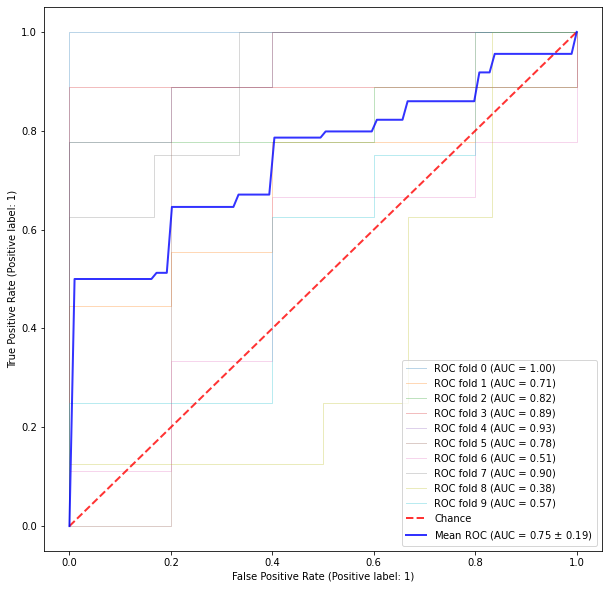

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 200}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 200}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 200}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 200}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 200}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 200}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 200}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 200}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 200}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 200}


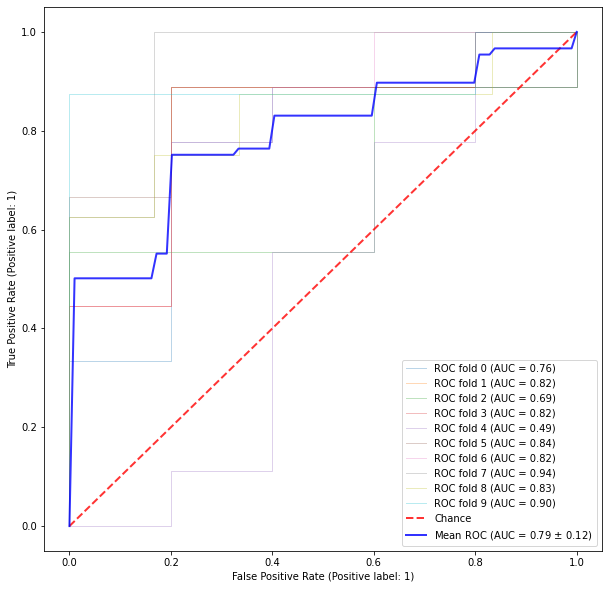

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 500}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 500}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 500}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 500}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 500}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 500}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 500}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 500}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 500}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 500}


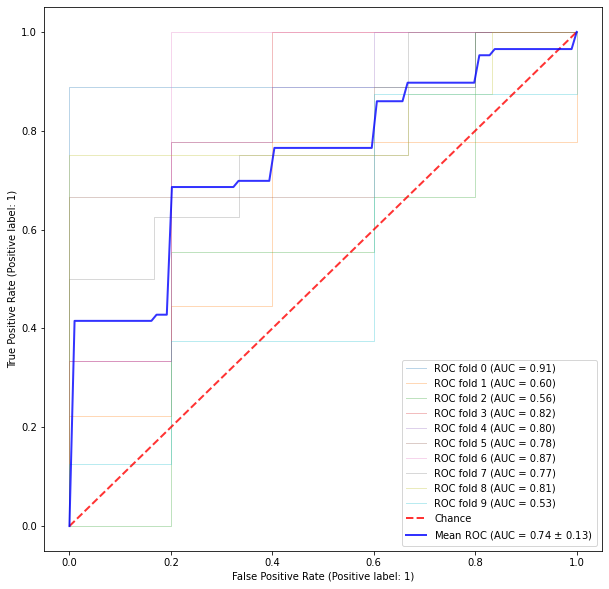

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 200}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 200}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 200}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 200}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 200}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 200}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 200}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 200}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 200}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 200}


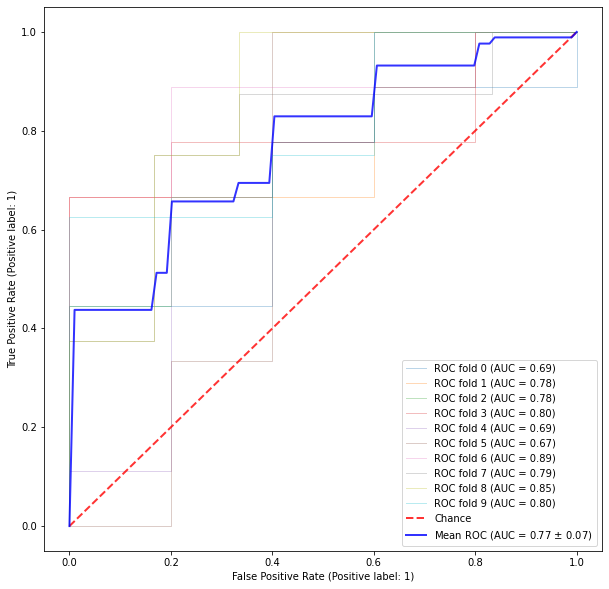

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 1000}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 1000}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 1000}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 1000}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 1000}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 1000}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 1000}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 1000}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 1000}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 1000}


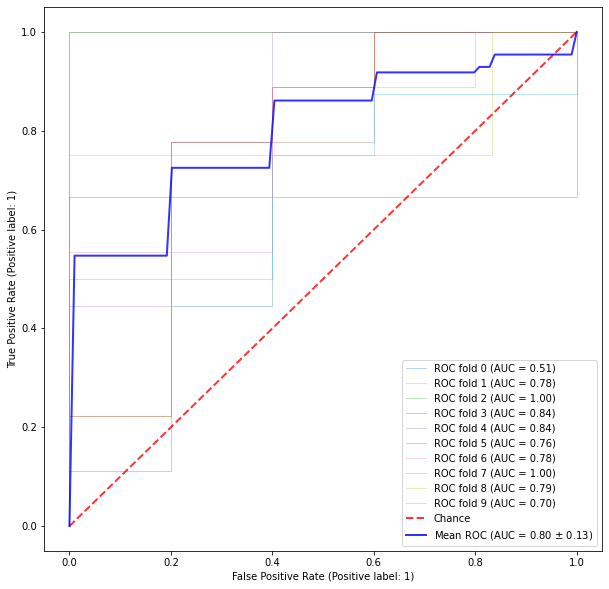

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 1000}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 1000}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 1000}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 1000}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 1000}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 1000}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 1000}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 1000}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 1000}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 1000}


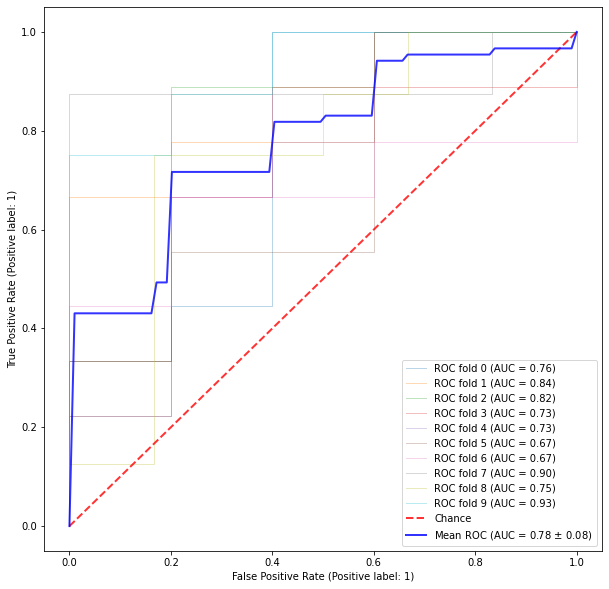

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 300}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 300}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 300}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 300}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 300}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 300}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 300}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 300}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 300}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 300}


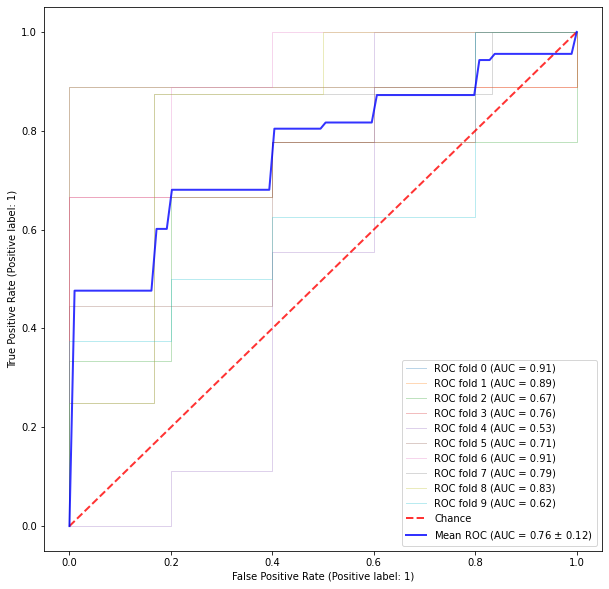

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 1000}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 1000}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 1000}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 1000}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 1000}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 1000}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 1000}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 1000}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 1000}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 1000}


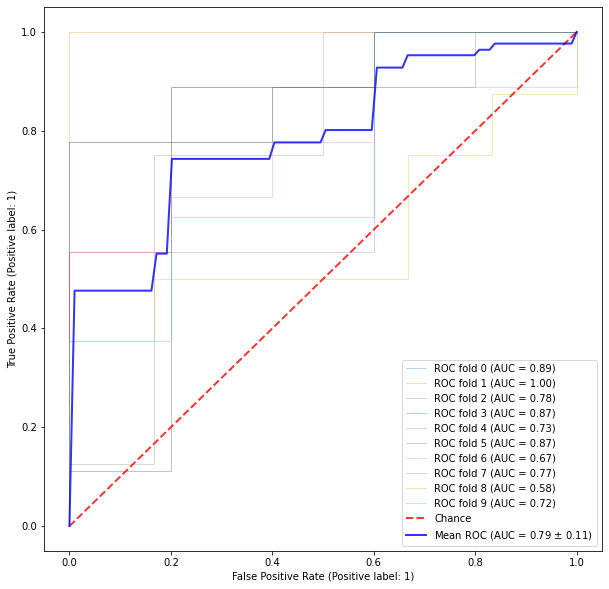

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 300}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 300}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 300}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 300}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 300}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 300}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 300}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 300}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 300}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 300}


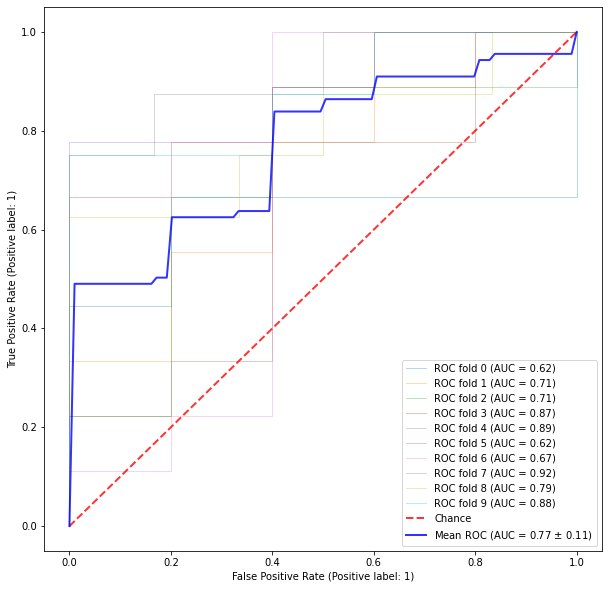

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 500}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 500}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 500}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 500}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 500}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 500}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 500}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 500}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 500}
{'solver': 'lbfgs', 'random_state': 10, 'penalty': 'l2', 'max_iter': 500}


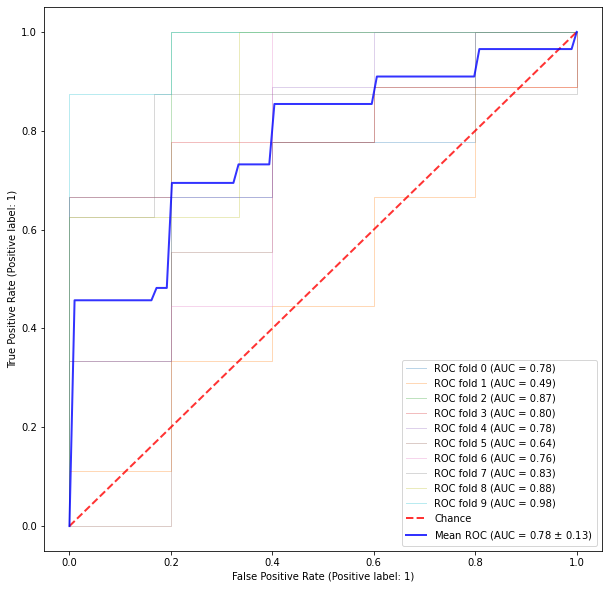

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
FPR
array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
       0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
       0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
       0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
       0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
       0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
       0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
       0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
       0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
       0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
       0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
       0.65656566, 0.66666667, 0.67676768, 0.68686869, 0.6969697 ,
   

In [ ]:
LR_train_I = Final_Model_Train(Train_Nested_wo_sampling, x_I, y_I, ML_model='LR', Tuning_param= LR_tuning, 
                               outer_loop= outer_loop, inner_loop= inner_loop, random_search_number= 3, random_seed= random_seed,
                               iteration_num = iteration_num, imp=False)

{'kernel': 'rbf'}
{'kernel': 'sigmoid'}
{'kernel': 'rbf'}
{'kernel': 'rbf'}
{'kernel': 'rbf'}
{'kernel': 'rbf'}
{'kernel': 'linear'}
{'kernel': 'rbf'}
{'kernel': 'rbf'}
{'kernel': 'rbf'}


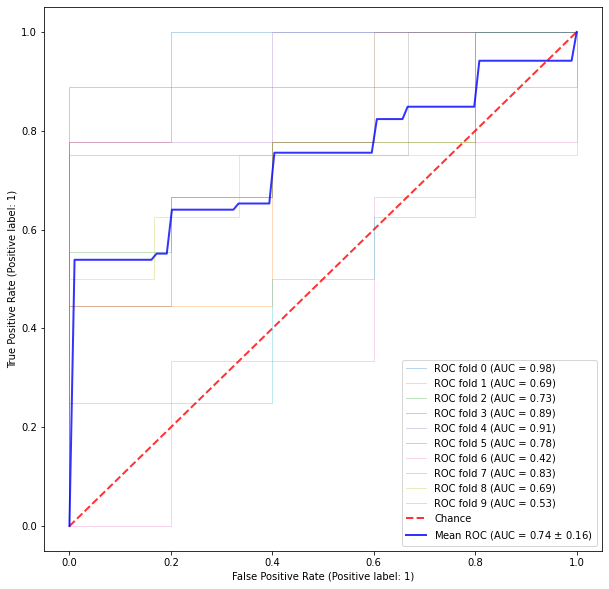

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
{'kernel': 'sigmoid'}
{'kernel': 'rbf'}
{'kernel': 'rbf'}
{'kernel': 'sigmoid'}
{'kernel': 'sigmoid'}
{'kernel': 'rbf'}
{'kernel': 'rbf'}
{'kernel': 'sigmoid'}
{'kernel': 'rbf'}
{'kernel': 'rbf'}


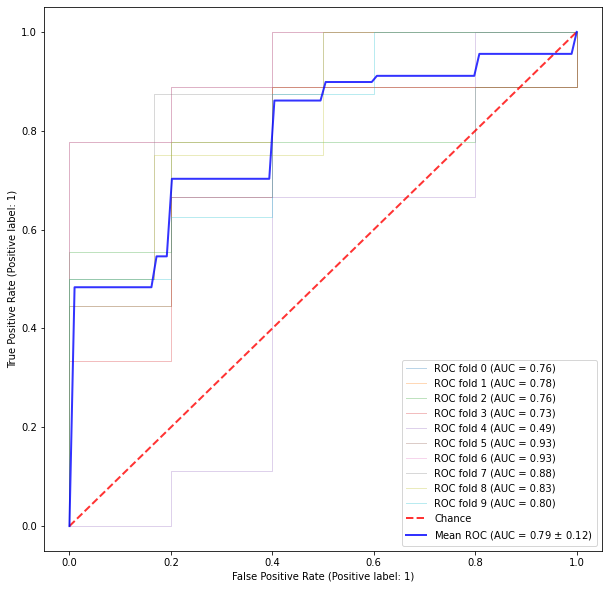

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
{'kernel': 'sigmoid'}
{'kernel': 'rbf'}
{'kernel': 'rbf'}
{'kernel': 'sigmoid'}
{'kernel': 'sigmoid'}
{'kernel': 'sigmoid'}
{'kernel': 'sigmoid'}
{'kernel': 'sigmoid'}
{'kernel': 'sigmoid'}
{'kernel': 'rbf'}


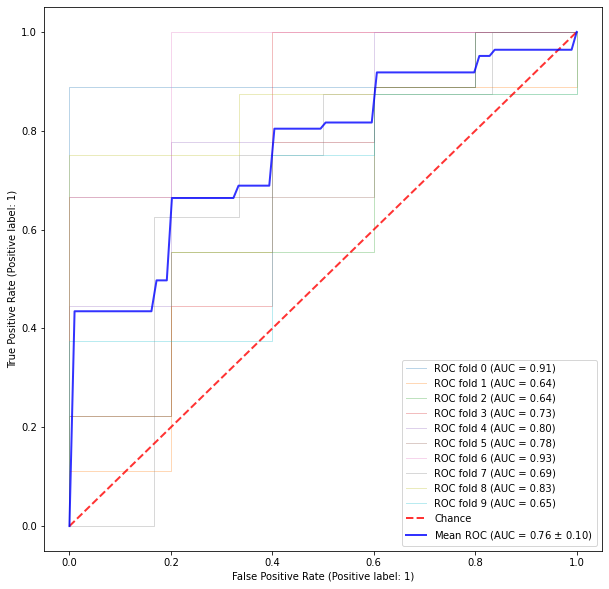

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
{'kernel': 'sigmoid'}
{'kernel': 'sigmoid'}
{'kernel': 'rbf'}
{'kernel': 'rbf'}
{'kernel': 'linear'}
{'kernel': 'rbf'}
{'kernel': 'rbf'}
{'kernel': 'rbf'}
{'kernel': 'sigmoid'}
{'kernel': 'rbf'}


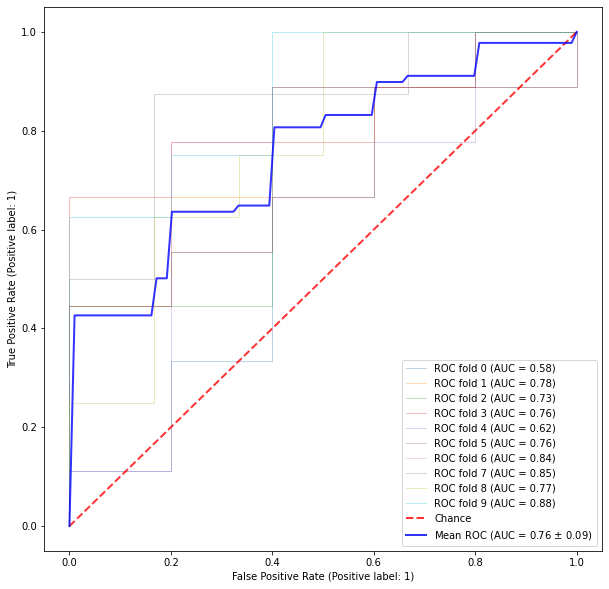

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
{'kernel': 'rbf'}
{'kernel': 'linear'}
{'kernel': 'rbf'}
{'kernel': 'sigmoid'}
{'kernel': 'sigmoid'}
{'kernel': 'sigmoid'}
{'kernel': 'rbf'}
{'kernel': 'rbf'}
{'kernel': 'sigmoid'}
{'kernel': 'sigmoid'}


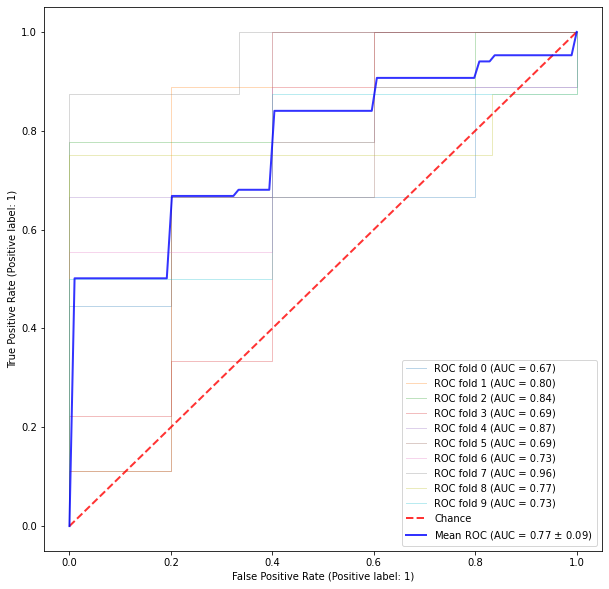

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
{'kernel': 'rbf'}
{'kernel': 'rbf'}
{'kernel': 'sigmoid'}
{'kernel': 'sigmoid'}
{'kernel': 'rbf'}
{'kernel': 'rbf'}
{'kernel': 'rbf'}
{'kernel': 'linear'}
{'kernel': 'rbf'}
{'kernel': 'sigmoid'}


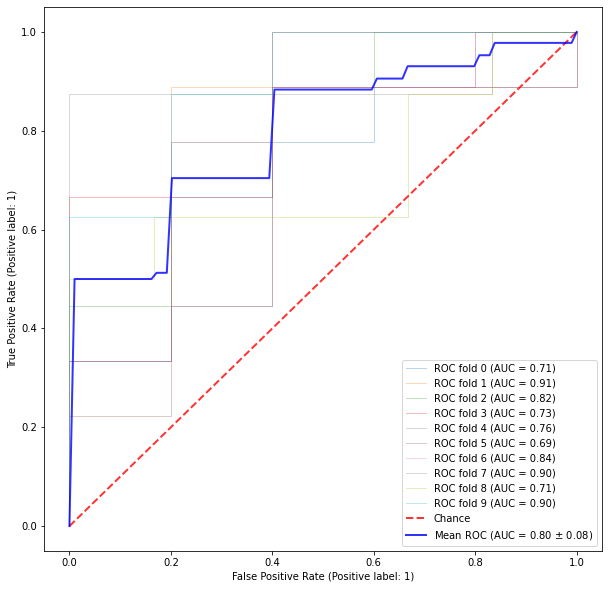

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
{'kernel': 'rbf'}
{'kernel': 'rbf'}
{'kernel': 'sigmoid'}
{'kernel': 'rbf'}
{'kernel': 'rbf'}
{'kernel': 'sigmoid'}
{'kernel': 'rbf'}
{'kernel': 'rbf'}
{'kernel': 'sigmoid'}
{'kernel': 'rbf'}


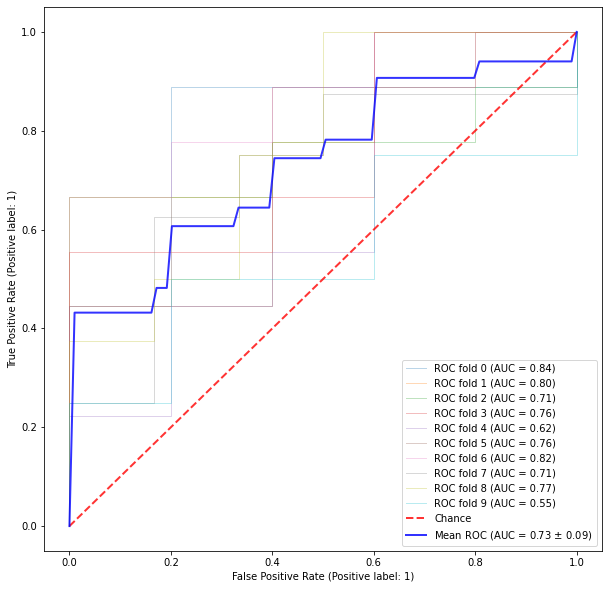

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
{'kernel': 'sigmoid'}
{'kernel': 'rbf'}
{'kernel': 'rbf'}
{'kernel': 'rbf'}
{'kernel': 'rbf'}
{'kernel': 'rbf'}
{'kernel': 'sigmoid'}
{'kernel': 'rbf'}
{'kernel': 'sigmoid'}
{'kernel': 'sigmoid'}


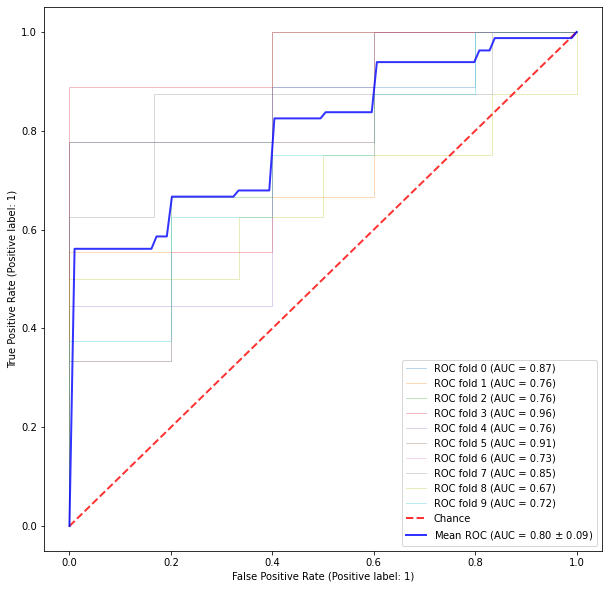

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
{'kernel': 'sigmoid'}
{'kernel': 'rbf'}
{'kernel': 'rbf'}
{'kernel': 'rbf'}
{'kernel': 'rbf'}
{'kernel': 'rbf'}
{'kernel': 'linear'}
{'kernel': 'rbf'}
{'kernel': 'sigmoid'}
{'kernel': 'rbf'}


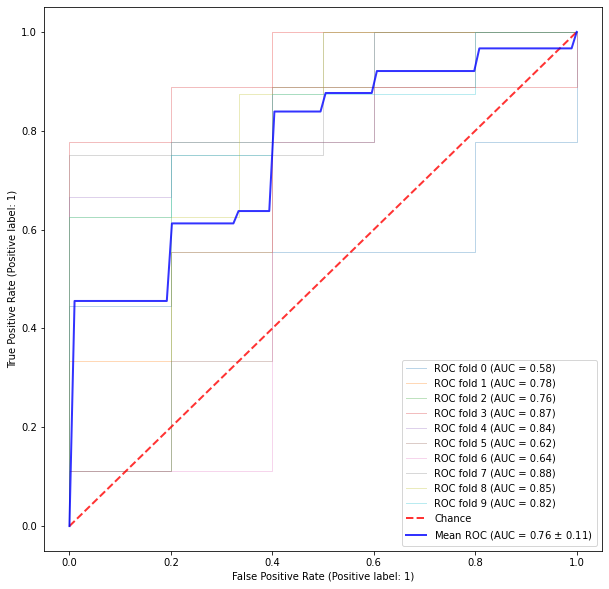

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
{'kernel': 'sigmoid'}
{'kernel': 'rbf'}
{'kernel': 'rbf'}
{'kernel': 'rbf'}
{'kernel': 'sigmoid'}
{'kernel': 'linear'}
{'kernel': 'rbf'}
{'kernel': 'rbf'}
{'kernel': 'rbf'}
{'kernel': 'rbf'}


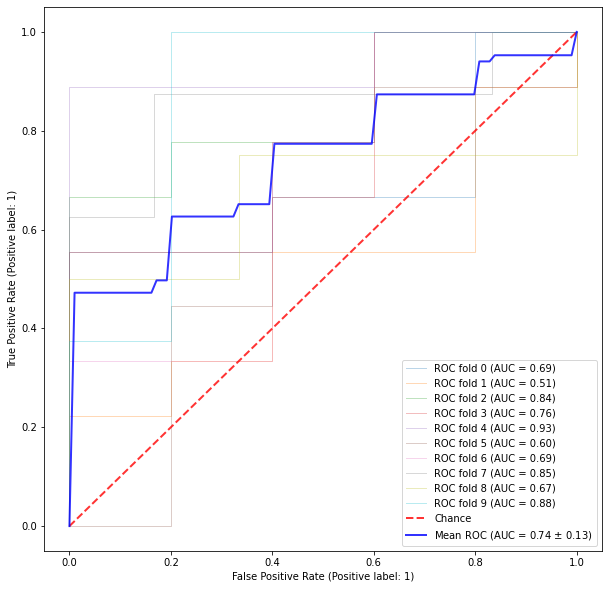

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
FPR
array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
       0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
       0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
       0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
       0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
       0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
       0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
       0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
       0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
       0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
       0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
       0.65656566, 0.66666667, 0.67676768, 0.68686869, 0.6969697 ,
   

In [ ]:
SVM_train_I = Final_Model_Train(Train_Nested_wo_sampling, x_I, y_I, ML_model='SVM', Tuning_param= svm_tuning, 
                               outer_loop= outer_loop, inner_loop= inner_loop, random_search_number= 3, random_seed= random_seed,
                               iteration_num = iteration_num, imp=False)

{'n_estimators': 20, 'learning_rate': 0.05}
{'n_estimators': 20, 'learning_rate': 0.05}
{'n_estimators': 20, 'learning_rate': 0.05}
{'n_estimators': 20, 'learning_rate': 0.05}
{'n_estimators': 20, 'learning_rate': 0.05}
{'n_estimators': 20, 'learning_rate': 0.05}
{'n_estimators': 20, 'learning_rate': 0.05}
{'n_estimators': 20, 'learning_rate': 0.05}
{'n_estimators': 20, 'learning_rate': 0.05}
{'n_estimators': 20, 'learning_rate': 0.05}


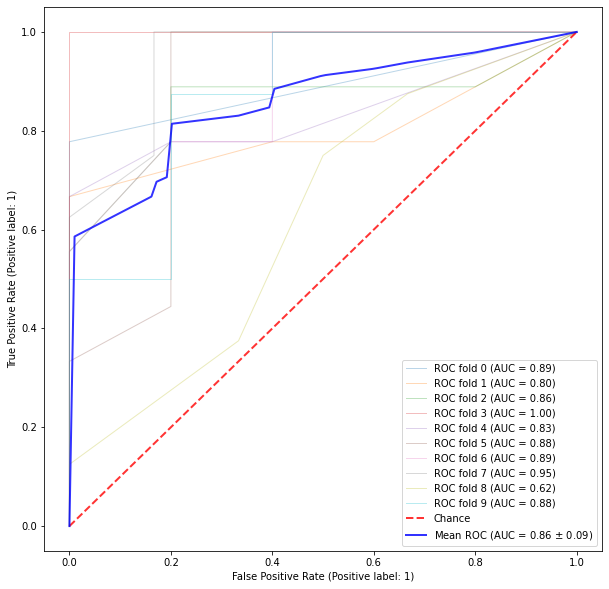

[[0.755 0.13  0.065 0.    0.05  0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.   ]]
{'n_estimators': 100, 'learning_rate': 0.1}
{'n_estimators': 100, 'learning_rate': 0.1}
{'n_estimators': 100, 'learning_rate': 0.1}
{'n_estimators': 100, 'learning_rate': 0.1}
{'n_estimators': 100, 'learning_rate': 0.1}
{'n_estimators': 300, 'learning_rate': 0.05}
{'n_estimators': 100, 'learning_rate': 0.1}
{'n_estimators': 100, 'learning_rate': 0.1}
{'n_estimators': 100, 'learning_rate': 0.1}
{'n_estimators': 20, 'learning_rate': 0.001}


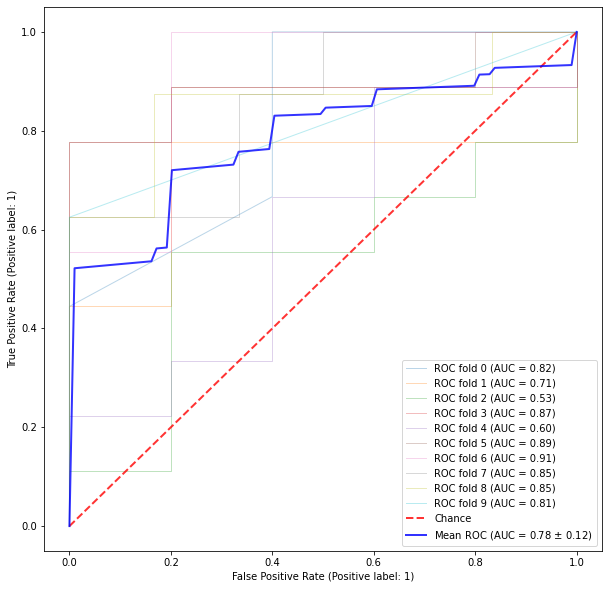

[[0.364      0.18533333 0.18333333 0.162      0.06033333 0.00366667
  0.003      0.         0.         0.02       0.01733333 0.
  0.         0.         0.         0.001      0.        ]]
{'n_estimators': 1000, 'learning_rate': 0.001}
{'n_estimators': 20, 'learning_rate': 0.05}
{'n_estimators': 400, 'learning_rate': 0.01}
{'n_estimators': 400, 'learning_rate': 0.01}
{'n_estimators': 400, 'learning_rate': 0.01}
{'n_estimators': 1000, 'learning_rate': 0.001}
{'n_estimators': 1000, 'learning_rate': 0.001}
{'n_estimators': 400, 'learning_rate': 0.01}
{'n_estimators': 400, 'learning_rate': 0.01}
{'n_estimators': 400, 'learning_rate': 0.01}


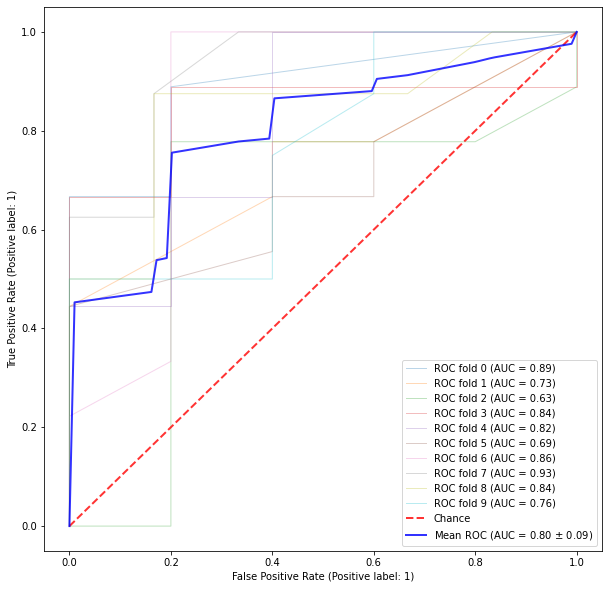

[[0.60785 0.17555 0.0924  0.05825 0.0417  0.      0.      0.      0.
  0.01325 0.011   0.      0.      0.      0.      0.      0.     ]]
{'n_estimators': 1000, 'learning_rate': 0.001}
{'n_estimators': 1000, 'learning_rate': 0.001}
{'n_estimators': 1000, 'learning_rate': 0.001}
{'n_estimators': 1000, 'learning_rate': 0.001}
{'n_estimators': 100, 'learning_rate': 0.1}
{'n_estimators': 1000, 'learning_rate': 0.001}
{'n_estimators': 1000, 'learning_rate': 0.001}
{'n_estimators': 1000, 'learning_rate': 0.001}
{'n_estimators': 1000, 'learning_rate': 0.001}
{'n_estimators': 1000, 'learning_rate': 0.001}


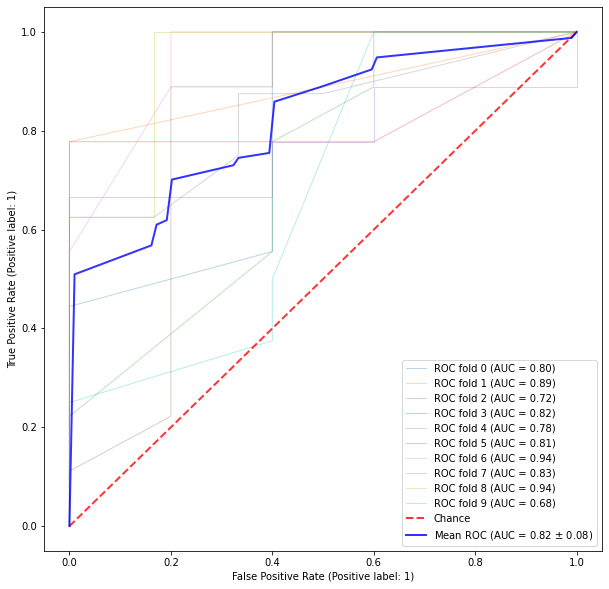

[[0.7381 0.1599 0.0534 0.015  0.0296 0.     0.     0.     0.     0.002
  0.002  0.     0.     0.     0.     0.     0.    ]]
{'n_estimators': 400, 'learning_rate': 0.01}
{'n_estimators': 400, 'learning_rate': 0.01}
{'n_estimators': 400, 'learning_rate': 0.01}
{'n_estimators': 400, 'learning_rate': 0.01}
{'n_estimators': 400, 'learning_rate': 0.01}
{'n_estimators': 400, 'learning_rate': 0.01}
{'n_estimators': 400, 'learning_rate': 0.01}
{'n_estimators': 400, 'learning_rate': 0.01}
{'n_estimators': 400, 'learning_rate': 0.01}
{'n_estimators': 400, 'learning_rate': 0.01}


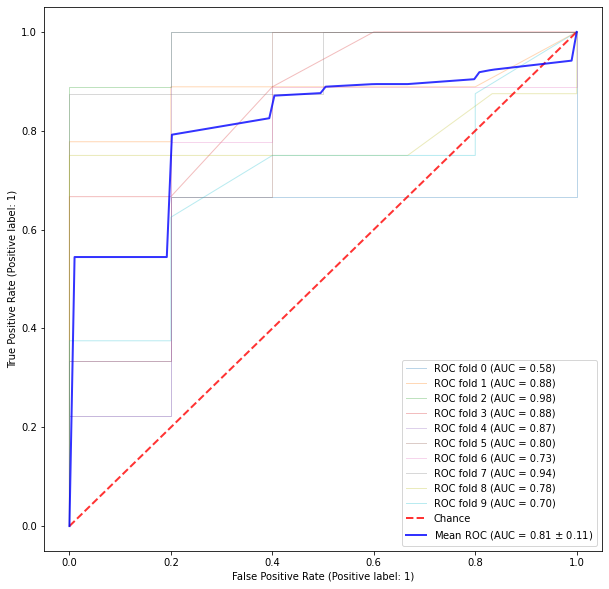

[[0.49925 0.1905  0.112   0.113   0.06275 0.      0.      0.      0.
  0.012   0.0105  0.      0.      0.      0.      0.      0.     ]]
{'n_estimators': 100, 'learning_rate': 0.01}
{'n_estimators': 100, 'learning_rate': 0.01}
{'n_estimators': 100, 'learning_rate': 0.05}
{'n_estimators': 100, 'learning_rate': 0.01}
{'n_estimators': 100, 'learning_rate': 0.05}
{'n_estimators': 100, 'learning_rate': 0.01}
{'n_estimators': 100, 'learning_rate': 0.01}
{'n_estimators': 100, 'learning_rate': 0.01}
{'n_estimators': 20, 'learning_rate': 0.5}
{'n_estimators': 100, 'learning_rate': 0.01}


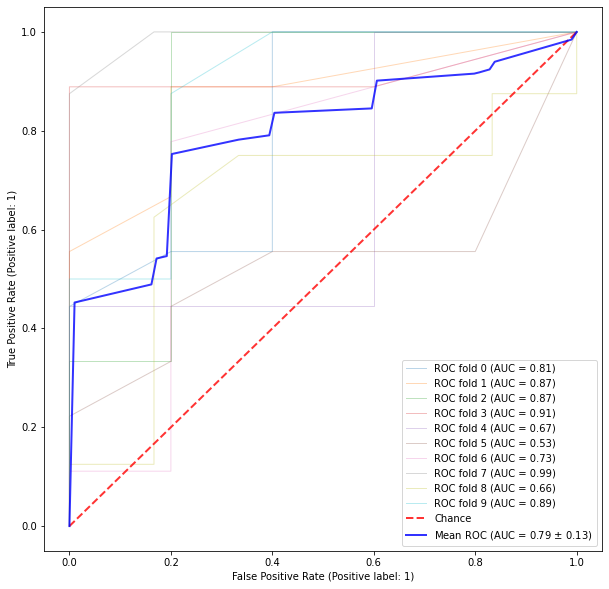

[[0.664 0.154 0.088 0.034 0.056 0.    0.    0.    0.    0.002 0.002 0.
  0.    0.    0.    0.    0.   ]]
{'n_estimators': 20, 'learning_rate': 0.1}
{'n_estimators': 20, 'learning_rate': 0.1}
{'n_estimators': 20, 'learning_rate': 0.1}
{'n_estimators': 20, 'learning_rate': 0.1}
{'n_estimators': 20, 'learning_rate': 0.1}
{'n_estimators': 20, 'learning_rate': 0.1}
{'n_estimators': 20, 'learning_rate': 0.1}
{'n_estimators': 20, 'learning_rate': 0.1}
{'n_estimators': 20, 'learning_rate': 0.1}
{'n_estimators': 20, 'learning_rate': 0.1}


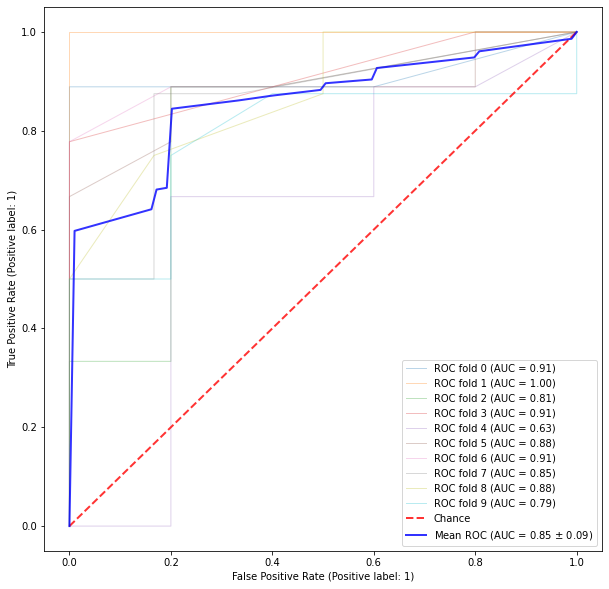

[[0.65  0.205 0.08  0.015 0.05  0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.   ]]
{'n_estimators': 300, 'learning_rate': 0.01}
{'n_estimators': 400, 'learning_rate': 0.01}
{'n_estimators': 300, 'learning_rate': 0.01}
{'n_estimators': 400, 'learning_rate': 0.01}
{'n_estimators': 400, 'learning_rate': 0.01}
{'n_estimators': 400, 'learning_rate': 0.01}
{'n_estimators': 300, 'learning_rate': 0.01}
{'n_estimators': 300, 'learning_rate': 0.01}
{'n_estimators': 400, 'learning_rate': 0.01}
{'n_estimators': 300, 'learning_rate': 0.01}


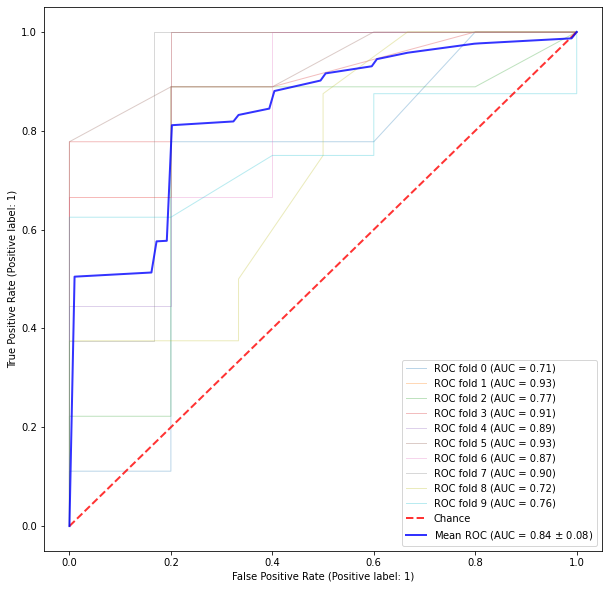

[[0.5705     0.19875    0.1035     0.06275    0.05075    0.
  0.         0.         0.         0.00708333 0.00666667 0.
  0.         0.         0.         0.         0.        ]]
{'n_estimators': 20, 'learning_rate': 0.05}
{'n_estimators': 20, 'learning_rate': 0.05}
{'n_estimators': 20, 'learning_rate': 0.05}
{'n_estimators': 20, 'learning_rate': 0.05}
{'n_estimators': 20, 'learning_rate': 0.05}
{'n_estimators': 20, 'learning_rate': 0.05}
{'n_estimators': 20, 'learning_rate': 0.05}
{'n_estimators': 20, 'learning_rate': 0.05}
{'n_estimators': 20, 'learning_rate': 0.05}
{'n_estimators': 20, 'learning_rate': 0.05}


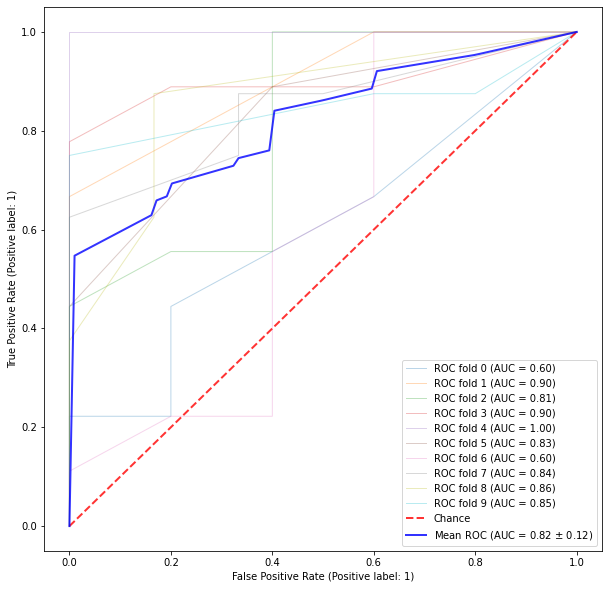

[[0.765 0.115 0.07  0.    0.05  0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.   ]]
{'n_estimators': 300, 'learning_rate': 0.01}
{'n_estimators': 300, 'learning_rate': 0.01}
{'n_estimators': 300, 'learning_rate': 0.01}
{'n_estimators': 300, 'learning_rate': 0.01}
{'n_estimators': 300, 'learning_rate': 0.01}
{'n_estimators': 1000, 'learning_rate': 0.001}
{'n_estimators': 300, 'learning_rate': 0.01}
{'n_estimators': 300, 'learning_rate': 0.01}
{'n_estimators': 300, 'learning_rate': 0.01}
{'n_estimators': 300, 'learning_rate': 0.01}


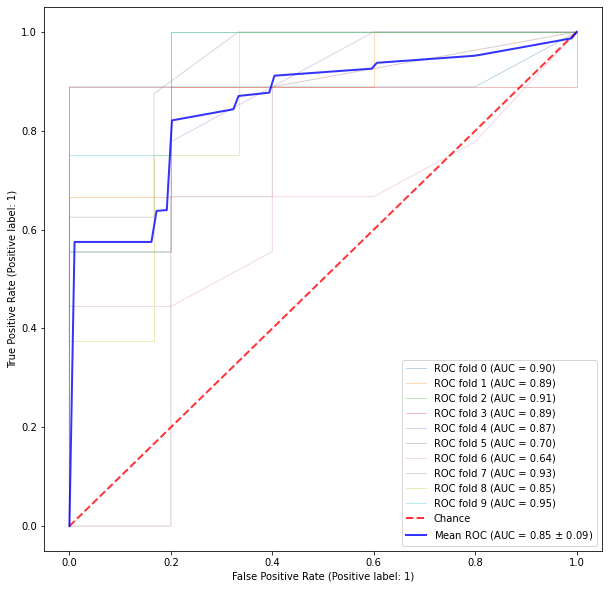

[[0.60686667 0.1972     0.08916667 0.04533333 0.04843333 0.
  0.         0.         0.         0.00566667 0.00733333 0.
  0.         0.         0.         0.         0.        ]]
FPR
array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
       0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
       0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
       0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
       0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
       0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
       0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
       0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
       0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
       0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
       0.6060

In [ ]:
AdaBoost_train_I = Final_Model_Train(Train_Nested_wo_sampling, x_I, y_I, ML_model='AdaBoost', Tuning_param= AdaBoost_tuning, 
                                      outer_loop= outer_loop, inner_loop= inner_loop, random_search_number= 5, random_seed= random_seed,
                                      iteration_num = iteration_num, imp=True)

{'n_estimators': 150, 'min_samples_split': 14, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'max_depth': 3, 'criterion': 'gini', 'bootstrap': True}
{'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 12, 'max_features': 'sqrt', 'max_depth': 14, 'criterion': 'entropy', 'bootstrap': True}
{'n_estimators': 150, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 7, 'criterion': 'entropy', 'bootstrap': True}
{'n_estimators': 50, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 5, 'criterion': 'gini', 'bootstrap': False}
{'n_estimators': 150, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 7, 'criterion': 'entropy', 'bootstrap': True}
{'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 12, 'max_features': 'sqrt', 'max_depth': 14, 'criterion': 'entropy', 'bootstrap': True}
{'n_estimators': 150, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 's

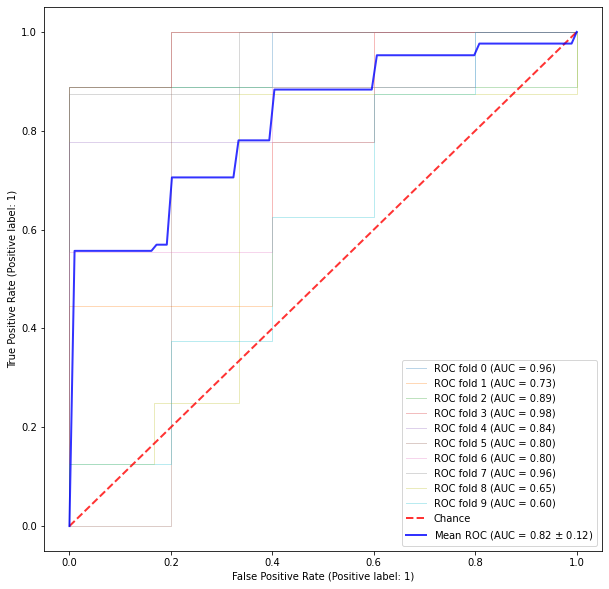

[[0.33030782 0.16955969 0.16225303 0.07147975 0.1250024  0.00844868
  0.00971081 0.0047028  0.00610995 0.03219868 0.03191339 0.00638667
  0.00797136 0.00836161 0.00964878 0.00698505 0.00895955]]
{'n_estimators': 350, 'min_samples_split': 12, 'min_samples_leaf': 5, 'max_features': 'auto', 'max_depth': 3, 'criterion': 'gini', 'bootstrap': False}
{'n_estimators': 250, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 'auto', 'max_depth': 7, 'criterion': 'entropy', 'bootstrap': True}
{'n_estimators': 350, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 3, 'criterion': 'gini', 'bootstrap': False}
{'n_estimators': 250, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 'auto', 'max_depth': 7, 'criterion': 'entropy', 'bootstrap': True}
{'n_estimators': 350, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 3, 'criterion': 'gini', 'bootstrap': False}
{'n_estimators': 350, 'min_samples_split': 12, '

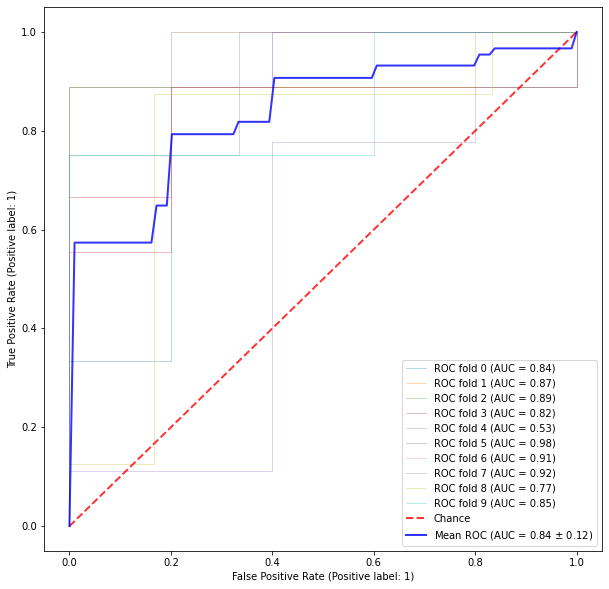

[[0.35729014 0.15953965 0.1575307  0.06828511 0.12627127 0.00771753
  0.0090644  0.00447736 0.00448843 0.02890306 0.03141818 0.00702878
  0.00659796 0.00620065 0.00634621 0.00944767 0.00939289]]
{'n_estimators': 250, 'min_samples_split': 6, 'min_samples_leaf': 6, 'max_features': 'auto', 'max_depth': 3, 'criterion': 'entropy', 'bootstrap': False}
{'n_estimators': 250, 'min_samples_split': 6, 'min_samples_leaf': 6, 'max_features': 'auto', 'max_depth': 3, 'criterion': 'entropy', 'bootstrap': False}
{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 12, 'criterion': 'gini', 'bootstrap': False}
{'n_estimators': 50, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 3, 'criterion': 'gini', 'bootstrap': False}
{'n_estimators': 50, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 3, 'criterion': 'gini', 'bootstrap': False}
{'n_estimators': 250, 'min_samples_split': 6, 'min

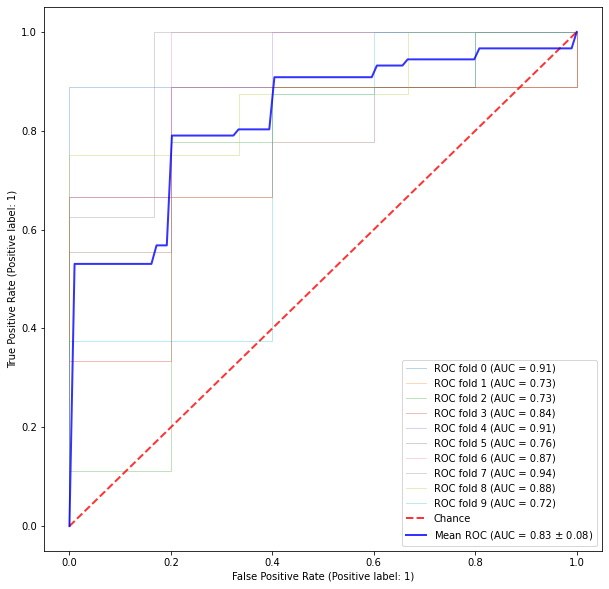

[[0.33514183 0.14847478 0.15032207 0.0695089  0.17085291 0.00888238
  0.00776526 0.00231668 0.00311835 0.03239765 0.03355976 0.00692313
  0.00508986 0.00379749 0.00437668 0.00984611 0.00762615]]
{'n_estimators': 1000, 'min_samples_split': 14, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'max_depth': 3, 'criterion': 'entropy', 'bootstrap': True}
{'n_estimators': 1000, 'min_samples_split': 14, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'max_depth': 3, 'criterion': 'entropy', 'bootstrap': True}
{'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 7, 'max_features': 'auto', 'max_depth': 18, 'criterion': 'gini', 'bootstrap': False}
{'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 7, 'max_features': 'auto', 'max_depth': 18, 'criterion': 'gini', 'bootstrap': False}
{'n_estimators': 1000, 'min_samples_split': 14, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'max_depth': 3, 'criterion': 'entropy', 'bootstrap': True}
{'n_estimators': 200, 'min_samples_spli

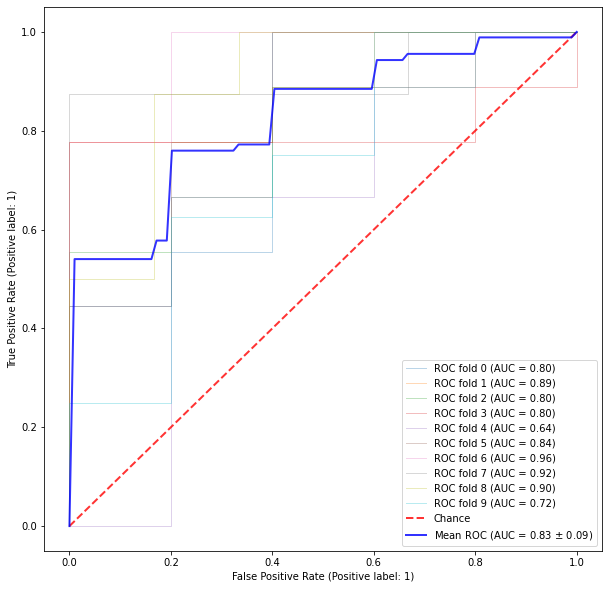

[[0.3525611  0.1614234  0.16478746 0.06727972 0.13263342 0.00749326
  0.00893665 0.00288075 0.00264575 0.03145324 0.03209289 0.00608301
  0.00700622 0.00553302 0.00664461 0.00526776 0.00527776]]
{'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'max_depth': 7, 'criterion': 'entropy', 'bootstrap': True}
{'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'max_depth': 7, 'criterion': 'entropy', 'bootstrap': True}
{'n_estimators': 250, 'min_samples_split': 14, 'min_samples_leaf': 6, 'max_features': 'auto', 'max_depth': 12, 'criterion': 'entropy', 'bootstrap': True}
{'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'max_depth': 7, 'criterion': 'entropy', 'bootstrap': True}
{'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'max_depth': 7, 'criterion': 'entropy', 'bootstrap': True}
{'n_estimators': 400, 'min_samples_split': 

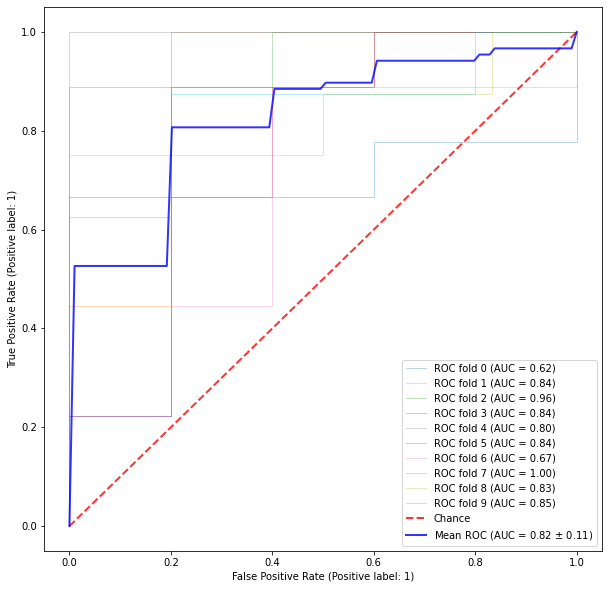

[[0.31578395 0.1576048  0.15301438 0.08084504 0.14408176 0.00980759
  0.0085379  0.0066992  0.00535837 0.02937277 0.03308798 0.00831926
  0.008723   0.0102986  0.01008725 0.00896297 0.00941518]]
{'n_estimators': 250, 'min_samples_split': 12, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'max_depth': 18, 'criterion': 'entropy', 'bootstrap': False}
{'n_estimators': 1000, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'auto', 'max_depth': 6, 'criterion': 'entropy', 'bootstrap': False}
{'n_estimators': 250, 'min_samples_split': 12, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'max_depth': 18, 'criterion': 'entropy', 'bootstrap': False}
{'n_estimators': 250, 'min_samples_split': 12, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'max_depth': 18, 'criterion': 'entropy', 'bootstrap': False}
{'n_estimators': 250, 'min_samples_split': 12, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'max_depth': 18, 'criterion': 'entropy', 'bootstrap': False}
{'n_estimators': 250, 'min_samp

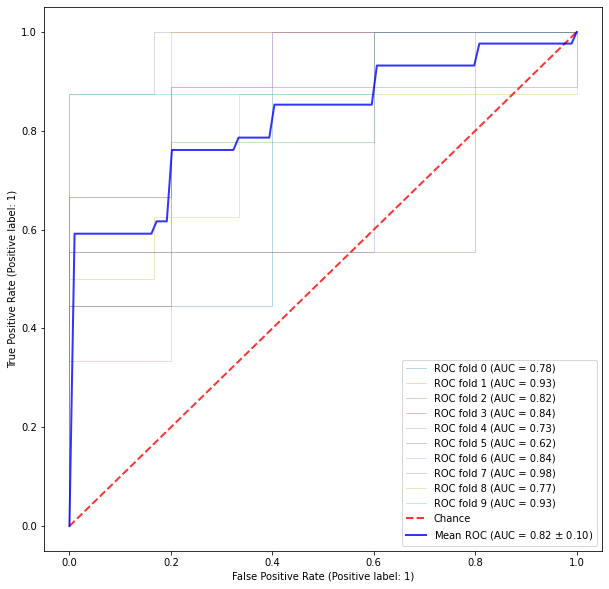

[[0.31654152 0.16775221 0.15268039 0.07316612 0.1485144  0.01320614
  0.01268735 0.00503212 0.00616304 0.03144352 0.02732782 0.00640014
  0.00763188 0.00736875 0.00615035 0.00782568 0.01010858]]
{'n_estimators': 300, 'min_samples_split': 6, 'min_samples_leaf': 7, 'max_features': 'auto', 'max_depth': 6, 'criterion': 'entropy', 'bootstrap': True}
{'n_estimators': 300, 'min_samples_split': 6, 'min_samples_leaf': 7, 'max_features': 'auto', 'max_depth': 6, 'criterion': 'entropy', 'bootstrap': True}
{'n_estimators': 250, 'min_samples_split': 14, 'min_samples_leaf': 12, 'max_features': 'sqrt', 'max_depth': 5, 'criterion': 'gini', 'bootstrap': False}
{'n_estimators': 20, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'max_depth': 12, 'criterion': 'entropy', 'bootstrap': False}
{'n_estimators': 350, 'min_samples_split': 8, 'min_samples_leaf': 7, 'max_features': 'auto', 'max_depth': 7, 'criterion': 'gini', 'bootstrap': True}
{'n_estimators': 350, 'min_samples_split': 8, 

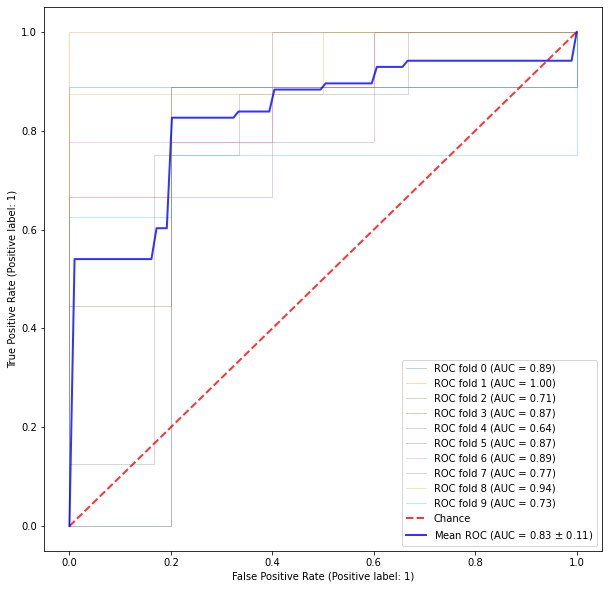

[[0.34625117 0.16784568 0.15203793 0.0656607  0.13242258 0.00711746
  0.00923671 0.00367558 0.00373468 0.03831752 0.03466225 0.00597519
  0.00555395 0.00754691 0.00882322 0.00522471 0.00591376]]
{'n_estimators': 150, 'min_samples_split': 6, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'max_depth': 7, 'criterion': 'entropy', 'bootstrap': False}
{'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 14, 'criterion': 'entropy', 'bootstrap': True}
{'n_estimators': 500, 'min_samples_split': 12, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'max_depth': 5, 'criterion': 'gini', 'bootstrap': False}
{'n_estimators': 150, 'min_samples_split': 6, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'max_depth': 7, 'criterion': 'entropy', 'bootstrap': False}
{'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 14, 'criterion': 'entropy', 'bootstrap': True}
{'n_estimators': 1000, 'min_samples_sp

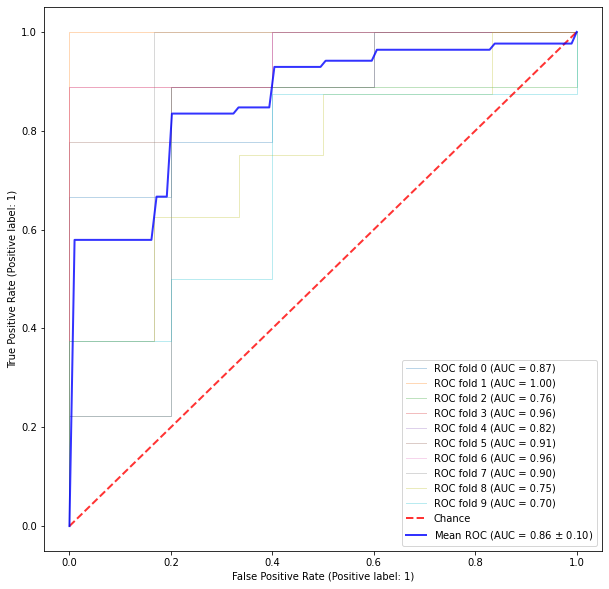

[[0.30995    0.16015287 0.15876039 0.08515681 0.15276616 0.00767369
  0.00805438 0.00600124 0.00577841 0.0261059  0.02567791 0.00786986
  0.00802887 0.00808734 0.00817182 0.01083024 0.01093411]]
{'n_estimators': 250, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 14, 'criterion': 'entropy', 'bootstrap': False}
{'n_estimators': 400, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 'auto', 'max_depth': 3, 'criterion': 'gini', 'bootstrap': False}
{'n_estimators': 400, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 'auto', 'max_depth': 3, 'criterion': 'gini', 'bootstrap': False}
{'n_estimators': 400, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 'auto', 'max_depth': 3, 'criterion': 'gini', 'bootstrap': False}
{'n_estimators': 400, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 'auto', 'max_depth': 3, 'criterion': 'gini', 'bootstrap': False}
{'n_estimators': 250, 'min_samples_split': 10, 'mi

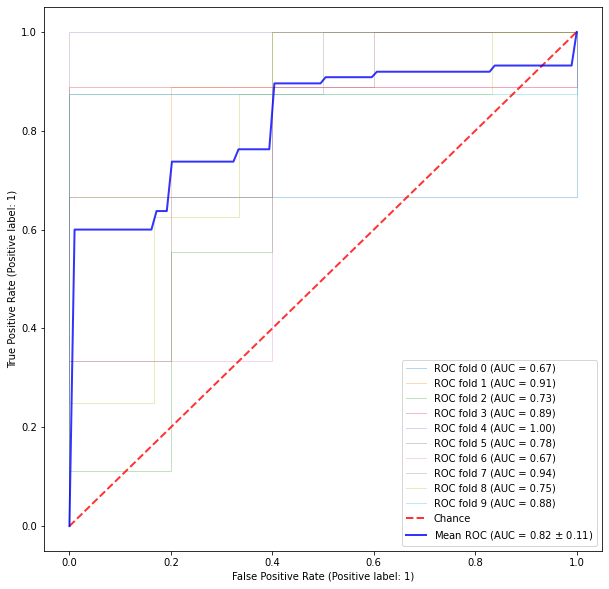

[[0.33034718 0.16357021 0.15671578 0.07251819 0.1469357  0.00635562
  0.00808563 0.00467981 0.0046119  0.0286168  0.03492903 0.00559658
  0.00679288 0.00570695 0.0058685  0.00933618 0.00933306]]
{'n_estimators': 300, 'min_samples_split': 12, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'max_depth': 5, 'criterion': 'entropy', 'bootstrap': False}
{'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'max_depth': 7, 'criterion': 'gini', 'bootstrap': True}
{'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'max_depth': 7, 'criterion': 'gini', 'bootstrap': True}
{'n_estimators': 300, 'min_samples_split': 12, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'max_depth': 5, 'criterion': 'entropy', 'bootstrap': False}
{'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 1, 'criterion': 'gini', 'bootstrap': False}
{'n_estimators': 250, 'min_samples_split': 10, 

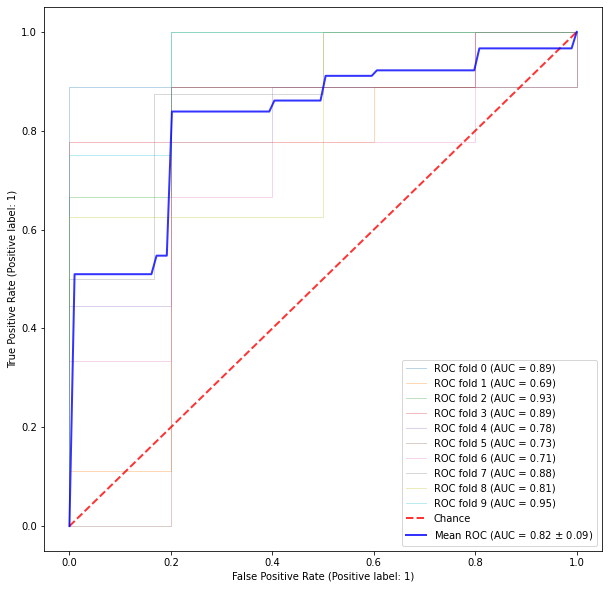

[[0.33713031 0.16675777 0.16306411 0.06720469 0.12443634 0.0124158
  0.01414435 0.00376286 0.0033039  0.03054415 0.03847222 0.00635527
  0.00609934 0.00676303 0.00840126 0.00570353 0.00544108]]
FPR
array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
       0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
       0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
       0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
       0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
       0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
       0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
       0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
       0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
       0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 

In [ ]:
RF_train_I = Final_Model_Train(Train_Nested_wo_sampling, x_I, y_I, ML_model='RF', Tuning_param= RF_tuning_parameter, 
                                outer_loop= outer_loop, inner_loop= inner_loop, random_search_number= 5, random_seed= random_seed,
                                iteration_num = iteration_num, imp=True)

{'subsample': 0.5, 'n_estimators': 10, 'min_child_weight': 0.5, 'max_leaf_nodes': 10, 'max_depth': 6, 'max_delta_step ': 1, 'lambda ': 0.1, 'gama': 0.2, 'eta': 0.1, 'colsample_bytree ': 0.5, 'colsample_bynode ': 0.5, 'colsample_bylevel ': 0.8, 'alpha': 0.1}
{'subsample': 0.1, 'n_estimators': 50, 'min_child_weight': 0.5, 'max_leaf_nodes': 9, 'max_depth': 1, 'max_delta_step ': 0, 'lambda ': 0.1, 'gama': 0.05, 'eta': 0.01, 'colsample_bytree ': 0.5, 'colsample_bynode ': 0.8, 'colsample_bylevel ': 0.8, 'alpha': 0.1}
{'subsample': 0.5, 'n_estimators': 300, 'min_child_weight': 0.1, 'max_leaf_nodes': 4, 'max_depth': 3, 'max_delta_step ': 2, 'lambda ': 0.3, 'gama': 0.1, 'eta': 0.01, 'colsample_bytree ': 0.6, 'colsample_bynode ': 0.2, 'colsample_bylevel ': 0.6, 'alpha': 0.1}
{'subsample': 0.8, 'n_estimators': 300, 'min_child_weight': 0.1, 'max_leaf_nodes': 6, 'max_depth': 6, 'max_delta_step ': 0, 'lambda ': 0.05, 'gama': 0.2, 'eta': 0.03, 'colsample_bytree ': 0.8, 'colsample_bynode ': 0.3, 'cols

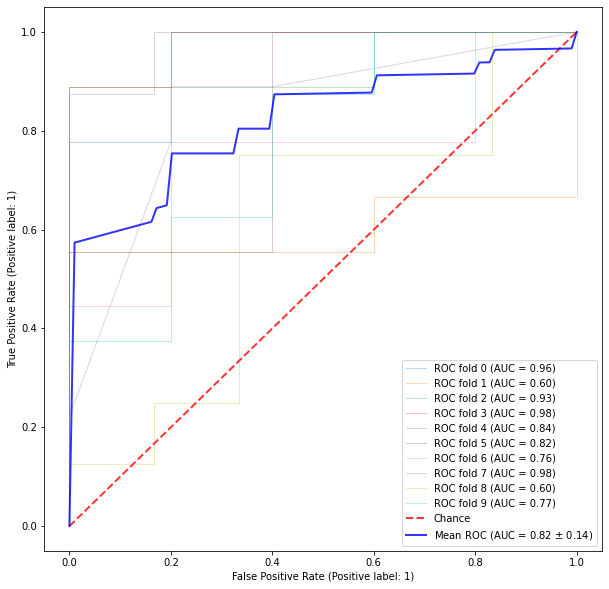

{'subsample': 0.1, 'n_estimators': 50, 'min_child_weight': 0.1, 'max_leaf_nodes': 9, 'max_depth': 5, 'max_delta_step ': 0, 'lambda ': 0.5, 'gama': 0.05, 'eta': 0.01, 'colsample_bytree ': 0.8, 'colsample_bynode ': 0.5, 'colsample_bylevel ': 0.8, 'alpha': 0.01}
{'subsample': 0.5, 'n_estimators': 100, 'min_child_weight': 0.1, 'max_leaf_nodes': 10, 'max_depth': 10, 'max_delta_step ': 2, 'lambda ': 0.01, 'gama': 0.2, 'eta': 0.01, 'colsample_bytree ': 0.6, 'colsample_bynode ': 0.3, 'colsample_bylevel ': 0.8, 'alpha': 0.5}
{'subsample': 0.1, 'n_estimators': 50, 'min_child_weight': 0.1, 'max_leaf_nodes': 9, 'max_depth': 5, 'max_delta_step ': 0, 'lambda ': 0.5, 'gama': 0.05, 'eta': 0.01, 'colsample_bytree ': 0.8, 'colsample_bynode ': 0.5, 'colsample_bylevel ': 0.8, 'alpha': 0.01}
{'subsample': 0.8, 'n_estimators': 100, 'min_child_weight': 0.5, 'max_leaf_nodes': 9, 'max_depth': 1, 'max_delta_step ': 5, 'lambda ': 0.01, 'gama': 0.05, 'eta': 0.05, 'colsample_bytree ': 0.6, 'colsample_bynode ': 0.8

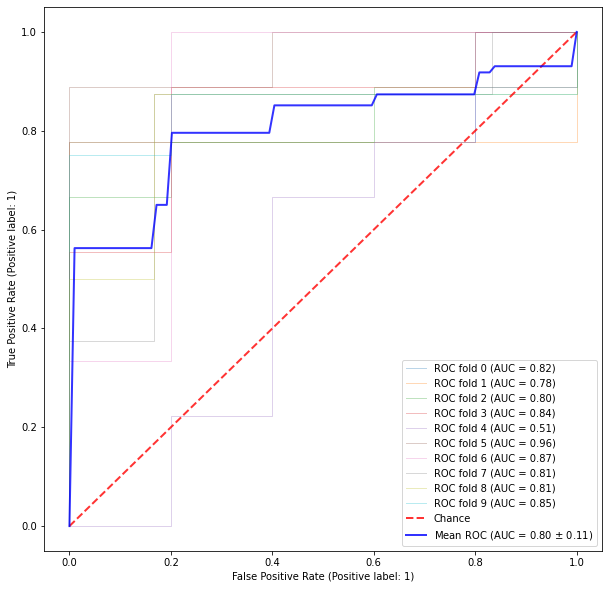

{'subsample': 1, 'n_estimators': 50, 'min_child_weight': 0.5, 'max_leaf_nodes': 6, 'max_depth': 5, 'max_delta_step ': 0, 'lambda ': 0.3, 'gama': 0.5, 'eta': 0.05, 'colsample_bytree ': 0.8, 'colsample_bynode ': 0.5, 'colsample_bylevel ': 0.6, 'alpha': 0.001}
{'subsample': 0.1, 'n_estimators': 20, 'min_child_weight': 0.3, 'max_leaf_nodes': 10, 'max_depth': 5, 'max_delta_step ': 0, 'lambda ': 0.05, 'gama': 0.2, 'eta': 0.05, 'colsample_bytree ': 0.5, 'colsample_bynode ': 0.2, 'colsample_bylevel ': 0.8, 'alpha': 0.01}
{'subsample': 0.5, 'n_estimators': 300, 'min_child_weight': 0.1, 'max_leaf_nodes': 6, 'max_depth': 10, 'max_delta_step ': 5, 'lambda ': 0.01, 'gama': 0.2, 'eta': 0.05, 'colsample_bytree ': 0.5, 'colsample_bynode ': 0.5, 'colsample_bylevel ': 0.4, 'alpha': 0.01}
{'subsample': 1, 'n_estimators': 100, 'min_child_weight': 0.5, 'max_leaf_nodes': 4, 'max_depth': 1, 'max_delta_step ': 0, 'lambda ': 0.05, 'gama': 0.01, 'eta': 0.05, 'colsample_bytree ': 0.5, 'colsample_bynode ': 0.3, '

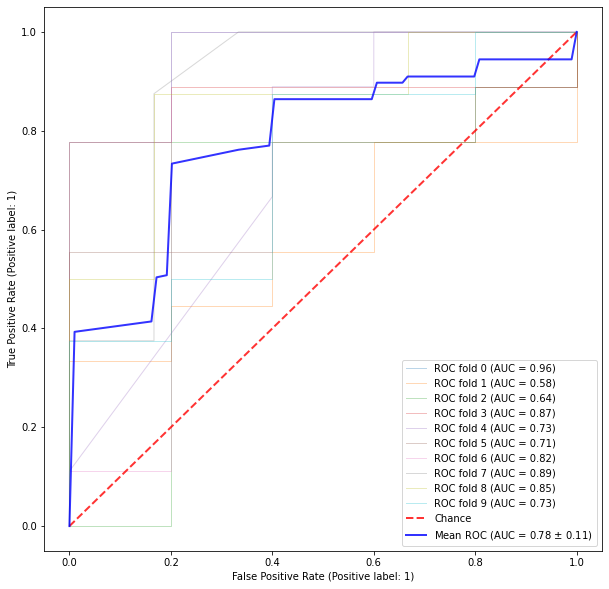

{'subsample': 0.5, 'n_estimators': 5, 'min_child_weight': 0.3, 'max_leaf_nodes': 4, 'max_depth': 7, 'max_delta_step ': 5, 'lambda ': 0.05, 'gama': 0.5, 'eta': 0.05, 'colsample_bytree ': 0.8, 'colsample_bynode ': 0.2, 'colsample_bylevel ': 0.4, 'alpha': 0.5}
{'subsample': 0.5, 'n_estimators': 300, 'min_child_weight': 0.3, 'max_leaf_nodes': 9, 'max_depth': 6, 'max_delta_step ': 0, 'lambda ': 0.01, 'gama': 0.2, 'eta': 0.01, 'colsample_bytree ': 0.8, 'colsample_bynode ': 0.5, 'colsample_bylevel ': 0.4, 'alpha': 0.01}
{'subsample': 0.5, 'n_estimators': 10, 'min_child_weight': 0.3, 'max_leaf_nodes': 10, 'max_depth': 6, 'max_delta_step ': 5, 'lambda ': 0.01, 'gama': 0.5, 'eta': 0.05, 'colsample_bytree ': 0.8, 'colsample_bynode ': 0.2, 'colsample_bylevel ': 0.6, 'alpha': 0.5}
{'subsample': 0.1, 'n_estimators': 50, 'min_child_weight': 0.1, 'max_leaf_nodes': 6, 'max_depth': 7, 'max_delta_step ': 0, 'lambda ': 0.05, 'gama': 0.2, 'eta': 0.2, 'colsample_bytree ': 0.6, 'colsample_bynode ': 0.8, 'col

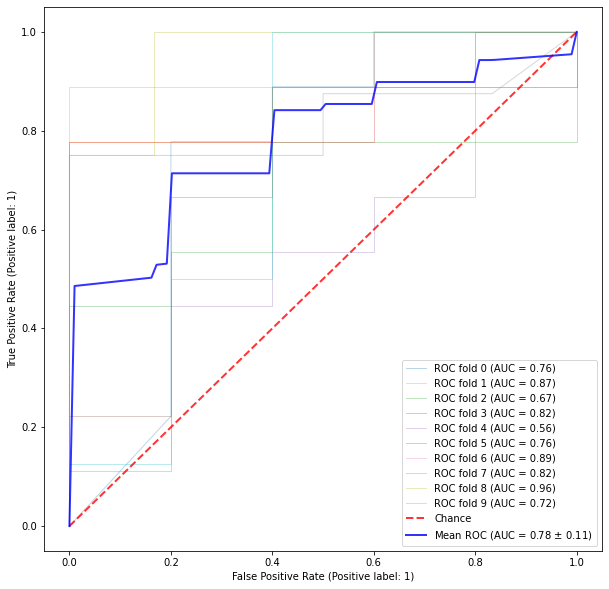

{'subsample': 0.1, 'n_estimators': 100, 'min_child_weight': 0.3, 'max_leaf_nodes': 4, 'max_depth': 7, 'max_delta_step ': 1, 'lambda ': 0.05, 'gama': 0.2, 'eta': 0.05, 'colsample_bytree ': 0.6, 'colsample_bynode ': 0.2, 'colsample_bylevel ': 0.6, 'alpha': 0.5}
{'subsample': 0.8, 'n_estimators': 50, 'min_child_weight': 0.1, 'max_leaf_nodes': 6, 'max_depth': 6, 'max_delta_step ': 2, 'lambda ': 0.5, 'gama': 0.1, 'eta': 0.2, 'colsample_bytree ': 0.5, 'colsample_bynode ': 0.5, 'colsample_bylevel ': 0.4, 'alpha': 0.1}
{'subsample': 0.1, 'n_estimators': 5, 'min_child_weight': 0.1, 'max_leaf_nodes': 9, 'max_depth': 6, 'max_delta_step ': 2, 'lambda ': 0.5, 'gama': 0.05, 'eta': 0.1, 'colsample_bytree ': 0.8, 'colsample_bynode ': 0.5, 'colsample_bylevel ': 0.8, 'alpha': 0.1}
{'subsample': 0.1, 'n_estimators': 20, 'min_child_weight': 0.5, 'max_leaf_nodes': 10, 'max_depth': 1, 'max_delta_step ': 0, 'lambda ': 0.05, 'gama': 0.2, 'eta': 0.03, 'colsample_bytree ': 0.6, 'colsample_bynode ': 0.3, 'colsam

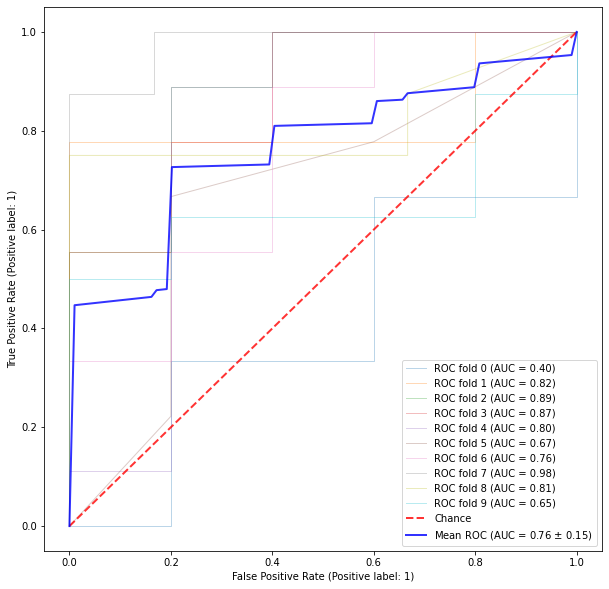

{'subsample': 0.1, 'n_estimators': 50, 'min_child_weight': 0.3, 'max_leaf_nodes': 4, 'max_depth': 6, 'max_delta_step ': 5, 'lambda ': 0.1, 'gama': 0.5, 'eta': 0.01, 'colsample_bytree ': 0.8, 'colsample_bynode ': 0.8, 'colsample_bylevel ': 0.6, 'alpha': 0.001}
{'subsample': 1, 'n_estimators': 20, 'min_child_weight': 0.1, 'max_leaf_nodes': 6, 'max_depth': 1, 'max_delta_step ': 2, 'lambda ': 0.3, 'gama': 0.1, 'eta': 0.03, 'colsample_bytree ': 0.6, 'colsample_bynode ': 0.5, 'colsample_bylevel ': 0.4, 'alpha': 0.001}
{'subsample': 0.5, 'n_estimators': 20, 'min_child_weight': 0.1, 'max_leaf_nodes': 4, 'max_depth': 10, 'max_delta_step ': 2, 'lambda ': 0.01, 'gama': 0.05, 'eta': 0.05, 'colsample_bytree ': 0.8, 'colsample_bynode ': 0.2, 'colsample_bylevel ': 0.4, 'alpha': 0.001}
{'subsample': 1, 'n_estimators': 20, 'min_child_weight': 0.1, 'max_leaf_nodes': 6, 'max_depth': 1, 'max_delta_step ': 2, 'lambda ': 0.3, 'gama': 0.1, 'eta': 0.03, 'colsample_bytree ': 0.6, 'colsample_bynode ': 0.5, 'col

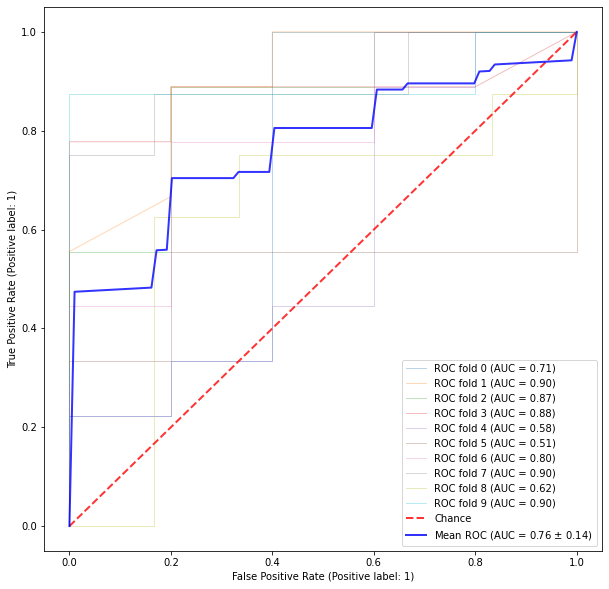

{'subsample': 1, 'n_estimators': 50, 'min_child_weight': 0.3, 'max_leaf_nodes': 6, 'max_depth': 1, 'max_delta_step ': 5, 'lambda ': 0.3, 'gama': 0.8, 'eta': 0.05, 'colsample_bytree ': 0.5, 'colsample_bynode ': 0.8, 'colsample_bylevel ': 0.8, 'alpha': 0.01}
{'subsample': 0.5, 'n_estimators': 20, 'min_child_weight': 0.5, 'max_leaf_nodes': 4, 'max_depth': 7, 'max_delta_step ': 0, 'lambda ': 0.05, 'gama': 0.8, 'eta': 0.05, 'colsample_bytree ': 0.8, 'colsample_bynode ': 0.8, 'colsample_bylevel ': 0.4, 'alpha': 0.1}
{'subsample': 1, 'n_estimators': 50, 'min_child_weight': 0.3, 'max_leaf_nodes': 6, 'max_depth': 1, 'max_delta_step ': 5, 'lambda ': 0.3, 'gama': 0.8, 'eta': 0.05, 'colsample_bytree ': 0.5, 'colsample_bynode ': 0.8, 'colsample_bylevel ': 0.8, 'alpha': 0.01}
{'subsample': 1, 'n_estimators': 300, 'min_child_weight': 0.5, 'max_leaf_nodes': 10, 'max_depth': 10, 'max_delta_step ': 1, 'lambda ': 0.1, 'gama': 0.1, 'eta': 0.01, 'colsample_bytree ': 0.5, 'colsample_bynode ': 0.8, 'colsampl

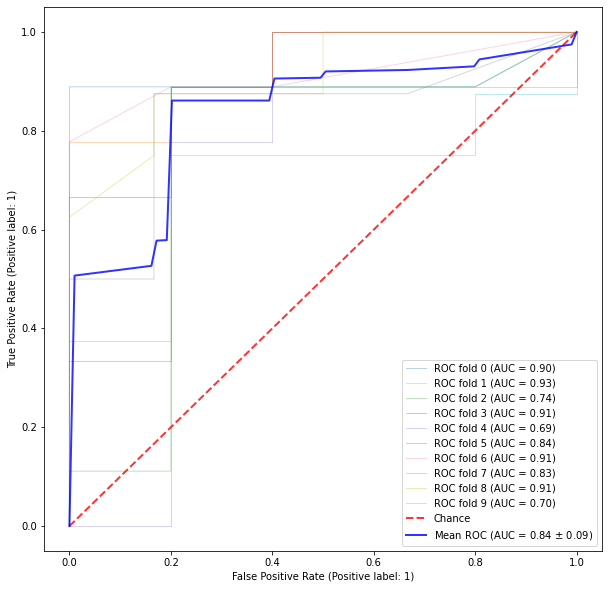

{'subsample': 0.5, 'n_estimators': 10, 'min_child_weight': 0.5, 'max_leaf_nodes': 4, 'max_depth': 6, 'max_delta_step ': 0, 'lambda ': 0.3, 'gama': 0.2, 'eta': 0.01, 'colsample_bytree ': 0.6, 'colsample_bynode ': 0.2, 'colsample_bylevel ': 0.6, 'alpha': 0.1}
{'subsample': 0.5, 'n_estimators': 100, 'min_child_weight': 0.1, 'max_leaf_nodes': 4, 'max_depth': 1, 'max_delta_step ': 5, 'lambda ': 0.5, 'gama': 0.1, 'eta': 0.03, 'colsample_bytree ': 0.6, 'colsample_bynode ': 0.8, 'colsample_bylevel ': 0.8, 'alpha': 0.01}
{'subsample': 0.8, 'n_estimators': 100, 'min_child_weight': 0.3, 'max_leaf_nodes': 9, 'max_depth': 1, 'max_delta_step ': 0, 'lambda ': 0.3, 'gama': 0.1, 'eta': 0.01, 'colsample_bytree ': 0.8, 'colsample_bynode ': 0.2, 'colsample_bylevel ': 0.4, 'alpha': 0.01}
{'subsample': 1, 'n_estimators': 100, 'min_child_weight': 0.3, 'max_leaf_nodes': 10, 'max_depth': 1, 'max_delta_step ': 5, 'lambda ': 0.5, 'gama': 0.01, 'eta': 0.05, 'colsample_bytree ': 0.6, 'colsample_bynode ': 0.3, 'col

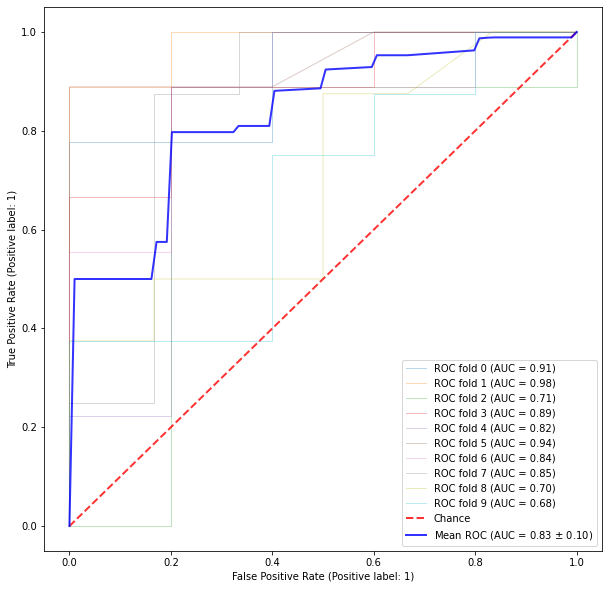

{'subsample': 0.8, 'n_estimators': 50, 'min_child_weight': 0.5, 'max_leaf_nodes': 4, 'max_depth': 1, 'max_delta_step ': 5, 'lambda ': 0.3, 'gama': 0.8, 'eta': 0.03, 'colsample_bytree ': 0.6, 'colsample_bynode ': 0.2, 'colsample_bylevel ': 0.8, 'alpha': 0.01}
{'subsample': 0.8, 'n_estimators': 50, 'min_child_weight': 0.5, 'max_leaf_nodes': 4, 'max_depth': 1, 'max_delta_step ': 5, 'lambda ': 0.3, 'gama': 0.8, 'eta': 0.03, 'colsample_bytree ': 0.6, 'colsample_bynode ': 0.2, 'colsample_bylevel ': 0.8, 'alpha': 0.01}
{'subsample': 1, 'n_estimators': 50, 'min_child_weight': 0.5, 'max_leaf_nodes': 6, 'max_depth': 1, 'max_delta_step ': 1, 'lambda ': 0.5, 'gama': 0.2, 'eta': 0.01, 'colsample_bytree ': 0.8, 'colsample_bynode ': 0.3, 'colsample_bylevel ': 0.4, 'alpha': 0.01}
{'subsample': 1, 'n_estimators': 50, 'min_child_weight': 0.5, 'max_leaf_nodes': 6, 'max_depth': 1, 'max_delta_step ': 1, 'lambda ': 0.5, 'gama': 0.2, 'eta': 0.01, 'colsample_bytree ': 0.8, 'colsample_bynode ': 0.3, 'colsample

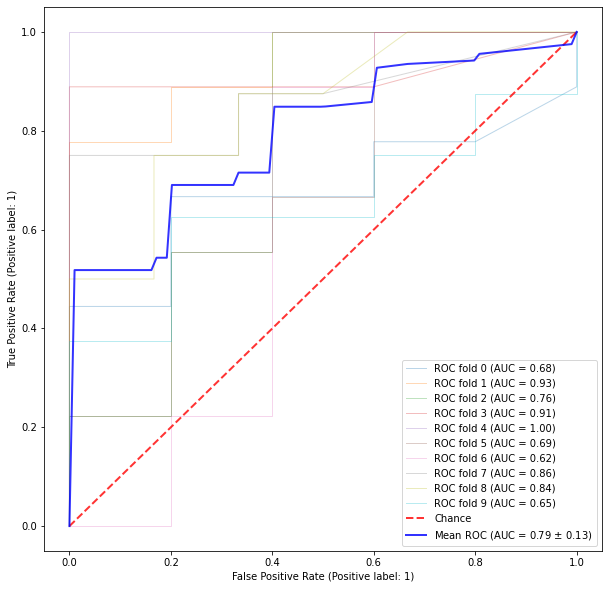

{'subsample': 0.8, 'n_estimators': 50, 'min_child_weight': 0.3, 'max_leaf_nodes': 9, 'max_depth': 6, 'max_delta_step ': 2, 'lambda ': 0.3, 'gama': 0.1, 'eta': 0.1, 'colsample_bytree ': 0.6, 'colsample_bynode ': 0.8, 'colsample_bylevel ': 0.8, 'alpha': 0.001}
{'subsample': 0.8, 'n_estimators': 50, 'min_child_weight': 0.3, 'max_leaf_nodes': 9, 'max_depth': 6, 'max_delta_step ': 2, 'lambda ': 0.3, 'gama': 0.1, 'eta': 0.1, 'colsample_bytree ': 0.6, 'colsample_bynode ': 0.8, 'colsample_bylevel ': 0.8, 'alpha': 0.001}
{'subsample': 1, 'n_estimators': 300, 'min_child_weight': 0.5, 'max_leaf_nodes': 9, 'max_depth': 5, 'max_delta_step ': 5, 'lambda ': 0.5, 'gama': 0.8, 'eta': 0.01, 'colsample_bytree ': 0.5, 'colsample_bynode ': 0.8, 'colsample_bylevel ': 0.4, 'alpha': 0.5}
{'subsample': 0.5, 'n_estimators': 300, 'min_child_weight': 0.3, 'max_leaf_nodes': 10, 'max_depth': 5, 'max_delta_step ': 5, 'lambda ': 0.3, 'gama': 0.8, 'eta': 0.1, 'colsample_bytree ': 0.6, 'colsample_bynode ': 0.2, 'colsam

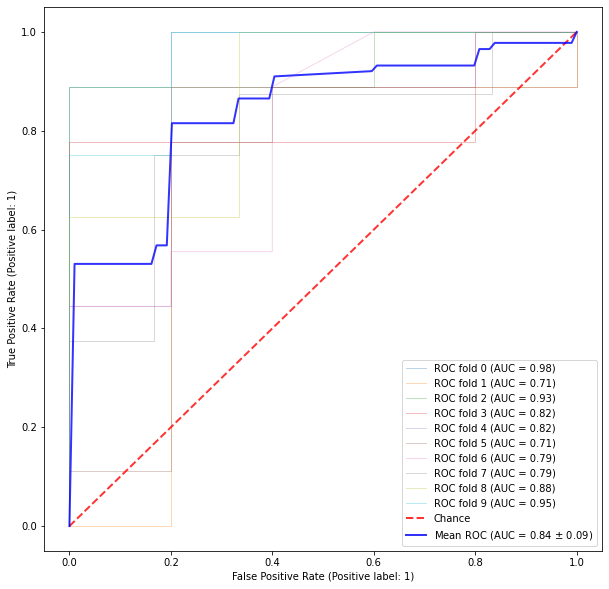

FPR
array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
       0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
       0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
       0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
       0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
       0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
       0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
       0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
       0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
       0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
       0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
       0.65656566, 0.66666667, 0.67676768, 0.68686869, 0.6969697 ,
       0.70707071, 0.71717172, 0.72727273, 0.73737374, 0.7

In [ ]:
XGBoost_train_I = Final_Model_Train(XGBoost_Train_Nested_wo_sampling, x_I.values, y_I.values, ML_model='XGBoost', Tuning_param= Xgboost_tuning_parameter, 
                                    outer_loop= outer_loop, inner_loop= inner_loop, random_search_number= 30, random_seed= random_seed,
                                    iteration_num = iteration_num, imp=True)

{'num_leaves': 10, 'min_data_in_leaf': 5, 'max_depth': 18}
{'num_leaves': 50, 'min_data_in_leaf': 10, 'max_depth': 5}
{'num_leaves': 10, 'min_data_in_leaf': 5, 'max_depth': 18}
{'num_leaves': 100, 'min_data_in_leaf': 15, 'max_depth': 18}
{'num_leaves': 100, 'min_data_in_leaf': 15, 'max_depth': 18}
{'num_leaves': 10, 'min_data_in_leaf': 7, 'max_depth': 18}
{'num_leaves': 15, 'min_data_in_leaf': 25, 'max_depth': 6}
{'num_leaves': 2, 'min_data_in_leaf': 10, 'max_depth': 3}
{'num_leaves': 10, 'min_data_in_leaf': 7, 'max_depth': 18}
{'num_leaves': 10, 'min_data_in_leaf': 7, 'max_depth': 18}


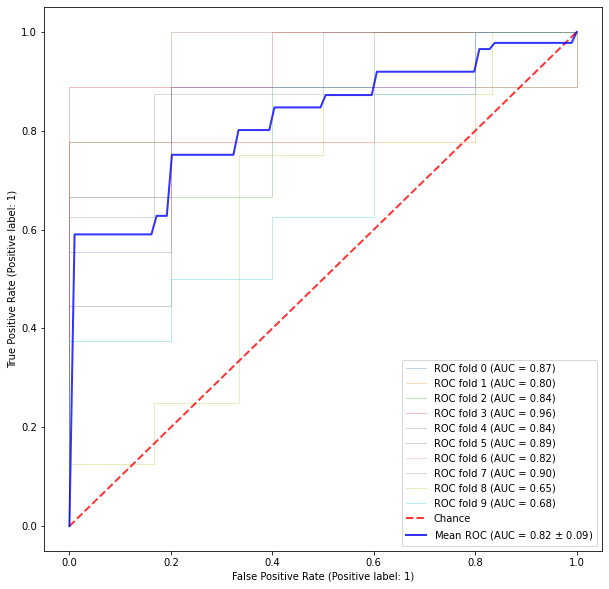

[[117.2 109.2 124.1 108.7 154.2   4.4   2.1   1.7   1.4  11.2   4.    5.3
    2.    9.3   2.4  12.6   4.7]]
{'num_leaves': 18, 'min_data_in_leaf': 25, 'max_depth': 1}
{'num_leaves': 18, 'min_data_in_leaf': 5, 'max_depth': 14}
{'num_leaves': 10, 'min_data_in_leaf': 10, 'max_depth': 3}
{'num_leaves': 10, 'min_data_in_leaf': 10, 'max_depth': 3}
{'num_leaves': 100, 'min_data_in_leaf': 10, 'max_depth': 14}
{'num_leaves': 4, 'min_data_in_leaf': 5, 'max_depth': 1}
{'num_leaves': 4, 'min_data_in_leaf': 5, 'max_depth': 1}
{'num_leaves': 10, 'min_data_in_leaf': 10, 'max_depth': 7}
{'num_leaves': 50, 'min_data_in_leaf': 15, 'max_depth': 1}
{'num_leaves': 18, 'min_data_in_leaf': 25, 'max_depth': 6}


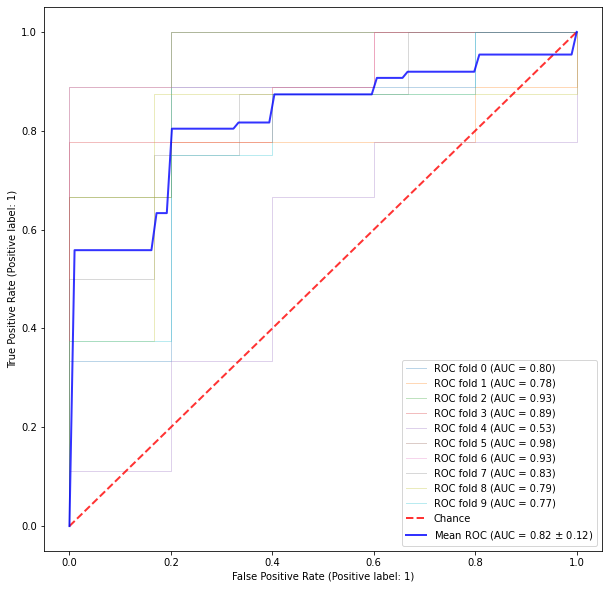

[[ 85.8  79.9  88.9  78.8 113.1   5.8   1.5   1.5   0.   11.2   2.4   4.1
    1.5   8.    1.7   8.4   2.5]]
{'num_leaves': 2, 'min_data_in_leaf': 5, 'max_depth': 18}
{'num_leaves': 15, 'min_data_in_leaf': 15, 'max_depth': 7}
{'num_leaves': 15, 'min_data_in_leaf': 15, 'max_depth': 7}
{'num_leaves': 2, 'min_data_in_leaf': 10, 'max_depth': 14}
{'num_leaves': 50, 'min_data_in_leaf': 25, 'max_depth': 6}
{'num_leaves': 20, 'min_data_in_leaf': 10, 'max_depth': 18}
{'num_leaves': 50, 'min_data_in_leaf': 25, 'max_depth': 6}
{'num_leaves': 50, 'min_data_in_leaf': 25, 'max_depth': 6}
{'num_leaves': 4, 'min_data_in_leaf': 20, 'max_depth': 18}
{'num_leaves': 2, 'min_data_in_leaf': 10, 'max_depth': 14}


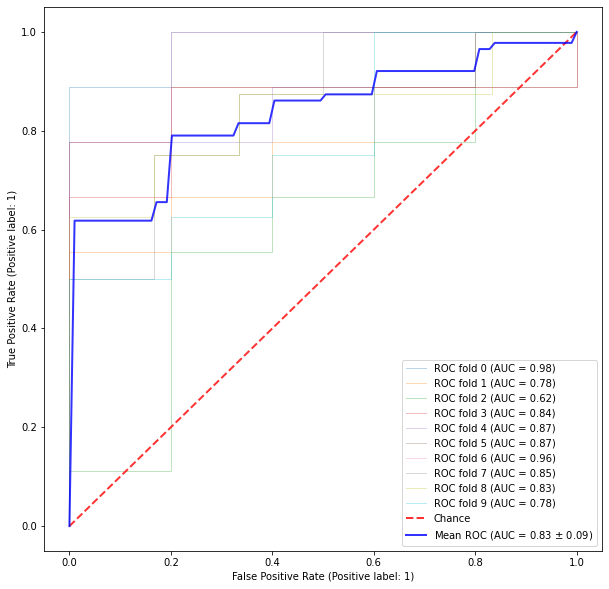

[[60.1 59.5 64.2 58.1 80.3  2.4  1.3  0.8  0.1  6.2  1.9  0.8  0.3  6.7
   2.1  2.   0.9]]
{'num_leaves': 4, 'min_data_in_leaf': 5, 'max_depth': 18}
{'num_leaves': 4, 'min_data_in_leaf': 20, 'max_depth': 7}
{'num_leaves': 20, 'min_data_in_leaf': 25, 'max_depth': 7}
{'num_leaves': 10, 'min_data_in_leaf': 10, 'max_depth': 1}
{'num_leaves': 50, 'min_data_in_leaf': 10, 'max_depth': 16}
{'num_leaves': 10, 'min_data_in_leaf': 10, 'max_depth': 1}
{'num_leaves': 50, 'min_data_in_leaf': 10, 'max_depth': 16}
{'num_leaves': 10, 'min_data_in_leaf': 15, 'max_depth': 7}
{'num_leaves': 10, 'min_data_in_leaf': 10, 'max_depth': 1}
{'num_leaves': 100, 'min_data_in_leaf': 20, 'max_depth': 1}


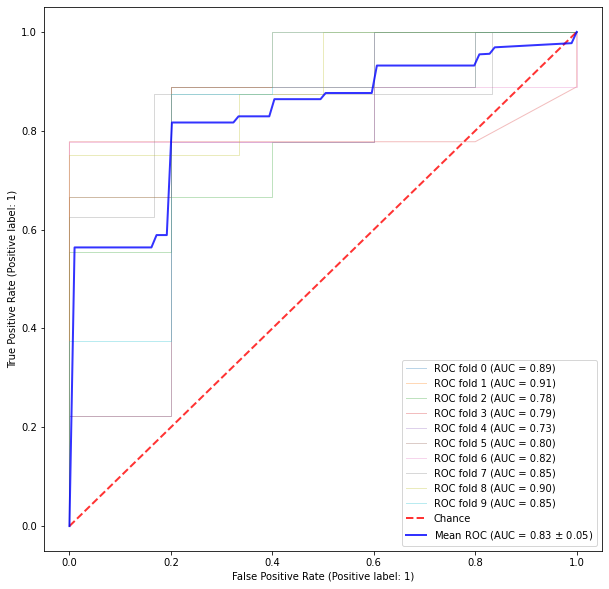

[[64.3 60.9 63.2 60.5 81.8  2.8  2.1  1.1  0.3  6.9  2.   2.9  0.6  4.4
   1.6  2.4  0.6]]
{'num_leaves': 15, 'min_data_in_leaf': 2, 'max_depth': 1}
{'num_leaves': 4, 'min_data_in_leaf': 15, 'max_depth': 16}
{'num_leaves': 4, 'min_data_in_leaf': 20, 'max_depth': 16}
{'num_leaves': 2, 'min_data_in_leaf': 15, 'max_depth': 18}
{'num_leaves': 2, 'min_data_in_leaf': 15, 'max_depth': 18}
{'num_leaves': 10, 'min_data_in_leaf': 7, 'max_depth': 5}
{'num_leaves': 15, 'min_data_in_leaf': 2, 'max_depth': 1}
{'num_leaves': 4, 'min_data_in_leaf': 20, 'max_depth': 16}
{'num_leaves': 4, 'min_data_in_leaf': 20, 'max_depth': 16}
{'num_leaves': 2, 'min_data_in_leaf': 7, 'max_depth': 16}


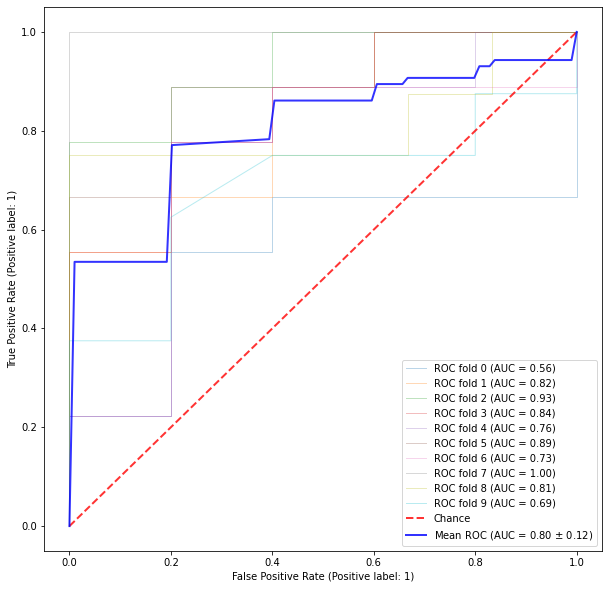

[[45.8 44.  45.7 37.7 61.   1.9  1.4  0.5  0.5  5.4  1.1  2.1  0.3  5.
   0.2  3.   0.4]]
{'num_leaves': 15, 'min_data_in_leaf': 2, 'max_depth': 5}
{'num_leaves': 2, 'min_data_in_leaf': 15, 'max_depth': 1}
{'num_leaves': 100, 'min_data_in_leaf': 7, 'max_depth': 14}
{'num_leaves': 100, 'min_data_in_leaf': 20, 'max_depth': 3}
{'num_leaves': 2, 'min_data_in_leaf': 15, 'max_depth': 1}
{'num_leaves': 2, 'min_data_in_leaf': 7, 'max_depth': 16}
{'num_leaves': 100, 'min_data_in_leaf': 5, 'max_depth': 14}
{'num_leaves': 2, 'min_data_in_leaf': 7, 'max_depth': 16}
{'num_leaves': 100, 'min_data_in_leaf': 20, 'max_depth': 3}
{'num_leaves': 2, 'min_data_in_leaf': 7, 'max_depth': 16}


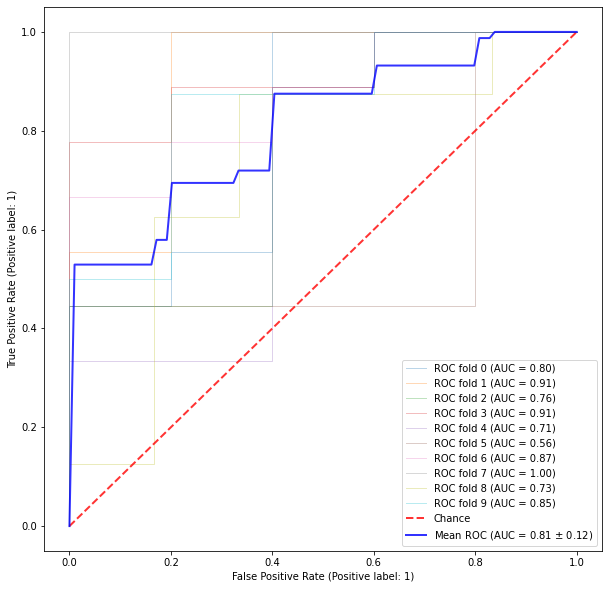

[[108.6 101.9 105.6  88.7 120.1   7.7   1.7   3.4   0.4  10.    1.1   4.3
    0.9   9.4   1.    7.9   0.9]]
{'num_leaves': 18, 'min_data_in_leaf': 7, 'max_depth': 5}
{'num_leaves': 10, 'min_data_in_leaf': 2, 'max_depth': 12}
{'num_leaves': 5, 'min_data_in_leaf': 15, 'max_depth': 16}
{'num_leaves': 2, 'min_data_in_leaf': 7, 'max_depth': 7}
{'num_leaves': 15, 'min_data_in_leaf': 5, 'max_depth': 5}
{'num_leaves': 5, 'min_data_in_leaf': 20, 'max_depth': 14}
{'num_leaves': 5, 'min_data_in_leaf': 15, 'max_depth': 16}
{'num_leaves': 5, 'min_data_in_leaf': 20, 'max_depth': 14}
{'num_leaves': 2, 'min_data_in_leaf': 7, 'max_depth': 7}
{'num_leaves': 100, 'min_data_in_leaf': 7, 'max_depth': 6}


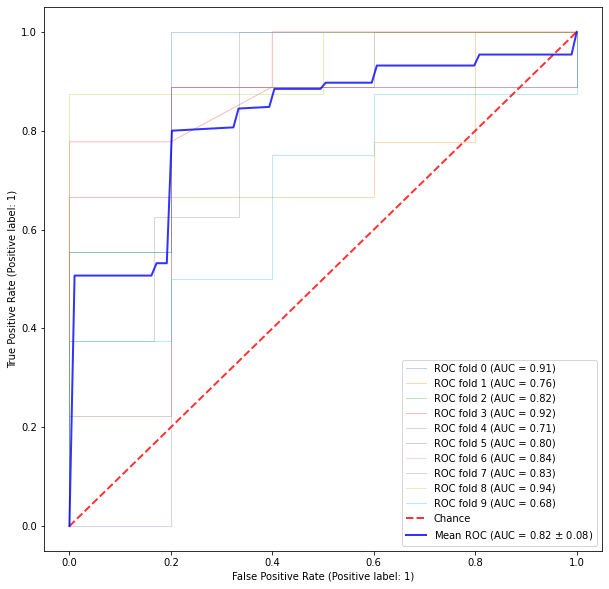

[[110.4  98.1 105.5  94.7 131.4   4.2   1.1   1.5   0.3  11.6   1.7   6.8
    0.9  10.    1.3  11.3   1.5]]
{'num_leaves': 2, 'min_data_in_leaf': 2, 'max_depth': 3}
{'num_leaves': 2, 'min_data_in_leaf': 2, 'max_depth': 3}
{'num_leaves': 20, 'min_data_in_leaf': 10, 'max_depth': 16}
{'num_leaves': 4, 'min_data_in_leaf': 7, 'max_depth': 1}
{'num_leaves': 4, 'min_data_in_leaf': 7, 'max_depth': 1}
{'num_leaves': 10, 'min_data_in_leaf': 20, 'max_depth': 16}
{'num_leaves': 10, 'min_data_in_leaf': 20, 'max_depth': 16}
{'num_leaves': 4, 'min_data_in_leaf': 7, 'max_depth': 18}
{'num_leaves': 4, 'min_data_in_leaf': 7, 'max_depth': 1}
{'num_leaves': 2, 'min_data_in_leaf': 2, 'max_depth': 3}


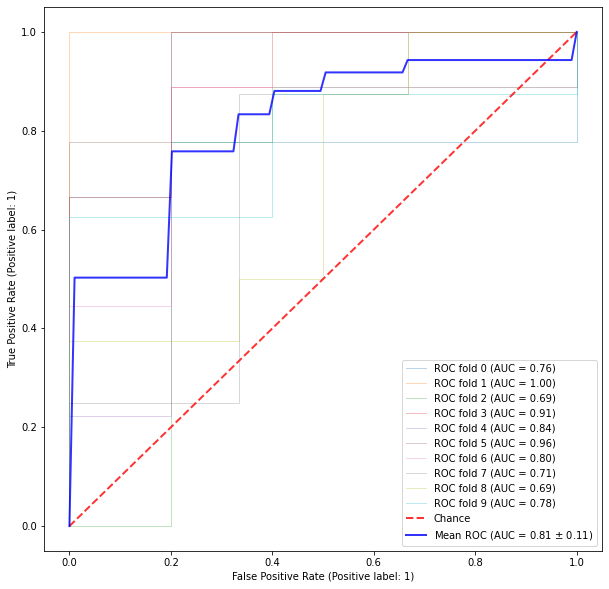

[[51.1 40.7 45.8 40.  58.   0.8  0.9  0.3  0.3  4.2  0.9  0.6  0.4  3.9
   0.9  1.5  0.6]]
{'num_leaves': 2, 'min_data_in_leaf': 10, 'max_depth': 7}
{'num_leaves': 2, 'min_data_in_leaf': 7, 'max_depth': 16}
{'num_leaves': 100, 'min_data_in_leaf': 25, 'max_depth': 6}
{'num_leaves': 2, 'min_data_in_leaf': 7, 'max_depth': 16}
{'num_leaves': 20, 'min_data_in_leaf': 20, 'max_depth': 5}
{'num_leaves': 20, 'min_data_in_leaf': 10, 'max_depth': 7}
{'num_leaves': 20, 'min_data_in_leaf': 20, 'max_depth': 5}
{'num_leaves': 2, 'min_data_in_leaf': 10, 'max_depth': 7}
{'num_leaves': 20, 'min_data_in_leaf': 20, 'max_depth': 5}
{'num_leaves': 20, 'min_data_in_leaf': 5, 'max_depth': 6}


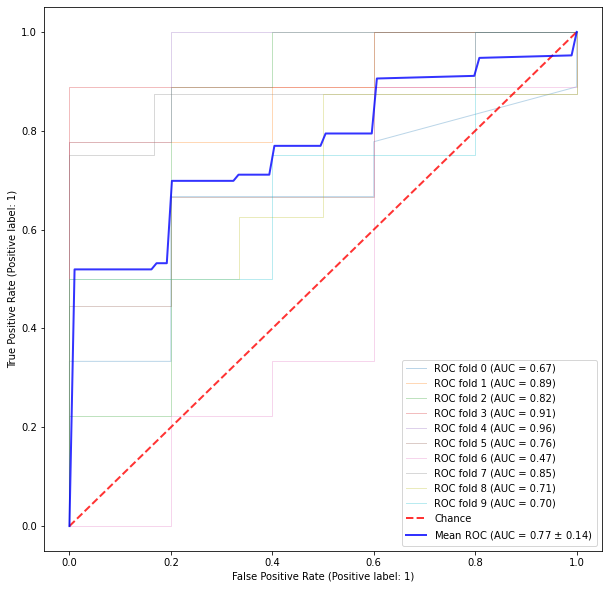

[[73.8 68.6 74.4 63.9 89.5  6.2  1.2  1.7  0.3  9.1  1.8  3.   0.6  4.7
   1.5  4.8  1.3]]
{'num_leaves': 100, 'min_data_in_leaf': 10, 'max_depth': 16}
{'num_leaves': 10, 'min_data_in_leaf': 7, 'max_depth': 18}
{'num_leaves': 4, 'min_data_in_leaf': 10, 'max_depth': 12}
{'num_leaves': 4, 'min_data_in_leaf': 10, 'max_depth': 12}
{'num_leaves': 18, 'min_data_in_leaf': 20, 'max_depth': 7}
{'num_leaves': 4, 'min_data_in_leaf': 10, 'max_depth': 12}
{'num_leaves': 10, 'min_data_in_leaf': 5, 'max_depth': 1}
{'num_leaves': 10, 'min_data_in_leaf': 7, 'max_depth': 3}
{'num_leaves': 10, 'min_data_in_leaf': 5, 'max_depth': 5}
{'num_leaves': 4, 'min_data_in_leaf': 10, 'max_depth': 12}


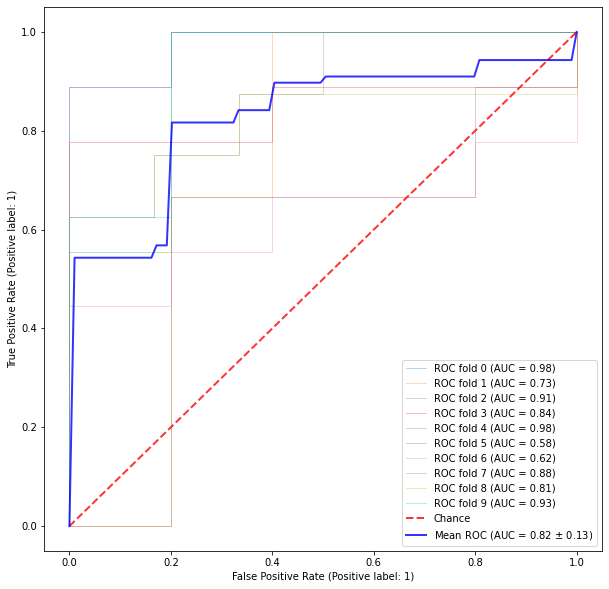

[[8.380e+01 8.030e+01 8.670e+01 8.030e+01 1.112e+02 4.000e+00 1.400e+00
  2.700e+00 1.000e-01 8.000e+00 2.000e+00 2.900e+00 1.100e+00 5.300e+00
  1.300e+00 7.400e+00 2.000e+00]]
FPR
array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
       0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
       0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
       0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
       0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
       0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
       0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
       0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
       0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
       0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
       0.60606

In [ ]:
LGBM_train_I = Final_Model_Train(Train_Nested_wo_sampling, x_I, y_I, ML_model='LGBM', Tuning_param= LGBM_tuning, 
                                 outer_loop= outer_loop, inner_loop= inner_loop, random_search_number= 20, random_seed= random_seed,
                                 iteration_num = iteration_num, imp=True)

In [ ]:
GBDT_train_I = Final_Model_Train(Train_Nested_wo_sampling, x_I, y_I, ML_model='GBDT', Tuning_param= GBDT_tuning_parameter, 
                                 outer_loop= outer_loop, inner_loop= inner_loop, random_search_number= 10, random_seed= random_seed,
                                 iteration_num = iteration_num, imp=True)

#Experiment III (Without bPEP, bET, Ratio):

In [ ]:
x_with_all, y = data.drop(['death', 'cvdeath', 'followperiod', 'pepet100', 'pepet425'], axis=1), data['death']


x_new = x_with_all
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
to_encode = x_new[["sex", "dm", "ht", "lipidemia", "PCI", "STEMI"]]
no_encode = x_new[["age", "lowabi", "bmi"]]

Encoded_onehot = OneHotEncoder().fit(to_encode).transform(to_encode).toarray()
Encoded_onehot = pd.DataFrame(Encoded_onehot)
X = pd.concat([no_encode, Encoded_onehot], ignore_index=True, axis=1)
X_scaled = pd.DataFrame(StandardScaler().fit(X).transform(X))
x_III = X_scaled
y_III = y1


from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV, LeaveOneOut, LeavePOut
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import matplotlib.pyplot as plt

{'n_estimators': 20, 'learning_rate': 0.05}
{'n_estimators': 20, 'learning_rate': 0.05}
{'n_estimators': 20, 'learning_rate': 0.05}
{'n_estimators': 20, 'learning_rate': 0.05}
{'n_estimators': 20, 'learning_rate': 0.05}
{'n_estimators': 20, 'learning_rate': 0.05}
{'n_estimators': 20, 'learning_rate': 0.05}
{'n_estimators': 20, 'learning_rate': 0.05}
{'n_estimators': 20, 'learning_rate': 0.05}
{'n_estimators': 20, 'learning_rate': 0.05}


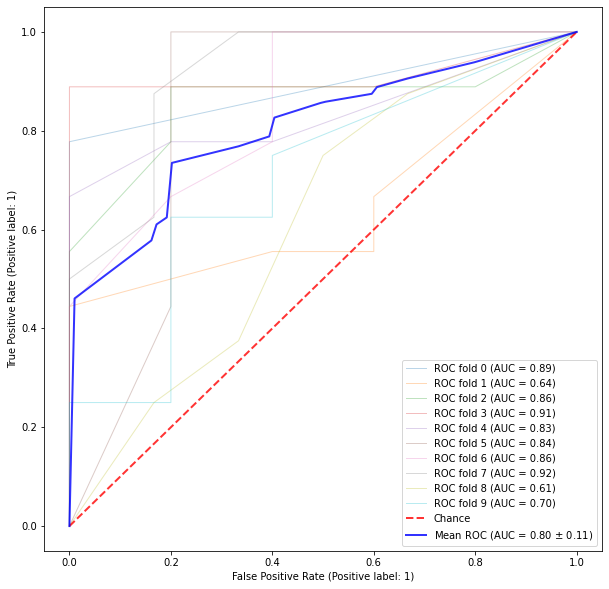

[[0.725 0.215 0.06  0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.   ]]
{'n_estimators': 100, 'learning_rate': 0.1}
{'n_estimators': 100, 'learning_rate': 0.1}
{'n_estimators': 100, 'learning_rate': 0.1}
{'n_estimators': 100, 'learning_rate': 0.1}
{'n_estimators': 20, 'learning_rate': 0.01}
{'n_estimators': 100, 'learning_rate': 0.1}
{'n_estimators': 100, 'learning_rate': 0.1}
{'n_estimators': 100, 'learning_rate': 0.1}
{'n_estimators': 100, 'learning_rate': 0.1}
{'n_estimators': 20, 'learning_rate': 0.001}


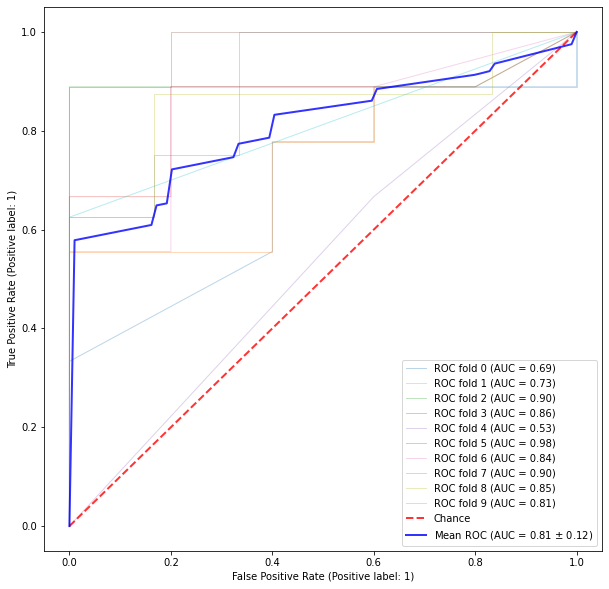

[[0.508 0.272 0.135 0.017 0.027 0.    0.    0.02  0.019 0.    0.    0.
  0.    0.    0.002]]
{'n_estimators': 1000, 'learning_rate': 0.001}
{'n_estimators': 20, 'learning_rate': 0.05}
{'n_estimators': 400, 'learning_rate': 0.01}
{'n_estimators': 400, 'learning_rate': 0.01}
{'n_estimators': 400, 'learning_rate': 0.01}
{'n_estimators': 20, 'learning_rate': 0.05}
{'n_estimators': 400, 'learning_rate': 0.01}
{'n_estimators': 400, 'learning_rate': 0.01}
{'n_estimators': 400, 'learning_rate': 0.01}
{'n_estimators': 400, 'learning_rate': 0.01}


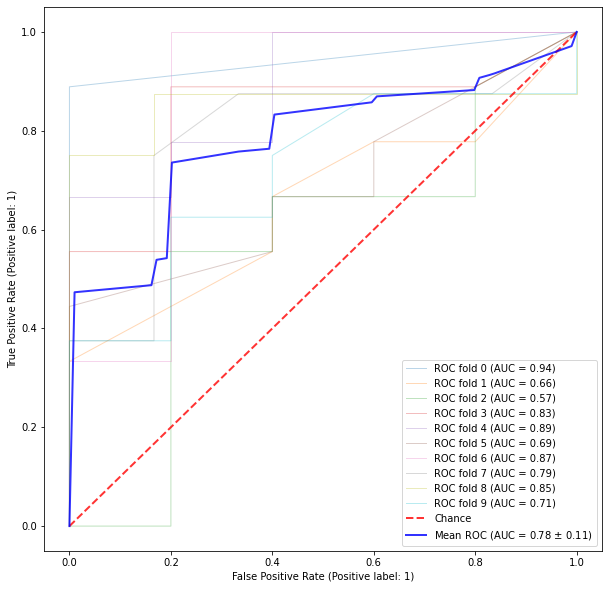

[[5.7455e-01 3.0645e-01 7.8000e-02 4.2500e-03 5.7500e-03 0.0000e+00
  0.0000e+00 1.4000e-02 1.4500e-02 0.0000e+00 0.0000e+00 1.5000e-03
  7.5000e-04 0.0000e+00 2.5000e-04]]
{'n_estimators': 20, 'learning_rate': 0.01}
{'n_estimators': 100, 'learning_rate': 0.1}
{'n_estimators': 20, 'learning_rate': 0.01}
{'n_estimators': 100, 'learning_rate': 0.1}
{'n_estimators': 1000, 'learning_rate': 0.1}
{'n_estimators': 100, 'learning_rate': 0.1}
{'n_estimators': 100, 'learning_rate': 0.1}
{'n_estimators': 20, 'learning_rate': 0.01}
{'n_estimators': 100, 'learning_rate': 0.1}
{'n_estimators': 100, 'learning_rate': 0.1}


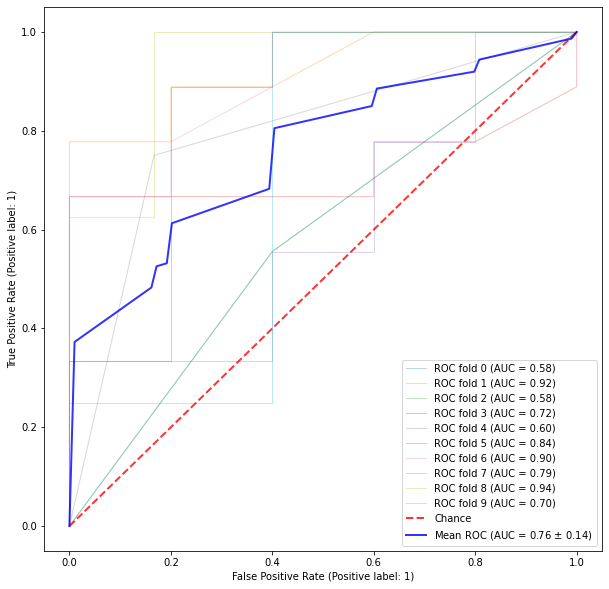

[[5.591e-01 2.298e-01 1.305e-01 2.150e-02 1.960e-02 0.000e+00 3.000e-04
  2.450e-02 1.130e-02 0.000e+00 0.000e+00 1.500e-03 1.900e-03 0.000e+00
  0.000e+00]]
{'n_estimators': 400, 'learning_rate': 0.01}
{'n_estimators': 500, 'learning_rate': 0.05}
{'n_estimators': 400, 'learning_rate': 0.01}
{'n_estimators': 400, 'learning_rate': 0.01}
{'n_estimators': 400, 'learning_rate': 0.01}
{'n_estimators': 400, 'learning_rate': 0.01}
{'n_estimators': 400, 'learning_rate': 0.01}
{'n_estimators': 400, 'learning_rate': 0.01}
{'n_estimators': 400, 'learning_rate': 0.01}
{'n_estimators': 400, 'learning_rate': 0.01}


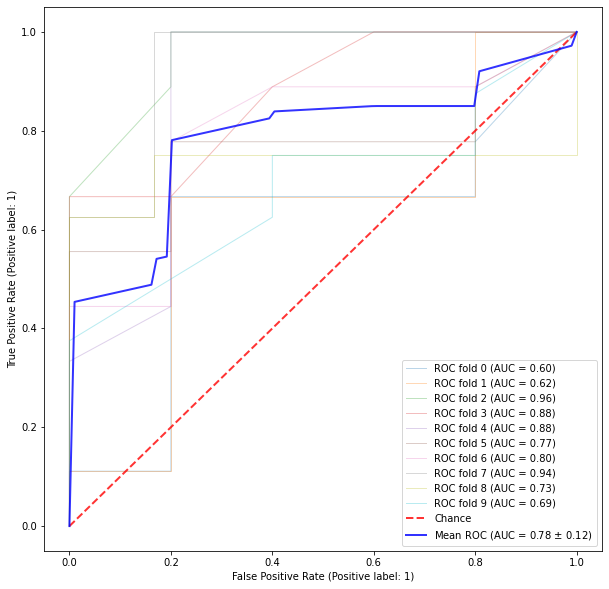

[[0.4925  0.34685 0.09795 0.0081  0.01015 0.      0.      0.01665 0.0181
  0.      0.      0.001   0.0012  0.004   0.0035 ]]
{'n_estimators': 100, 'learning_rate': 0.01}
{'n_estimators': 100, 'learning_rate': 0.01}
{'n_estimators': 100, 'learning_rate': 0.01}
{'n_estimators': 100, 'learning_rate': 0.01}
{'n_estimators': 20, 'learning_rate': 0.5}
{'n_estimators': 100, 'learning_rate': 0.01}
{'n_estimators': 100, 'learning_rate': 0.01}
{'n_estimators': 100, 'learning_rate': 0.01}
{'n_estimators': 100, 'learning_rate': 0.01}
{'n_estimators': 20, 'learning_rate': 0.5}


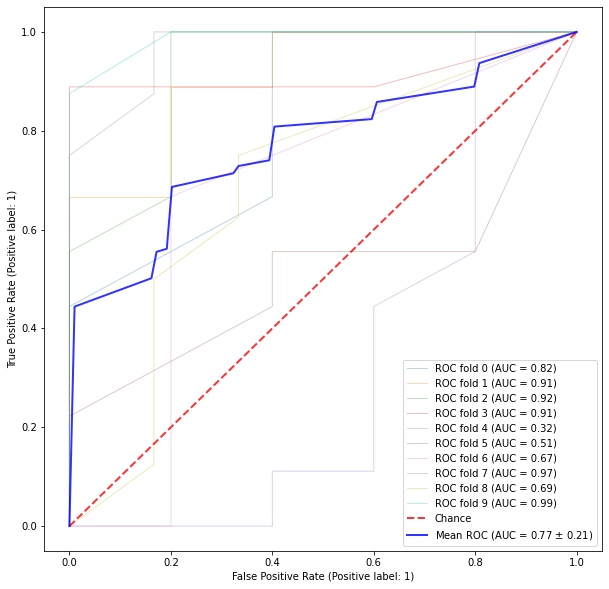

[[0.681 0.214 0.085 0.005 0.01  0.    0.    0.005 0.    0.    0.    0.
  0.    0.    0.   ]]
{'n_estimators': 1000, 'learning_rate': 0.01}
{'n_estimators': 1000, 'learning_rate': 0.01}
{'n_estimators': 400, 'learning_rate': 0.001}
{'n_estimators': 1000, 'learning_rate': 0.01}
{'n_estimators': 400, 'learning_rate': 0.001}
{'n_estimators': 1000, 'learning_rate': 0.01}
{'n_estimators': 400, 'learning_rate': 0.001}
{'n_estimators': 1000, 'learning_rate': 0.01}
{'n_estimators': 400, 'learning_rate': 0.001}
{'n_estimators': 1000, 'learning_rate': 0.01}


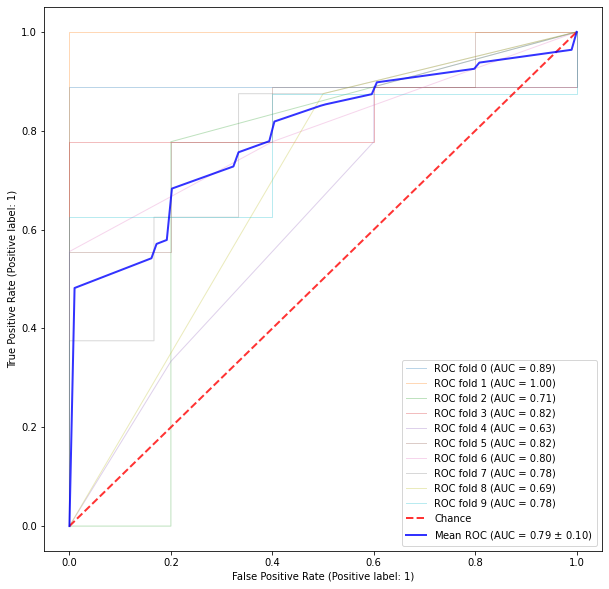

[[5.9905e-01 2.4065e-01 9.3700e-02 1.9700e-02 1.6800e-02 0.0000e+00
  0.0000e+00 1.5900e-02 1.3500e-02 0.0000e+00 0.0000e+00 4.0000e-04
  3.0000e-04 0.0000e+00 0.0000e+00]]
{'n_estimators': 400, 'learning_rate': 0.01}
{'n_estimators': 300, 'learning_rate': 0.01}
{'n_estimators': 300, 'learning_rate': 0.01}
{'n_estimators': 400, 'learning_rate': 0.01}
{'n_estimators': 400, 'learning_rate': 0.01}
{'n_estimators': 300, 'learning_rate': 0.01}
{'n_estimators': 300, 'learning_rate': 0.01}
{'n_estimators': 300, 'learning_rate': 0.01}
{'n_estimators': 400, 'learning_rate': 0.01}
{'n_estimators': 400, 'learning_rate': 0.01}


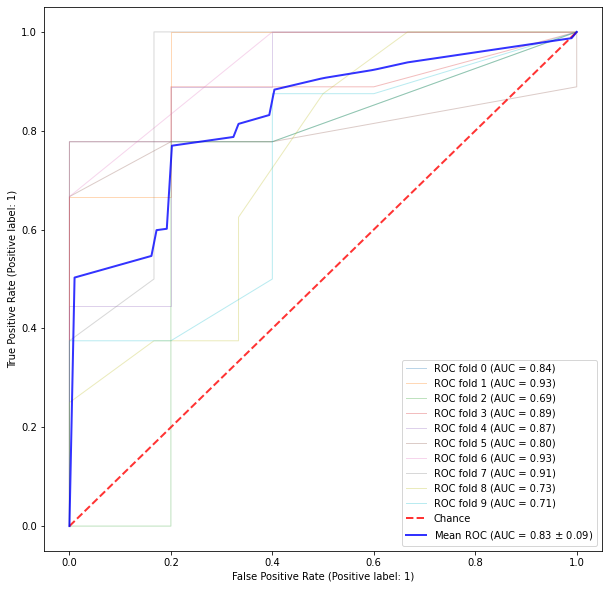

[[0.554      0.35491667 0.06208333 0.00075    0.00075    0.
  0.         0.01583333 0.01166667 0.         0.         0.
  0.         0.         0.        ]]
{'n_estimators': 50, 'learning_rate': 0.01}
{'n_estimators': 50, 'learning_rate': 0.01}
{'n_estimators': 50, 'learning_rate': 0.01}
{'n_estimators': 50, 'learning_rate': 0.01}
{'n_estimators': 50, 'learning_rate': 0.01}
{'n_estimators': 50, 'learning_rate': 0.01}
{'n_estimators': 50, 'learning_rate': 0.01}
{'n_estimators': 50, 'learning_rate': 0.01}
{'n_estimators': 50, 'learning_rate': 0.01}
{'n_estimators': 50, 'learning_rate': 0.5}


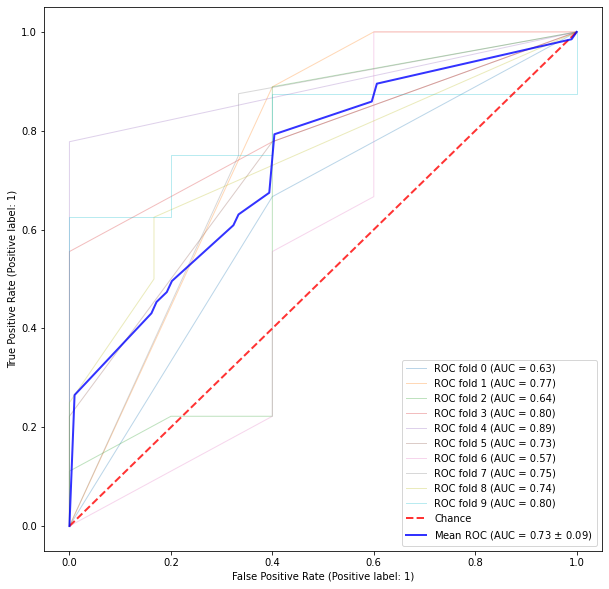

[[0.878 0.07  0.038 0.004 0.002 0.    0.    0.006 0.    0.    0.    0.
  0.002 0.    0.   ]]
{'n_estimators': 300, 'learning_rate': 0.01}
{'n_estimators': 300, 'learning_rate': 0.01}
{'n_estimators': 300, 'learning_rate': 0.01}
{'n_estimators': 300, 'learning_rate': 0.01}
{'n_estimators': 300, 'learning_rate': 0.01}
{'n_estimators': 1000, 'learning_rate': 0.001}
{'n_estimators': 300, 'learning_rate': 0.01}
{'n_estimators': 300, 'learning_rate': 0.01}
{'n_estimators': 300, 'learning_rate': 0.01}
{'n_estimators': 300, 'learning_rate': 0.01}


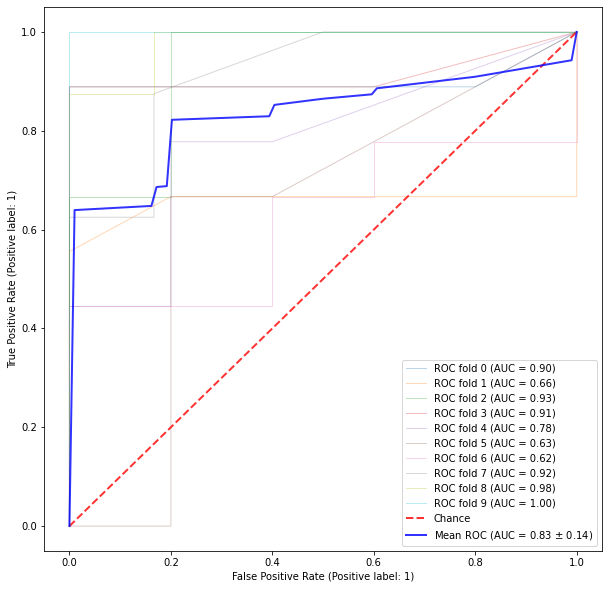

[[0.59153333 0.3084     0.06906667 0.00066667 0.00133333 0.
  0.         0.008      0.01133333 0.         0.         0.
  0.         0.00433333 0.00533333]]
FPR
array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
       0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
       0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
       0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
       0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
       0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
       0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
       0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
       0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
       0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
       0.60606061, 0.61616162, 0.62

In [ ]:
AdaBoost_train_III = Final_Model_Train(Train_Nested_wo_sampling, x_III, y_III, ML_model='AdaBoost', Tuning_param= AdaBoost_tuning, 
                                       outer_loop= outer_loop, inner_loop= inner_loop, random_search_number= 4, random_seed= random_seed,
                                       iteration_num = iteration_num, imp=True)


{'n_estimators': 150, 'min_samples_split': 14, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'max_depth': 3, 'criterion': 'gini', 'bootstrap': True}
{'n_estimators': 150, 'min_samples_split': 14, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'max_depth': 3, 'criterion': 'gini', 'bootstrap': True}
{'n_estimators': 150, 'min_samples_split': 14, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'max_depth': 3, 'criterion': 'gini', 'bootstrap': True}
{'n_estimators': 200, 'min_samples_split': 8, 'min_samples_leaf': 12, 'max_features': 'auto', 'max_depth': 5, 'criterion': 'gini', 'bootstrap': False}
{'n_estimators': 200, 'min_samples_split': 8, 'min_samples_leaf': 12, 'max_features': 'auto', 'max_depth': 5, 'criterion': 'gini', 'bootstrap': False}
{'n_estimators': 150, 'min_samples_split': 14, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'max_depth': 3, 'criterion': 'gini', 'bootstrap': True}
{'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 12, 'max_features': 'sqrt', 'ma

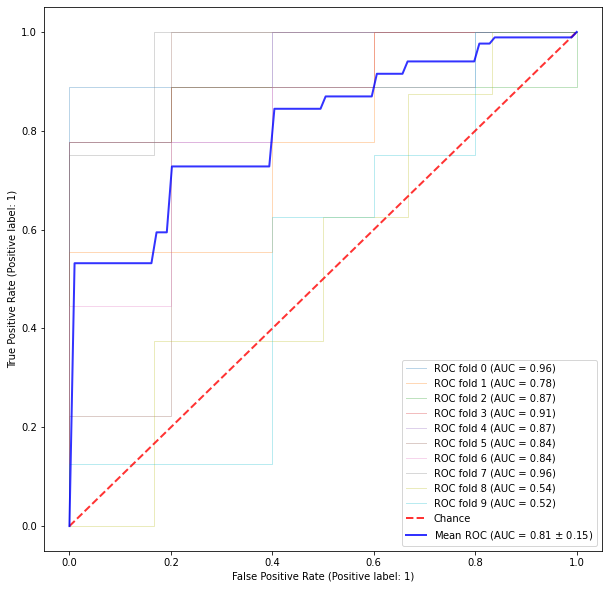

[[0.3877848  0.20761974 0.1729687  0.02708131 0.01990617 0.00775942
  0.0071397  0.04480651 0.05248154 0.01483967 0.0122565  0.01243699
  0.01471724 0.00773221 0.01046951]]
{'n_estimators': 250, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 'auto', 'max_depth': 7, 'criterion': 'entropy', 'bootstrap': True}
{'n_estimators': 250, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 'auto', 'max_depth': 7, 'criterion': 'entropy', 'bootstrap': True}
{'n_estimators': 250, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 'auto', 'max_depth': 7, 'criterion': 'entropy', 'bootstrap': True}
{'n_estimators': 250, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 'auto', 'max_depth': 7, 'criterion': 'entropy', 'bootstrap': True}
{'n_estimators': 250, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 7, 'criterion': 'entropy', 'bootstrap': False}
{'n_estimators': 350, 'min_samples_split': 12, 'min_samples_leaf':

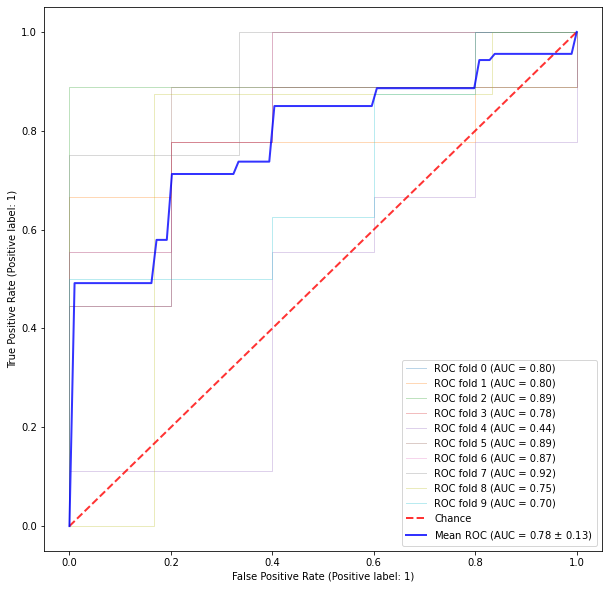

[[0.36560483 0.20374304 0.20937797 0.01844977 0.01599017 0.00890088
  0.00866468 0.04165132 0.04543747 0.0137062  0.01523648 0.01284117
  0.01335522 0.01339967 0.01364113]]
{'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 12, 'max_features': 'auto', 'max_depth': 14, 'criterion': 'entropy', 'bootstrap': True}
{'n_estimators': 50, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 3, 'criterion': 'gini', 'bootstrap': False}
{'n_estimators': 50, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 3, 'criterion': 'gini', 'bootstrap': False}
{'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 12, 'max_features': 'auto', 'max_depth': 14, 'criterion': 'entropy', 'bootstrap': True}
{'n_estimators': 250, 'min_samples_split': 6, 'min_samples_leaf': 6, 'max_features': 'auto', 'max_depth': 3, 'criterion': 'entropy', 'bootstrap': False}
{'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_lea

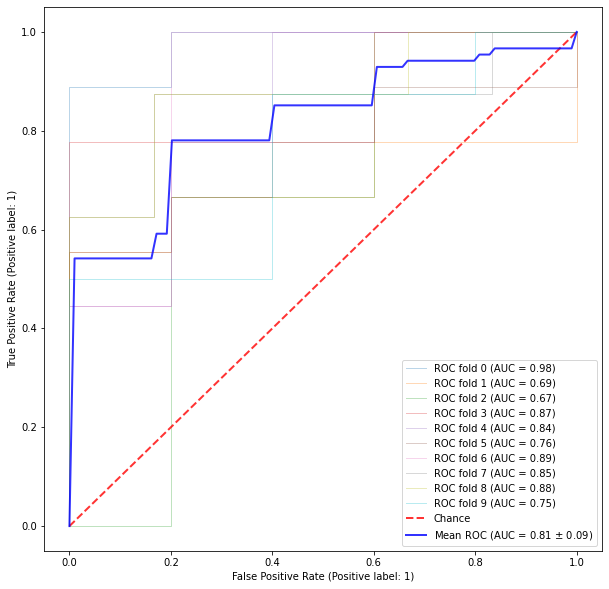

[[0.35701347 0.20443442 0.20908506 0.01976763 0.0191293  0.00820012
  0.0071291  0.05392225 0.05685585 0.01319732 0.01028559 0.01197282
  0.01376716 0.00832798 0.00691192]]
{'n_estimators': 1000, 'min_samples_split': 14, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'max_depth': 3, 'criterion': 'entropy', 'bootstrap': True}
{'n_estimators': 1000, 'min_samples_split': 14, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'max_depth': 3, 'criterion': 'entropy', 'bootstrap': True}
{'n_estimators': 1000, 'min_samples_split': 14, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'max_depth': 3, 'criterion': 'entropy', 'bootstrap': True}
{'n_estimators': 1000, 'min_samples_split': 14, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'max_depth': 3, 'criterion': 'entropy', 'bootstrap': True}
{'n_estimators': 200, 'min_samples_split': 4, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'max_depth': 5, 'criterion': 'gini', 'bootstrap': False}
{'n_estimators': 1000, 'min_samples_split': 14, 'min_samples_

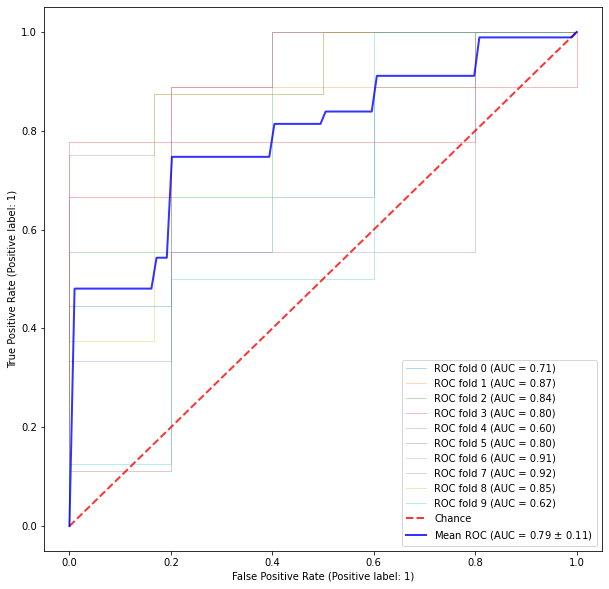

[[0.35250359 0.21014594 0.213656   0.02217923 0.01782857 0.00770014
  0.00768679 0.0515993  0.04623497 0.01326819 0.01330875 0.01313567
  0.01342728 0.00888433 0.00844125]]
{'n_estimators': 250, 'min_samples_split': 14, 'min_samples_leaf': 6, 'max_features': 'auto', 'max_depth': 12, 'criterion': 'entropy', 'bootstrap': True}
{'n_estimators': 250, 'min_samples_split': 14, 'min_samples_leaf': 6, 'max_features': 'auto', 'max_depth': 12, 'criterion': 'entropy', 'bootstrap': True}
{'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'max_depth': 7, 'criterion': 'entropy', 'bootstrap': True}
{'n_estimators': 250, 'min_samples_split': 14, 'min_samples_leaf': 6, 'max_features': 'auto', 'max_depth': 12, 'criterion': 'entropy', 'bootstrap': True}
{'n_estimators': 250, 'min_samples_split': 14, 'min_samples_leaf': 6, 'max_features': 'auto', 'max_depth': 12, 'criterion': 'entropy', 'bootstrap': True}
{'n_estimators': 250, 'min_samples_split': 14, 'min_samples

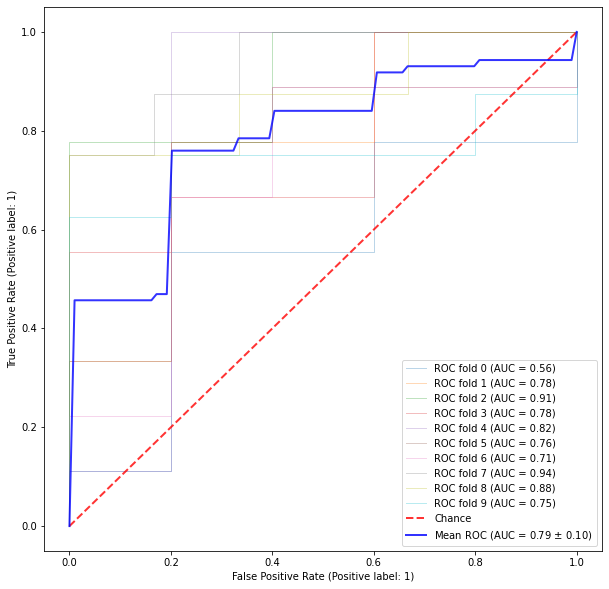

[[0.34971305 0.20847012 0.21798876 0.01936266 0.01748581 0.01038853
  0.01041315 0.03424828 0.04540219 0.01633516 0.01548437 0.01369448
  0.0164332  0.0118624  0.01271784]]
{'n_estimators': 150, 'min_samples_split': 12, 'min_samples_leaf': 3, 'max_features': 'auto', 'max_depth': 1, 'criterion': 'gini', 'bootstrap': True}
{'n_estimators': 250, 'min_samples_split': 12, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'max_depth': 18, 'criterion': 'entropy', 'bootstrap': False}
{'n_estimators': 300, 'min_samples_split': 12, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 6, 'criterion': 'entropy', 'bootstrap': False}
{'n_estimators': 400, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'auto', 'max_depth': 1, 'criterion': 'gini', 'bootstrap': True}
{'n_estimators': 250, 'min_samples_split': 12, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'max_depth': 18, 'criterion': 'entropy', 'bootstrap': False}
{'n_estimators': 300, 'min_samples_split': 12, 'min_samples_leaf

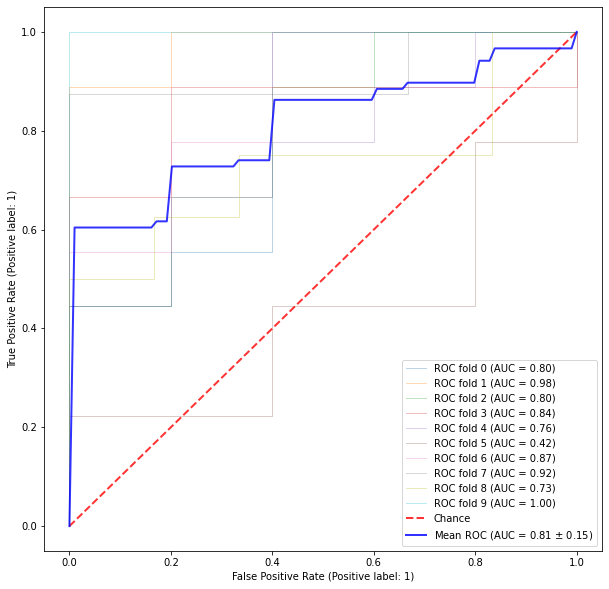

[[0.3128922  0.19299112 0.20080137 0.03443355 0.02926732 0.01114372
  0.01058473 0.0581649  0.05043321 0.01596535 0.02031477 0.01514145
  0.01599088 0.01532202 0.0165534 ]]
{'n_estimators': 350, 'min_samples_split': 8, 'min_samples_leaf': 7, 'max_features': 'auto', 'max_depth': 7, 'criterion': 'gini', 'bootstrap': True}
{'n_estimators': 300, 'min_samples_split': 6, 'min_samples_leaf': 7, 'max_features': 'auto', 'max_depth': 6, 'criterion': 'entropy', 'bootstrap': True}
{'n_estimators': 20, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'max_depth': 12, 'criterion': 'entropy', 'bootstrap': False}
{'n_estimators': 350, 'min_samples_split': 8, 'min_samples_leaf': 7, 'max_features': 'auto', 'max_depth': 7, 'criterion': 'gini', 'bootstrap': True}
{'n_estimators': 300, 'min_samples_split': 6, 'min_samples_leaf': 7, 'max_features': 'auto', 'max_depth': 6, 'criterion': 'entropy', 'bootstrap': True}
{'n_estimators': 300, 'min_samples_split': 6, 'min_samples_leaf': 7, 'm

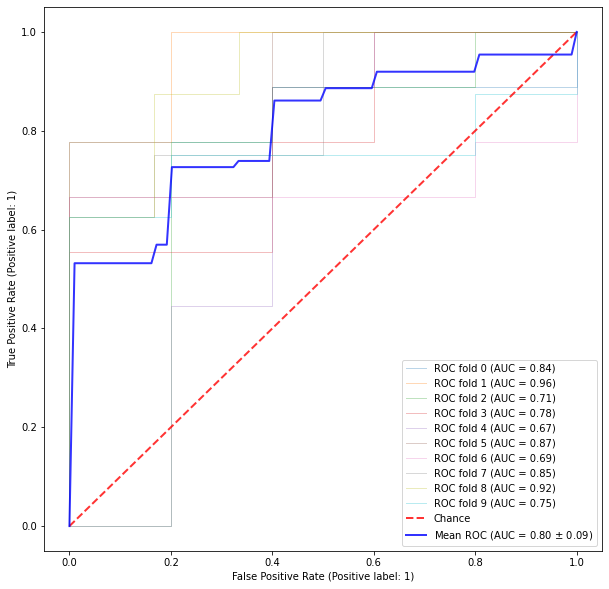

[[0.36111257 0.21422868 0.21295879 0.01889825 0.01607531 0.0067388
  0.00893334 0.04445015 0.04900475 0.01249317 0.0113979  0.01176507
  0.01358694 0.00838577 0.0099705 ]]
{'n_estimators': 20, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'auto', 'max_depth': 12, 'criterion': 'entropy', 'bootstrap': False}
{'n_estimators': 400, 'min_samples_split': 12, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 18, 'criterion': 'entropy', 'bootstrap': False}
{'n_estimators': 400, 'min_samples_split': 12, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 18, 'criterion': 'entropy', 'bootstrap': False}
{'n_estimators': 500, 'min_samples_split': 12, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'max_depth': 5, 'criterion': 'gini', 'bootstrap': False}
{'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 14, 'criterion': 'entropy', 'bootstrap': True}
{'n_estimators': 1000, 'min_samples_split': 10, 'min_sample

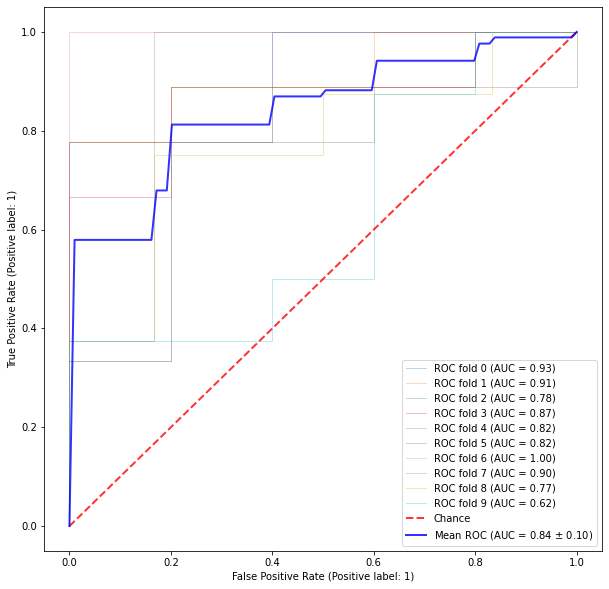

[[0.34939678 0.22123813 0.22544766 0.01602715 0.01410475 0.01106093
  0.01084293 0.031754   0.03642736 0.01323576 0.01408199 0.01389973
  0.0131611  0.01546551 0.01385621]]
{'n_estimators': 250, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 14, 'criterion': 'entropy', 'bootstrap': False}
{'n_estimators': 400, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 'auto', 'max_depth': 3, 'criterion': 'gini', 'bootstrap': False}
{'n_estimators': 250, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 14, 'criterion': 'entropy', 'bootstrap': False}
{'n_estimators': 400, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 'auto', 'max_depth': 3, 'criterion': 'gini', 'bootstrap': False}
{'n_estimators': 250, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 14, 'criterion': 'entropy', 'bootstrap': False}
{'n_estimators': 250, 'min_samples_split': 10, 'min_samples_le

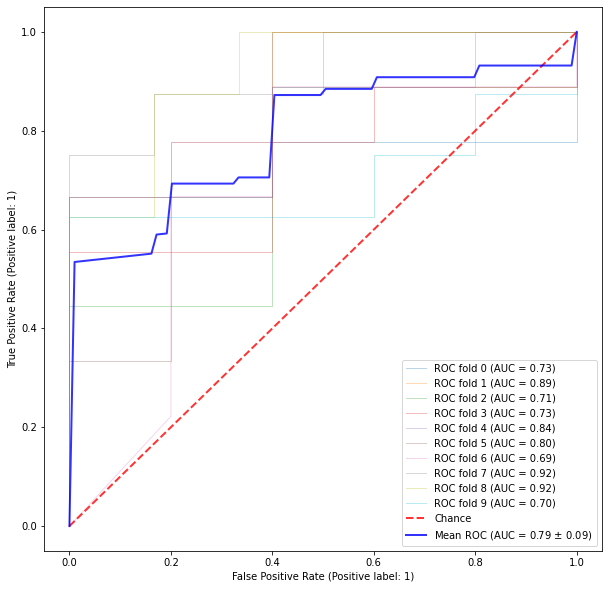

[[0.34497162 0.20565618 0.21056372 0.01909477 0.01265314 0.01046096
  0.0078671  0.05246985 0.05279478 0.02138832 0.01685683 0.01040569
  0.00990758 0.01235755 0.01255192]]
{'n_estimators': 250, 'min_samples_split': 10, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'max_depth': 16, 'criterion': 'gini', 'bootstrap': True}
{'n_estimators': 250, 'min_samples_split': 10, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'max_depth': 16, 'criterion': 'gini', 'bootstrap': True}
{'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'max_depth': 7, 'criterion': 'gini', 'bootstrap': True}
{'n_estimators': 250, 'min_samples_split': 10, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'max_depth': 16, 'criterion': 'gini', 'bootstrap': True}
{'n_estimators': 250, 'min_samples_split': 10, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'max_depth': 16, 'criterion': 'gini', 'bootstrap': True}
{'n_estimators': 250, 'min_samples_split': 10, 'min_samples_leaf': 7, 'ma

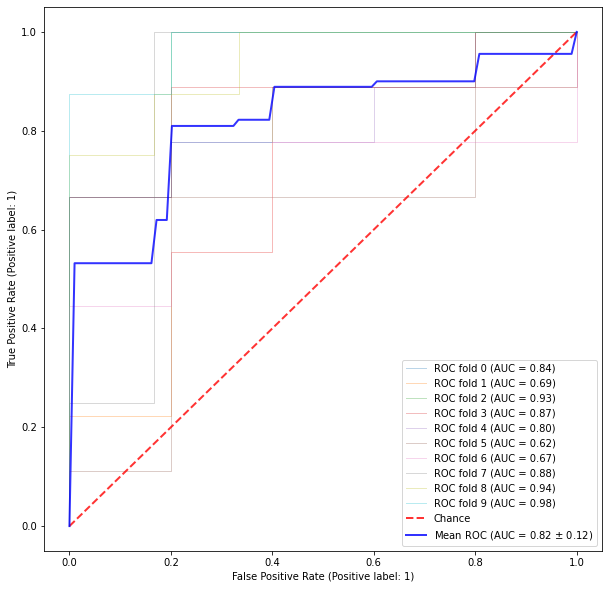

[[0.37086437 0.18569916 0.21082179 0.01714304 0.01849686 0.00988966
  0.0110332  0.05067378 0.04405039 0.01802694 0.01478932 0.01092126
  0.01558953 0.01058409 0.01141661]]
FPR
array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
       0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
       0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
       0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
       0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
       0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
       0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
       0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
       0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
       0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
       0.60606061, 

In [ ]:
RF_train_III = Final_Model_Train(Train_Nested_wo_sampling, x_III, y_III, ML_model='RF', Tuning_param= RF_tuning_parameter, 
                                 outer_loop= outer_loop, inner_loop= inner_loop, random_search_number= 5, random_seed= random_seed,
                                 iteration_num = iteration_num, imp=True)


{'n_estimators': 25, 'min_samples_split': 4, 'min_samples_leaf': 6, 'max_features': 'auto', 'max_depth': 7, 'learning_rate': 0.05}
{'n_estimators': 25, 'min_samples_split': 4, 'min_samples_leaf': 6, 'max_features': 'auto', 'max_depth': 7, 'learning_rate': 0.05}
{'n_estimators': 45, 'min_samples_split': 4, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'max_depth': 5, 'learning_rate': 0.01}
{'n_estimators': 30, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 7, 'learning_rate': 0.05}
{'n_estimators': 45, 'min_samples_split': 4, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'max_depth': 5, 'learning_rate': 0.01}
{'n_estimators': 40, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 1, 'learning_rate': 0.0001}
{'n_estimators': 30, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 7, 'learning_rate': 0.05}
{'n_estimators': 40, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features

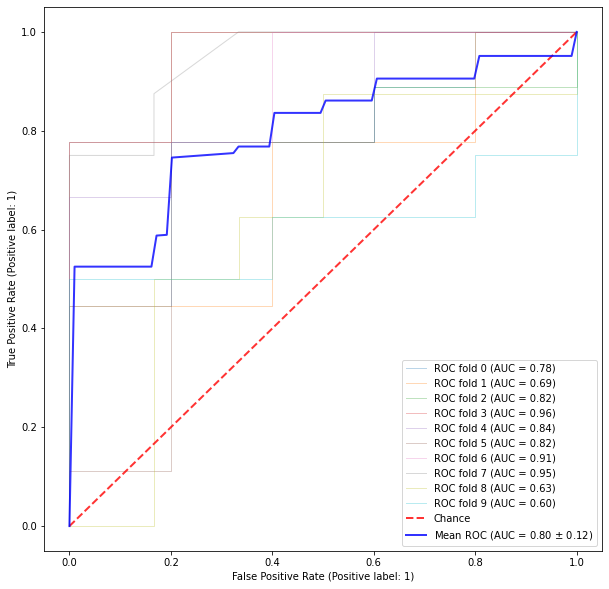

[[0.47436274 0.1991249  0.20430133 0.00958275 0.00702266 0.00506368
  0.00421506 0.02902151 0.01748959 0.00550967 0.00506651 0.00687774
  0.00816591 0.01157882 0.01261713]]
{'n_estimators': 45, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'auto', 'max_depth': 1, 'learning_rate': 0.1}
{'n_estimators': 45, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 5, 'learning_rate': 0.05}
{'n_estimators': 25, 'min_samples_split': 8, 'min_samples_leaf': 6, 'max_features': 'auto', 'max_depth': 1, 'learning_rate': 0.1}
{'n_estimators': 25, 'min_samples_split': 8, 'min_samples_leaf': 6, 'max_features': 'auto', 'max_depth': 1, 'learning_rate': 0.1}
{'n_estimators': 25, 'min_samples_split': 8, 'min_samples_leaf': 6, 'max_features': 'auto', 'max_depth': 1, 'learning_rate': 0.1}
{'n_estimators': 45, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'auto', 'max_depth': 1, 'learning_rate': 0.1}
{'n_estimators': 45, 'min_samples_split': 6, 

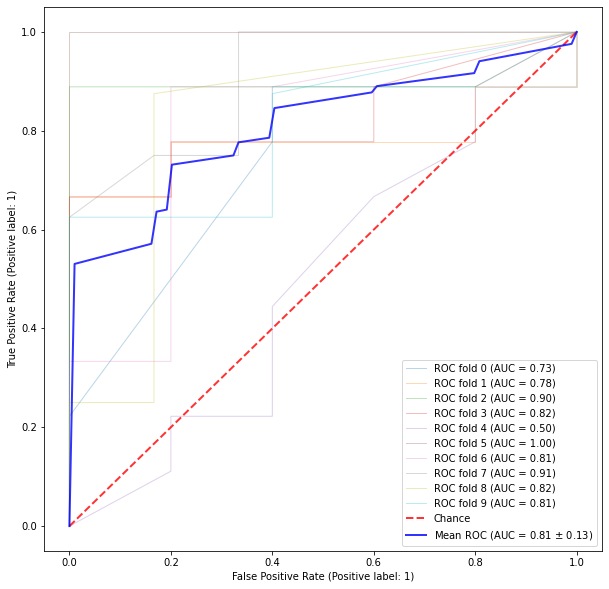

[[6.66809334e-01 1.67055296e-01 1.45498932e-01 1.57983612e-03
  1.18232005e-03 5.79165231e-04 1.34486495e-03 3.93397798e-03
  3.28628013e-03 1.43700723e-03 1.78514718e-03 1.33566927e-03
  1.49713113e-03 1.20798155e-03 1.46705790e-03]]
{'n_estimators': 45, 'min_samples_split': 6, 'min_samples_leaf': 6, 'max_features': 'auto', 'max_depth': 7, 'learning_rate': 0.01}
{'n_estimators': 25, 'min_samples_split': 8, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'max_depth': 7, 'learning_rate': 0.1}
{'n_estimators': 35, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 5, 'learning_rate': 1}
{'n_estimators': 25, 'min_samples_split': 8, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'max_depth': 7, 'learning_rate': 0.1}
{'n_estimators': 20, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 5, 'learning_rate': 0.05}
{'n_estimators': 20, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 5, 'learni

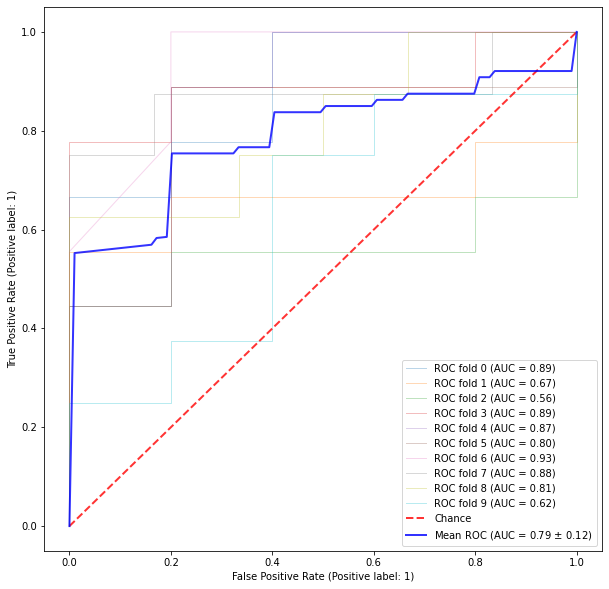

[[0.38845429 0.22449358 0.24091107 0.00677328 0.00938558 0.00853893
  0.00784011 0.03445955 0.02501942 0.00610958 0.00600581 0.01162995
  0.00868386 0.00947616 0.01221883]]
{'n_estimators': 20, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 3, 'learning_rate': 0.05}
{'n_estimators': 20, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 3, 'learning_rate': 0.05}
{'n_estimators': 20, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 3, 'learning_rate': 0.05}
{'n_estimators': 20, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 3, 'learning_rate': 0.05}
{'n_estimators': 20, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 3, 'learning_rate': 0.05}
{'n_estimators': 20, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 3, 'learning_rate': 0.05}
{'n_estimators': 30, 'min_samples_split':

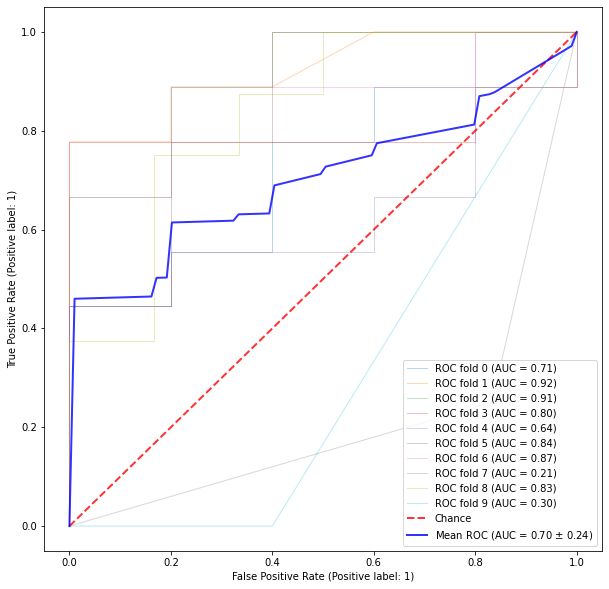

[[0.53658266 0.14411835 0.14915344 0.01342498 0.01148612 0.00592508
  0.00589506 0.03463836 0.03257103 0.0082796  0.01255381 0.00826257
  0.0063044  0.01873498 0.01206955]]
{'n_estimators': 40, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 3, 'learning_rate': 0.1}
{'n_estimators': 45, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 5, 'learning_rate': 0.1}
{'n_estimators': 40, 'min_samples_split': 6, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'max_depth': 6, 'learning_rate': 0.01}
{'n_estimators': 40, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 3, 'learning_rate': 0.1}
{'n_estimators': 40, 'min_samples_split': 6, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'max_depth': 6, 'learning_rate': 0.01}
{'n_estimators': 40, 'min_samples_split': 6, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'max_depth': 6, 'learning_rate': 0.01}
{'n_estimators': 40, 'min_samples_split': 6,

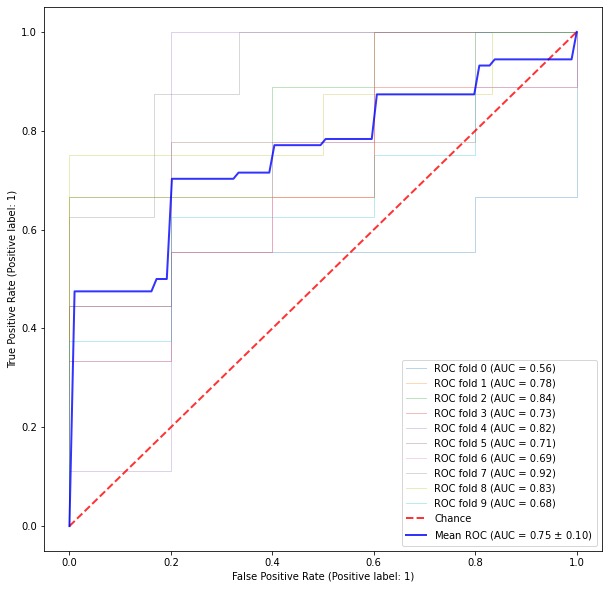

[[0.37504745 0.21660376 0.22192509 0.01807671 0.01072358 0.0105522
  0.00784999 0.04070997 0.02775263 0.01593536 0.00654281 0.01205567
  0.01011638 0.01122061 0.0148878 ]]
{'n_estimators': 30, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_features': 'auto', 'max_depth': 7, 'learning_rate': 0.01}
{'n_estimators': 40, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'auto', 'max_depth': 1, 'learning_rate': 0.05}
{'n_estimators': 40, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'auto', 'max_depth': 1, 'learning_rate': 0.05}
{'n_estimators': 40, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'auto', 'max_depth': 1, 'learning_rate': 0.05}
{'n_estimators': 40, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 6, 'learning_rate': 0.05}
{'n_estimators': 40, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'auto', 'max_depth': 1, 'learning_rate': 0.05}
{'n_estimators': 40, 'min_samples_split': 

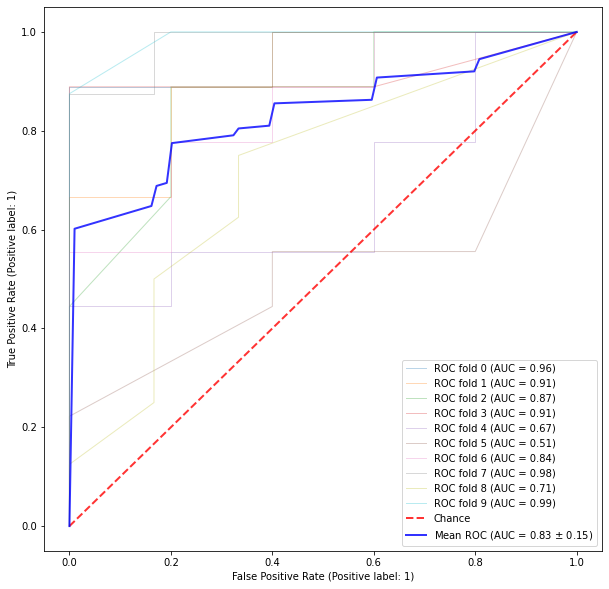

[[0.66160743 0.16092764 0.13939639 0.00398337 0.00185382 0.00211483
  0.00378858 0.00542864 0.00484717 0.00215001 0.00267377 0.00239406
  0.00339271 0.00304707 0.00239454]]
{'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'max_depth': 7, 'learning_rate': 0.01}
{'n_estimators': 40, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 7, 'learning_rate': 0.001}
{'n_estimators': 25, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 6, 'learning_rate': 2}
{'n_estimators': 30, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 7, 'learning_rate': 0.5}
{'n_estimators': 40, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 7, 'learning_rate': 0.001}
{'n_estimators': 40, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 7, 'learning_rate': 0.001}
{'n_estimators': 50, 'min_samples_split': 

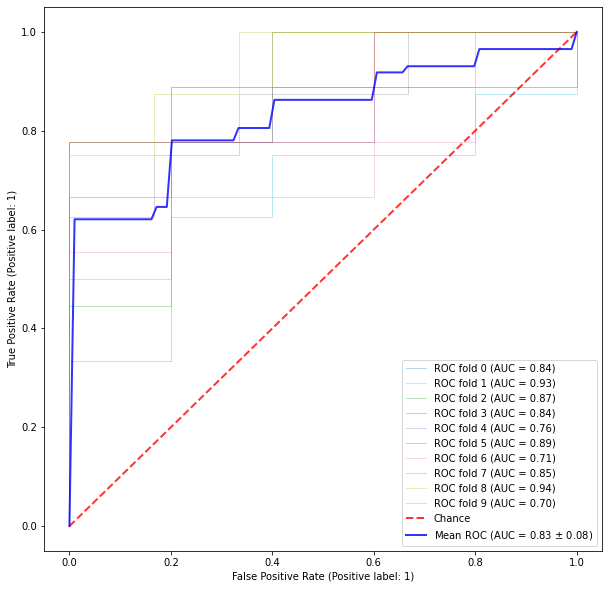

[[0.39456032 0.17966289 0.25707568 0.01816255 0.01136992 0.00807048
  0.00726509 0.03648656 0.02024093 0.01064838 0.01103109 0.01101945
  0.01326446 0.01064335 0.01049886]]
{'n_estimators': 20, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 1, 'learning_rate': 0.1}
{'n_estimators': 20, 'min_samples_split': 6, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'max_depth': 5, 'learning_rate': 0.05}
{'n_estimators': 20, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 1, 'learning_rate': 0.1}
{'n_estimators': 20, 'min_samples_split': 6, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'max_depth': 5, 'learning_rate': 0.05}
{'n_estimators': 20, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 1, 'learning_rate': 0.1}
{'n_estimators': 20, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 1, 'learning_rate': 0.1}
{'n_estimators': 25, 'min_samples_split': 10,

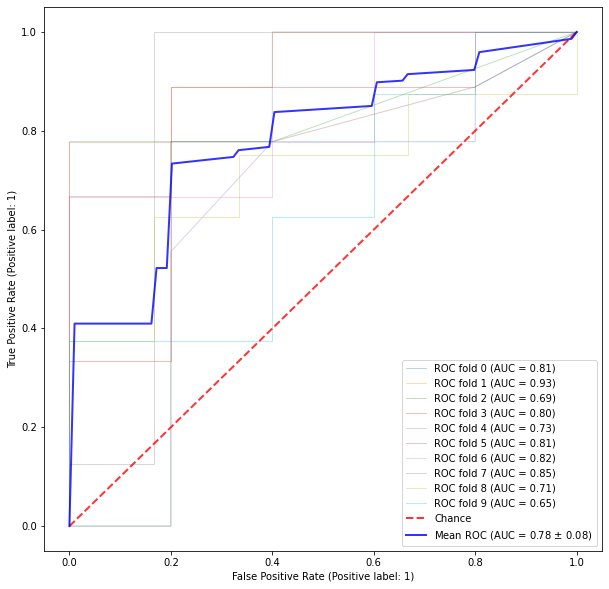

[[0.56750908 0.10724084 0.20221931 0.00476555 0.00395161 0.00318558
  0.00269638 0.03134221 0.04007326 0.00424373 0.00761521 0.00274713
  0.00793735 0.00561556 0.00885722]]
{'n_estimators': 25, 'min_samples_split': 10, 'min_samples_leaf': 7, 'max_features': 'auto', 'max_depth': 3, 'learning_rate': 0.05}
{'n_estimators': 25, 'min_samples_split': 4, 'min_samples_leaf': 6, 'max_features': 'auto', 'max_depth': 1, 'learning_rate': 0.1}
{'n_estimators': 25, 'min_samples_split': 10, 'min_samples_leaf': 7, 'max_features': 'auto', 'max_depth': 3, 'learning_rate': 0.05}
{'n_estimators': 25, 'min_samples_split': 4, 'min_samples_leaf': 6, 'max_features': 'auto', 'max_depth': 1, 'learning_rate': 0.1}
{'n_estimators': 25, 'min_samples_split': 4, 'min_samples_leaf': 6, 'max_features': 'auto', 'max_depth': 1, 'learning_rate': 0.1}
{'n_estimators': 25, 'min_samples_split': 4, 'min_samples_leaf': 6, 'max_features': 'auto', 'max_depth': 1, 'learning_rate': 0.1}
{'n_estimators': 25, 'min_samples_split': 4

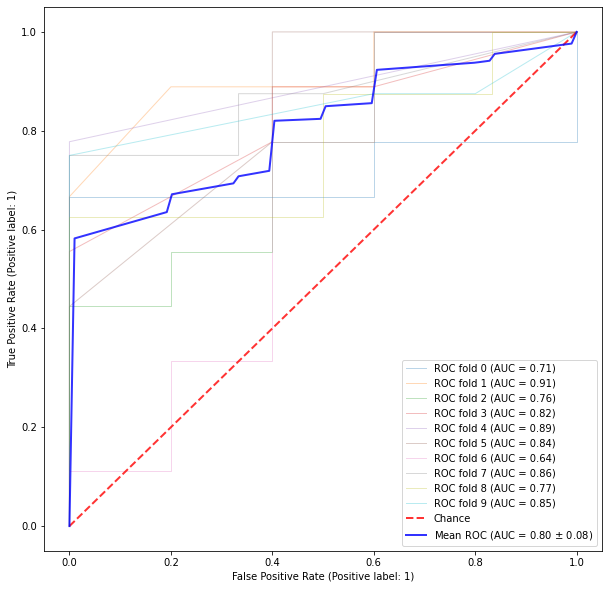

[[6.81029248e-01 1.62426138e-01 1.44069184e-01 1.59357046e-04
  1.33576668e-04 2.96893415e-04 0.00000000e+00 1.01955993e-03
  3.81231766e-05 3.44727951e-04 0.00000000e+00 2.58470897e-04
  3.56529071e-04 5.94593234e-03 3.92225912e-03]]
{'n_estimators': 35, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_features': 'auto', 'max_depth': 5, 'learning_rate': 0.5}
{'n_estimators': 35, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 3, 'learning_rate': 0.1}
{'n_estimators': 35, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 3, 'learning_rate': 0.1}
{'n_estimators': 20, 'min_samples_split': 4, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'max_depth': 7, 'learning_rate': 0.001}
{'n_estimators': 35, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 3, 'learning_rate': 0.1}
{'n_estimators': 40, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 6, 'lea

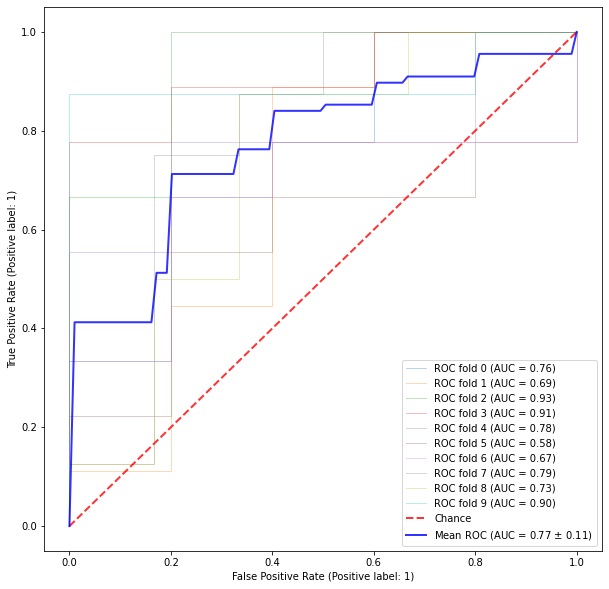

[[0.3733482  0.23334177 0.23282944 0.00973235 0.00956864 0.00980173
  0.0078383  0.01277461 0.03774559 0.01091085 0.01161548 0.00586815
  0.01005862 0.01830029 0.01626597]]
FPR
array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
       0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
       0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
       0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
       0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
       0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
       0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
       0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
       0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
       0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
       0.60606061, 

In [ ]:
GBDT_train_III = Final_Model_Train(Train_Nested_wo_sampling, x_III, y_III, ML_model='GBDT', Tuning_param= GBDT_tuning_parameter, 
                                   outer_loop= outer_loop, inner_loop= inner_loop, random_search_number= 10, random_seed= random_seed,
                                   iteration_num = iteration_num, imp=True)

In [ ]:
XGBoost_train_III = Final_Model_Train(XGBoost_Train_Nested_wo_sampling, x_III.values, y_III.values, ML_model='XGBoost', Tuning_param= Xgboost_tuning_parameter, 
                                      outer_loop= outer_loop, inner_loop= inner_loop, random_search_number= 10, random_seed= random_seed,
                                      iteration_num = iteration_num, imp=True)

In [ ]:
LGBM_train_III = Final_Model_Train(Train_Nested_wo_sampling, x_III, y_III, ML_model='LGBM', Tuning_param= LGBM_tuning, 
                                   outer_loop= outer_loop, inner_loop= inner_loop, random_search_number= 10, random_seed= random_seed,
                                   iteration_num = iteration_num, imp=True)

#Significance Check:

In [ ]:
XGBoost_train_III['AUCs'].mean()

0.7795555555555554

In [ ]:
print(AdaBoost_train_I['Precision'].mean())
print(AdaBoost_train_I['Precision'].std())
print('\n\n')
print(RF_train_I['Precision'].mean())
print(RF_train_I['Precision'].std())
print('\n\n')
print(XGBoost_train_I['Precision'].mean())
print(XGBoost_train_I['Precision'].std())
print('\n\n')
print(LR_train_I['Precision'].mean())
print(LR_train_I['Precision'].std())


0.8216854256854256
0.09148805102072058



0.793954822954823
0.08606802118401724



0.8168728216228215
0.10234424960686277



0.7635393217893218
0.09900986792552759


In [ ]:
print(AdaBoost_train_I['Accuracy'].mean())
print(AdaBoost_train_I['Accuracy'].std())
print('\n\n')
print(RF_train_I['Accuracy'].mean())
print(RF_train_I['Accuracy'].std())
print('\n\n')
print(XGBoost_train_I['Accuracy'].mean())
print(XGBoost_train_I['Accuracy'].std())
print('\n\n')
print(LR_train_I['Accuracy'].mean())
print(LR_train_I['Accuracy'].std())


0.7845054945054948
0.10386092109666165



0.7728571428571428
0.09074494792662571



0.7620329670329669
0.10664634178969071



0.7119780219780218
0.10042831831666332


In [ ]:
print(AdaBoost_train_I['Sensitivity'].mean())
print(AdaBoost_train_I['Sensitivity'].std())
print('\n\n')
print(RF_train_I['Sensitivity'].mean())
print(RF_train_I['Sensitivity'].std())
print('\n\n')
print(XGBoost_train_I['Sensitivity'].mean())
print(XGBoost_train_I['Sensitivity'].std())
print('\n\n')
print(LR_train_I['Sensitivity'].mean())
print(LR_train_I['Sensitivity'].std())


0.851388888888889
0.13258615880314523



0.8751388888888889
0.11442109726794268



0.8151388888888889
0.1291098291913794



0.805138888888889
0.12121515345007787


In [ ]:
print(AdaBoost_train_I['Specificity'].mean())
print(AdaBoost_train_I['Specificity'].std())
print('\n\n')
print(RF_train_I['Specificity'].mean())
print(RF_train_I['Specificity'].std())
print('\n\n')
print(XGBoost_train_I['Specificity'].mean())
print(XGBoost_train_I['Specificity'].std())
print('\n\n')
print(LR_train_I['Specificity'].mean())
print(LR_train_I['Specificity'].std())


0.6733333333333333
0.20022209890241607



0.6006666666666667
0.2002764755698149



0.6743333333333332
0.21285649834780446



0.5563333333333335
0.2331758992691998


In [ ]:
print(AdaBoost_train_I['AUCs'].mean())
print(AdaBoost_train_I['AUCs'].std())
print('\n\n')
print(RF_train_I['AUCs'].mean())
print(RF_train_I['AUCs'].std())
print('\n\n')
print(XGBoost_train_I['AUCs'].mean())
print(XGBoost_train_I['AUCs'].std())
print('\n\n')
print(LR_train_I['AUCs'].mean())
print(LR_train_I['AUCs'].std())


0.8240555555555557
0.10724419212165834



0.8304305555555556
0.10338318223399375



0.8023055555555557
0.12164295653040005



0.7735138888888887
0.12523346330669818


AUCs (Experiment I):

In [ ]:
from scipy.stats import ttest_rel

print('AdaBoost VS    LR:             ', end='   ')
_, p = ttest_rel(AdaBoost_train_I['Specificity'], LR_train_I['Specificity'])
print(p, end='\n\n')

print('RF       VS    LR:             ', end='   ')
_, p = ttest_rel(RF_train_I['Specificity'], LR_train_I['Specificity'])
print(p, end='\n\n')

#print('LightGBM VS    LR:             ', end='   ')
#_, p = ttest_rel(LGBM_train_I['Accuracy'], LR_train_I['Accuracy'])
#print(p, end='\n\n')

print('XGBoost  VS    LR:             ', end='   ')
_, p = ttest_rel(XGBoost_train_I['Specificity'], LR_train_I['Specificity'])
print(p, end='\n\n')

#print('GBDT     VS    LR:             ', end='   ')
#_, p = ttest_rel(GBDT_train_I['Accuracy'], LR_train_I['Accuracy'])
#print(p, end='\n\n')


####################
print('\n\n')


print('AdaBoost VS    RF:             ', end='   ')
_, p = ttest_rel(AdaBoost_train_I['AUCs'], RF_train_I['AUCs'])
print(p, end='\n\n')

print('GBDT     VS    RF:             ', end='   ')
_, p = ttest_rel(GBDT_train_I['AUCs'], RF_train_I['AUCs'])
print(p, end='\n\n')

print('GBDT     VS    AdaBoost:       ', end='   ')
_, p = ttest_rel(AdaBoost_train_I['AUCs'], GBDT_train_I['AUCs'])
print(p, end='\n\n')

print('XGBoost  VS    RF:             ', end='   ')
_, p = ttest_rel(XGBoost_train_I['AUCs'], RF_train_I['AUCs'])
print(p, end='\n\n')

print('XGBoost  VS    AdaBoost:       ', end='   ')
_, p = ttest_rel(XGBoost_train_I['AUCs'], AdaBoost_train_I['AUCs'])
print(p, end='\n\n')

print('LightGBM VS    RF:             ', end='   ')
_, p = ttest_rel(LGBM_train_I['AUCs'], RF_train_I['AUCs'])
print(p, end='\n\n')

print('LightGBM VS    AdaBoost:       ', end='   ')
_, p = ttest_rel(LGBM_train_I['AUCs'], AdaBoost_train_I['AUCs'])
print(p, end='\n\n')

AdaBoost VS    LR:                2.8107160507689165e-07

RF       VS    LR:                0.04132685429999367

XGBoost  VS    LR:                3.866525555441025e-07




AdaBoost VS    RF:                0.4180119259460823

GBDT     VS    RF:                

NameError: ignored

Experiment I and III (AdaBoost):

In [ ]:
from scipy.stats import ttest_rel

print('Experiment I and III (AdaBoost):\n\n')

_, p = ttest_rel(AdaBoost_train_I['Precision'], AdaBoost_train_III['Precision'])
print()
print('Precision                   ', end='   ')
print(p, end='\n\n')

_, p = ttest_rel(AdaBoost_train_I['Sensitivity'], AdaBoost_train_III['Sensitivity'])
print('Sensitivity (Recall):       ', end='   ')
print(p, end='\n\n')

_, p = ttest_rel(AdaBoost_train_I['Specificity'], AdaBoost_train_III['Specificity'])
print('Specificity:                ', end='   ')
print(p, end='\n\n')

_, p = ttest_rel(AdaBoost_train_I['Accuracy'], AdaBoost_train_III['Accuracy'])
print('Accuracy:                   ', end='   ')
print(p, end='\n\n')

_, p = ttest_rel(AdaBoost_train_I['AUCs'], AdaBoost_train_III['AUCs'])
print('AUC:                        ', end='   ')
print(p, end='\n\n')



Experiment I and III (AdaBoost):



Precision                      0.2124758545083352

Sensitivity (Recall):          4.517479265948174e-06

Specificity:                   0.8904842060183868

Accuracy:                      0.0002476349544914849

AUC:                           0.0002608030516646073



Experiment I and III (RF):

In [ ]:
from scipy.stats import ttest_rel

print('Experiment I and III (RF):\n\n')

_, p = ttest_rel(RF_train_I['Precision'], RF_train_III['Precision'])
print()
print('Precision                  ', end='   ')
print(p, end='\n\n')

_, p = ttest_rel(RF_train_I['Sensitivity'], RF_train_III['Sensitivity'])
print('Sensitivity (Recall):      ', end='   ')
print(p, end='\n\n')

_, p = ttest_rel(RF_train_I['Specificity'], RF_train_III['Specificity'])
print('Specificity:               ', end='   ')
print(p, end='\n\n')

_, p = ttest_rel(RF_train_I['Accuracy'], RF_train_III['Accuracy'])
print('Accuracy:                  ', end='   ')
print(p, end='\n\n')

_, p = ttest_rel(RF_train_I['AUCs'], RF_train_III['AUCs'])
print('AUC:                       ', end='   ')
print(p, end='\n\n')



Experiment I and III (RF):



Precision                     0.0001600170296666127

Sensitivity (Recall):         0.008562184541935526

Specificity:                  0.0004432282440275929

Accuracy:                     7.038469057170625e-06

AUC:                          0.00026640887826068563



Experiment I and III (XGBoost):

In [ ]:
from scipy.stats import ttest_rel

print('Experiment I and III (XGBoost):\n\n')

_, p = ttest_rel(XGBoost_train_I['Precision'], AdaBoost_train_III['Precision'])
print()
print('Precision                   ', end='   ')
print(p, end='\n\n')

_, p = ttest_rel(XGBoost_train_I['Sensitivity'], XGBoost_train_III['Sensitivity'])
print('Sensitivity (Recall):       ', end='   ')
print(p, end='\n\n')

_, p = ttest_rel(XGBoost_train_I['Specificity'], XGBoost_train_III['Specificity'])
print('Specificity:                ', end='   ')
print(p, end='\n\n')

_, p = ttest_rel(XGBoost_train_I['Accuracy'], XGBoost_train_III['Accuracy'])
print('Accuracy:                   ', end='   ')
print(p, end='\n\n')

_, p = ttest_rel(XGBoost_train_I['AUCs'], XGBoost_train_III['AUCs'])
print('AUC:                        ', end='   ')
print(p, end='\n\n')



Experiment I and III (XGBoost):



Precision                      0.5631608311727706

Sensitivity (Recall):          0.07228502769567167

Specificity:                   0.5133475964510013

Accuracy:                      0.07821157231296626

AUC:                           0.012259112724695898



Experiment I and III (LightGBM):

In [ ]:
from scipy.stats import ttest_rel

print('Experiment I and III (LightGBM):\n\n')

_, p = ttest_rel(LGBM_train_I['Precision'], LGBM_train_III['Precision'])
print()
print('Precision                   ', end='   ')
print(p, end='\n\n')

_, p = ttest_rel(LGBM_train_I['Sensitivity'], LGBM_train_III['Sensitivity'])
print('Sensitivity (Recall):       ', end='   ')
print(p, end='\n\n')

_, p = ttest_rel(LGBM_train_I['Specificity'], LGBM_train_III['Specificity'])
print('Specificity:                ', end='   ')
print(p, end='\n\n')

_, p = ttest_rel(LGBM_train_I['Accuracy'], LGBM_train_III['Accuracy'])
print('Accuracy:                   ', end='   ')
print(p, end='\n\n')

_, p = ttest_rel(LGBM_train_I['AUCs'], LGBM_train_III['AUCs'])
print('AUC:                        ', end='   ')
print(p, end='\n\n')



Experiment I and III (LightGBM):




NameError: ignored

In [ ]:
from scipy.stats import ttest_rel

print('Experiment II and III (LightGBM):\n\n')

_, p = ttest_rel(LGBM_train_II['Precision'], LGBM_train_III['Precision'])
print()
print('Precision                   ', end='   ')
print(p, end='\n\n')

_, p = ttest_rel(LGBM_train_II['Sensitivity'], LGBM_train_III['Sensitivity'])
print('Sensitivity (Recall):       ', end='   ')
print(p, end='\n\n')

_, p = ttest_rel(LGBM_train_II['Specificity'], LGBM_train_III['Specificity'])
print('Specificity:                ', end='   ')
print(p, end='\n\n')

_, p = ttest_rel(LGBM_train_II['Accuracy'], LGBM_train_III['Accuracy'])
print('Accuracy:                   ', end='   ')
print(p, end='\n\n')

_, p = ttest_rel(LGBM_train_II['AUCs'], LGBM_train_III['AUCs'])
print('AUC:                        ', end='   ')
print(p, end='\n\n')



Experiment II and III (LightGBM):




NameError: ignored

Experiment I and III (GBDT):

In [ ]:
from scipy.stats import ttest_rel

print('Experiment I and III (GBDT):\n\n')

_, p = ttest_rel(GBDT_train_I['Precision'], GBDT_train_III['Precision'])
print()
print('Precision                   ', end='   ')
print(p, end='\n\n')

_, p = ttest_rel(GBDT_train_I['Sensitivity'], GBDT_train_III['Sensitivity'])
print('Sensitivity (Recall):       ', end='   ')
print(p, end='\n\n')

_, p = ttest_rel(GBDT_train_I['Specificity'], GBDT_train_III['Specificity'])
print('Specificity:                ', end='   ')
print(p, end='\n\n')

_, p = ttest_rel(GBDT_train_I['Accuracy'], GBDT_train_III['Accuracy'])
print('Accuracy:                   ', end='   ')
print(p, end='\n\n')

_, p = ttest_rel(GBDT_train_I['AUCs'], GBDT_train_III['AUCs'])
print('AUC:                        ', end='   ')
print(p, end='\n\n')



Experiment I and III (GBDT):




NameError: ignored

In [ ]:
from scipy.stats import ttest_rel

print('Experiment II and III (GBDT):\n\n')

_, p = ttest_rel(GBDT_train_II['Precision'], GBDT_train_III['Precision'])
print()
print('Precision                   ', end='   ')
print(p, end='\n\n')

_, p = ttest_rel(GBDT_train_II['Sensitivity'], GBDT_train_III['Sensitivity'])
print('Sensitivity (Recall):       ', end='   ')
print(p, end='\n\n')

_, p = ttest_rel(GBDT_train_II['Specificity'], GBDT_train_III['Specificity'])
print('Specificity:                ', end='   ')
print(p, end='\n\n')

_, p = ttest_rel(GBDT_train_II['Accuracy'], GBDT_train_III['Accuracy'])
print('Accuracy:                   ', end='   ')
print(p, end='\n\n')

_, p = ttest_rel(GBDT_train_II['AUCs'], GBDT_train_III['AUCs'])
print('AUC:                        ', end='   ')
print(p, end='\n\n')



Experiment II and III (GBDT):




NameError: ignored

In [ ]:
from scipy.stats import ttest_rel

print('Comparison Between Tree-Based and LR (Experiment I):\n\n')

_, p = ttest_rel(AdaBoost_train_I['AUCs'], LR_train_I['AUCs'])
print()
print('Precision - AdaBoost VS LR:              ', end='   ')
print(p, end='\n\n')

_, p = ttest_rel(RF_train_I['AUCs'], LR_train_I['AUCs'])
print('Sensitivity (Recall) - (RF VS LR):       ', end='   ')
print(p, end='\n\n')

_, p = ttest_rel(XGBoost_train_I['AUCs'], LR_train_I['AUCs'])
print('Specificity - (XGBoost VS LR):           ', end='   ')
print(p, end='\n\n')

#_, p = ttest_rel(LGBM_train_I['AUCs'], LR_train_I['AUCs'])
#print('Accuracy - LightGBM VS LR                ', end='   ')
#print(p, end='\n\n')

#_, p = ttest_rel(GBDT_train_I['AUCs'], LR_train_I['AUCs'])
#print('AUC - GBDT VS LR                         ', end='   ')
#print(p, end='\n\n')



Comparison Between Tree-Based and LR (Experiment I):



Precision - AdaBoost VS LR:                 5.284763281246852e-06

Sensitivity (Recall) - (RF VS LR):          6.822494015675146e-10

Specificity - (XGBoost VS LR):              0.0010271410008063555



#Feature Importance:

In [ ]:
labels = ["age", "lowabi", "bmi", "pep", "et", "sex_0", "sex_1", "dm_0", "dm_1", "ht_0", "ht_1", "lipidemia_0", "lipidemia_1", "PCI_0", "PCI_1", "STEMI_0", "STEMI_1"]

AdaBoost_feature_imp = np.array([0.60686667, 0.1972,     0.08916667, 0.04533333, 0.04843333, 0.,
  0.,         0.,         0.,         0.00566667, 0.00733333, 0.,
  0.,         0.,         0.,         0.,         0.        ])

RF_feature_imp = np.array([0.33713031, 0.16675777, 0.16306411, 0.06720469, 0.12443634, 0.0124158,
  0.01414435, 0.00376286, 0.0033039,  0.03054415, 0.03847222, 0.00635527,
  0.00609934, 0.00676303, 0.00840126, 0.00570353, 0.00544108])

#GBDT_feature_importance = np.array([0.33031301, 0.06657554, 0.15200585, 0.1420839 , 0.07517263,
#         0.14780769, 0.0048494 , 0.00465334, 0.00300619, 0.00279989,
#         0.01629663, 0.01496073, 0.00387297, 0.00512149, 0.00507899,
#         0.00486818, 0.01003062, 0.01050295])

XGBoost_feature_importance = np.array([0.15565567, 0.08354061, 0.10055161, 0.10161958, 0.08093312,
         0.10181271, 0.06175789, 0.        , 0.04812681, 0.        ,
         0.08854028, 0.        , 0.05621729, 0.        , 0.0629127 ,
        0.        , 0.05833174, 0.        ])

In [ ]:
XGBoost_feature_importance.sum()

1.00000001

In [ ]:
import pandas as pd
Feature_Importance_plotter(labels, AdaBoost_feature_imp, figsize=(10, 8))

In [ ]:
print("Random Forest")
asd = np.array([0.33713031, 0.16675777, 0.16306411, 0.06720469, 0.12443634, 0.0124158,
  0.01414435, 0.00376286, 0.0033039,  0.03054415, 0.03847222, 0.00635527,
  0.00609934, 0.00676303, 0.00840126, 0.00570353, 0.00544108])
for i, j in zip(labels, asd):
  print(i, j)

Random Forest
age 0.33713031
lowabi 0.16675777
bmi 0.16306411
pep 0.06720469
et 0.12443634
sex_0 0.0124158
sex_1 0.01414435
dm_0 0.00376286
dm_1 0.0033039
ht_0 0.03054415
ht_1 0.03847222
lipidemia_0 0.00635527
lipidemia_1 0.00609934
PCI_0 0.00676303
PCI_1 0.00840126
STEMI_0 0.00570353
STEMI_1 0.00544108


In [ ]:
Feature_Importance_plotter(labels, RF_feature_imp, figsize=(10, 8))

In [ ]:
Feature_Importance_plotter(labels, GBDT_feature_importance, figsize=(10, 8))

In [ ]:
Feature_Importance_plotter(labels, XGBoost_feature_importance, figsize=(10, 8))

#AUC Plots:

In [ ]:
SVM_train_I['AUCs'].mean()

{'AUCs': array([0.97777778, 0.68888889, 0.73333333, 0.88888889, 0.91111111,
        0.77777778, 0.42222222, 0.83333333, 0.6875    , 0.525     ,
        0.75555556, 0.77777778, 0.75555556, 0.73333333, 0.48888889,
        0.93333333, 0.93333333, 0.875     , 0.83333333, 0.8       ,
        0.91111111, 0.64444444, 0.64444444, 0.73333333, 0.8       ,
        0.77777778, 0.93333333, 0.6875    , 0.83333333, 0.65      ,
        0.57777778, 0.77777778, 0.73333333, 0.75555556, 0.62222222,
        0.75555556, 0.84444444, 0.85416667, 0.77083333, 0.875     ,
        0.66666667, 0.8       , 0.84444444, 0.68888889, 0.86666667,
        0.68888889, 0.73333333, 0.95833333, 0.77083333, 0.725     ,
        0.71111111, 0.91111111, 0.82222222, 0.73333333, 0.75555556,
        0.68888889, 0.84444444, 0.89583333, 0.70833333, 0.9       ,
        0.84444444, 0.8       , 0.71111111, 0.75555556, 0.62222222,
        0.75555556, 0.82222222, 0.70833333, 0.77083333, 0.55      ,
        0.86666667, 0.75555556, 0.755555

In [ ]:
SVM_train_I['Specificity'].mean()

0.529

In [ ]:
AdaBoost_AUC = np.mean([[0.71, 0.78, 0.89, 0.93, 0.76, 0.96, 0.84, 0.7 , 0.94, 0.91],
                        [0.71, 0.78, 0.89, 0.93, 0.76, 0.96, 0.84, 0.66, 0.94, 0.91],
                        [0.71, 0.78, 0.89, 0.93, 0.76, 0.96, 0.84, 0.7 , 0.94, 0.92],
                        [0.71, 0.78, 0.89, 0.93, 0.76, 0.96, 0.84, 0.7 , 0.94, 0.91],
                        [0.71, 0.78, 0.89, 0.93, 0.76, 0.96, 0.84, 0.7 , 0.94, 0.91],
                        [0.71, 0.76, 0.89, 0.93, 0.76, 0.96, 0.84, 0.66, 0.94, 0.92],
                        [0.71, 0.78, 0.89, 0.93, 0.76, 0.96, 0.84, 0.66, 0.94, 0.92],
                        [0.71, 0.78, 0.89, 0.93, 0.76, 0.98, 0.84, 0.7 , 0.94, 0.92],
                        [0.71, 0.78, 0.89, 0.93, 0.76, 0.96, 0.84, 0.7 , 0.94, 0.91],
                        [0.71, 0.78, 0.89, 0.93, 0.76, 0.96, 0.84, 0.66, 0.94, 0.91]], axis=0)

RF_AUC = np.mean([[0.87, 0.76, 0.87, 0.93, 0.76, 0.98, 0.78, 0.65, 1.  , 0.9 ],
                  [0.93, 0.69, 0.89, 0.93, 0.82, 0.98, 0.73, 0.73, 1.  , 0.88],
                  [0.82, 0.76, 0.93, 0.91, 0.82, 0.93, 0.73, 0.75, 1.  , 0.9 ],
                  [0.84, 0.76, 0.91, 0.89, 0.76, 0.98, 0.78, 0.67, 1.  , 0.9 ],
                  [0.84, 0.71, 0.89, 0.91, 0.78, 1.  , 0.78, 0.77, 1.  , 0.8 ],
                  [0.87, 0.69, 0.91, 0.93, 0.8 , 0.98, 0.76, 0.75, 1.  , 0.9 ],
                  [0.91, 0.69, 0.87, 0.91, 0.78, 0.98, 0.73, 0.73, 0.98, 0.88],
                  [0.87, 0.71, 0.87, 0.91, 0.8 , 0.96, 0.71, 0.73, 1.  , 0.88],
                  [0.87, 0.78, 0.96, 0.89, 0.76, 0.98, 0.71, 0.75, 0.98, 0.9 ],
                  [0.87, 0.71, 0.89, 0.93, 0.73, 0.93, 0.8 , 0.75, 1.  , 0.88]], axis=0)

GBDT_AUC = np.mean([[0.96, 0.73, 0.73, 0.76, 0.64, 0.91, 0.8 , 0.77, 0.81, 0.78],
                   [0.93, 0.8 , 0.73, 0.73, 0.93, 0.84, 0.96, 0.81, 0.73, 0.73],
                   [0.96, 0.73, 0.73, 0.87, 0.82, 0.8 , 0.89, 0.9 , 0.81, 0.72],
                   [0.96, 0.71, 0.76, 0.78, 0.87, 0.78, 0.93, 0.77, 0.69, 0.62],
                   [0.96, 0.84, 0.73, 0.73, 0.87, 0.8 , 0.82, 0.81, 0.85, 0.7 ],
                   [0.96, 0.69, 0.67, 0.76, 0.78, 0.87, 0.87, 0.85, 0.79, 0.72],
                   [0.96, 0.82, 0.71, 0.82, 0.93, 0.8 , 0.89, 0.75, 0.79, 0.73],
                   [0.96, 0.73, 0.73, 0.73, 0.96, 0.82, 0.89, 0.88, 0.75, 0.72],
                   [0.89, 0.76, 0.76, 0.69, 0.89, 0.71, 0.84, 0.85, 0.9 , 0.68],
                   [0.93, 0.76, 0.71, 0.82, 0.87, 0.84, 0.93, 0.83, 0.81, 0.82]], axis=0)

XGBoost_AUC = np.mean([[0.76, 0.67, 0.93, 0.96, 0.73, 0.93, 0.82, 0.62, 0.92, 0.85],
                       [0.82, 0.73, 0.93, 0.96, 0.71, 0.93, 0.84, 0.65, 1.  , 0.82],
                       [0.8 , 0.8 , 0.93, 0.96, 0.71, 1.  , 0.84, 0.69, 0.98, 0.85],
                       [0.73, 0.64, 0.87, 0.93, 0.78, 1.  , 0.78, 0.6 , 0.98, 0.85],
                       [0.8 , 0.76, 0.91, 0.98, 0.76, 0.98, 0.84, 0.6 , 0.94, 0.88],
                       [0.82, 0.64, 0.91, 0.98, 0.73, 0.93, 0.84, 0.65, 0.94, 0.9 ],
                       [0.82, 0.73, 0.96, 0.91, 0.71, 0.96, 0.82, 0.67, 1.  , 0.92],
                       [0.8 , 0.78, 0.84, 0.98, 0.71, 0.96, 0.84, 0.65, 1.  , 0.9 ],
                       [0.82, 0.69, 0.98, 0.93, 0.73, 1.  , 0.84, 0.69, 0.98, 0.88],
                       [0.82, 0.69, 0.91, 0.96, 0.71, 0.96, 0.76, 0.67, 0.96, 0.9 ]], axis =0)

LGBM_AUC = np.mean([[0.78, 0.76, 0.96, 0.91, 0.76, 0.93, 0.84, 0.69, 0.88, 0.92],
                    [0.8 , 0.76, 0.98, 0.89, 0.8 , 1.  , 0.84, 0.71, 0.96, 0.95],
                    [0.62, 0.84, 0.98, 0.87, 0.76, 0.98, 0.8 , 0.67, 0.96, 0.92],
                    [0.83, 0.82, 0.98, 0.82, 0.76, 0.96, 0.82, 0.62, 0.96, 0.92],
                    [0.73, 0.84, 0.82, 0.89, 0.62, 0.89, 0.82, 0.62, 0.96, 0.98],
                    [0.78, 0.76, 0.98, 0.91, 0.76, 0.93, 0.76, 0.62, 0.96, 1.  ],
                    [0.64, 0.67, 0.98, 0.89, 0.76, 0.96, 0.84, 0.69, 0.98, 1.  ],
                    [0.64, 0.78, 0.98, 0.89, 0.76, 0.98, 0.8 , 0.62, 0.96, 0.98],
                    [0.58, 0.76, 0.98, 0.98, 0.73, 0.96, 0.8 , 0.69, 0.99, 0.92],
                    [0.69, 0.76, 0.91, 0.89, 0.76, 0.96, 0.84, 0.69, 0.98, 1.  ]], axis=0)

LR_AUC = np.mean([[0.76, 0.71, 0.76, 0.71, 0.69, 0.96, 0.62, 0.69, 0.9 , 0.8 ],
                  [0.76, 0.71, 0.76, 0.71, 0.69, 0.96, 0.62, 0.69, 0.9 , 0.8 ],
                  [0.76, 0.71, 0.76, 0.71, 0.69, 0.96, 0.62, 0.69, 0.9 , 0.8 ],
                  [0.76, 0.71, 0.76, 0.71, 0.69, 0.96, 0.62, 0.69, 0.9 , 0.8 ],
                  [0.76, 0.71, 0.76, 0.71, 0.69, 0.96, 0.62, 0.69, 0.9 , 0.8 ],
                  [0.76, 0.71, 0.76, 0.71, 0.69, 0.96, 0.62, 0.69, 0.9 , 0.8 ],
                  [0.76, 0.71, 0.76, 0.71, 0.69, 0.96, 0.62, 0.69, 0.9 , 0.8 ],
                  [0.76, 0.71, 0.76, 0.71, 0.69, 0.96, 0.62, 0.69, 0.9 , 0.8 ],
                  [0.76, 0.71, 0.76, 0.71, 0.69, 0.96, 0.62, 0.69, 0.9 , 0.8 ],
                  [0.76, 0.71, 0.76, 0.71, 0.69, 0.96, 0.62, 0.69, 0.9 , 0.8 ]], axis=0)

In [ ]:
from scipy.stats import ttest_rel
_, p = ttest_rel(RF_AUC.flatten(), LR_AUC.flatten())
print('Random Forest & Logistic Regression: ', end='   ')
print(p, end='\n\n')
_, p = ttest_rel(XGBoost_AUC.flatten(), LR_AUC.flatten())
print('XGBoost & Logistic Regression:       ', end='   ')
print(p, end='\n\n')
_, p = ttest_rel(GBDT_AUC.flatten(), LR_AUC.flatten())
print('GBDT & Logistic Regression:          ', end='   ')
print(p, end='\n\n')
_, p = ttest_rel(RF_AUC.flatten(), GBDT_AUC.flatten())
print('Random Forest & GBDT:                ', end='   ')
print(p, end='\n\n')
_, p = ttest_rel(RF_AUC.flatten(), XGBoost_AUC.flatten())
print('Random Forest & XGBoost:             ', end='   ')
print(p, end='\n\n')
_, p = ttest_rel(GBDT_AUC.flatten(), XGBoost_AUC.flatten())
print('GBDT & XGBoost:                      ', end='   ')
print(p, end='\n\n')
_, p = ttest_rel(LGBM_AUC.flatten(), RF_AUC.flatten())
print('Light GBM & Random Forest:           ', end='   ')
print(p, end='\n\n')
_, p = ttest_rel(LGBM_AUC.flatten(), LR_AUC.flatten())
print('Light GBM & Logistic Regression:     ', end='   ')
print(p, end='\n\n')
_, p = ttest_rel(AdaBoost_AUC.flatten(), LR_AUC.flatten())
print('AdaBoost & Logistic Regression:      ', end='   ')
print(p, end='\n\n')
_, p = ttest_rel(AdaBoost_AUC.flatten(), RF_AUC.flatten())
print('AdaBoost & Random Forest:            ', end='   ')
print(p, end='\n\n')
_, p = ttest_rel(AdaBoost_AUC.flatten(), LGBM_AUC.flatten())
print('AdaBoost & Light GBM:                ', end='   ')
print(p, end='\n\n')

In [ ]:
print("Random Forest AUCs:", end="    ")
print(RF_AUC, end="\n\n")

print("GBDT AUCs:", end="             ")
print(GBDT_AUC, end="\n\n")

print("Light GBM AUCs:", end="        ")
print(LGBM_AUC, end="\n\n")

print("AdaBoost AUCs:", end="         ")
print(AdaBoost_AUC, end="\n\n")

print("XGBoost AUCs:", end="          ")
print(XGBoost_AUC, end="\n\n")

print("LR AUCs:", end="               ")
print(LR_AUC, end="\n\n")

In [ ]:
print(AdaBoost_AUC.mean())
print(RF_AUC.mean())

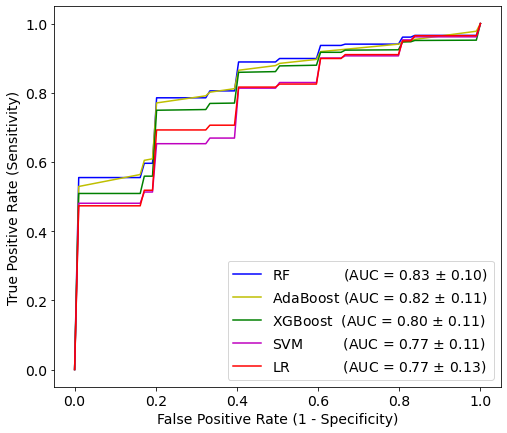

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

FPR = np.array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
       0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
       0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
       0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
       0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
       0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
       0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
       0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
       0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
       0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
       0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
       0.65656566, 0.66666667, 0.67676768, 0.68686869, 0.6969697 ,
       0.70707071, 0.71717172, 0.72727273, 0.73737374, 0.74747475,
       0.75757576, 0.76767677, 0.77777778, 0.78787879, 0.7979798 ,
       0.80808081, 0.81818182, 0.82828283, 0.83838384, 0.84848485,
       0.85858586, 0.86868687, 0.87878788, 0.88888889, 0.8989899 ,
       0.90909091, 0.91919192, 0.92929293, 0.93939394, 0.94949495,
       0.95959596, 0.96969697, 0.97979798, 0.98989899, 1.        ])

RF_TPR_I = np.array([0.        , 0.55486111, 0.55486111, 0.55486111, 0.55486111,
       0.55486111, 0.55486111, 0.55486111, 0.55486111, 0.55486111,
       0.55486111, 0.55486111, 0.55486111, 0.55486111, 0.55486111,
       0.55486111, 0.55486111, 0.59611111, 0.59611111, 0.59611111,
       0.78541667, 0.78541667, 0.78541667, 0.78541667, 0.78541667,
       0.78541667, 0.78541667, 0.78541667, 0.78541667, 0.78541667,
       0.78541667, 0.78541667, 0.78541667, 0.80541667, 0.80541667,
       0.80541667, 0.80541667, 0.80541667, 0.80541667, 0.80541667,
       0.88902778, 0.88902778, 0.88902778, 0.88902778, 0.88902778,
       0.88902778, 0.88902778, 0.88902778, 0.88902778, 0.88902778,
       0.89902778, 0.89902778, 0.89902778, 0.89902778, 0.89902778,
       0.89902778, 0.89902778, 0.89902778, 0.89902778, 0.89902778,
       0.93680556, 0.93680556, 0.93680556, 0.93680556, 0.93680556,
       0.93680556, 0.94055556, 0.94055556, 0.94055556, 0.94055556,
       0.94055556, 0.94055556, 0.94055556, 0.94055556, 0.94055556,
       0.94055556, 0.94055556, 0.94055556, 0.94055556, 0.94055556,
       0.96083333, 0.96083333, 0.96083333, 0.96583333, 0.96583333,
       0.96583333, 0.96583333, 0.96583333, 0.96583333, 0.96583333,
       0.96583333, 0.96583333, 0.96583333, 0.96583333, 0.96583333,
       0.96583333, 0.96583333, 0.96583333, 0.96583333, 1.        ])



LR_TPR_I = np.array([0.        , 0.47319444, 0.47319444, 0.47319444, 0.47319444,
       0.47319444, 0.47319444, 0.47319444, 0.47319444, 0.47319444,
       0.47319444, 0.47319444, 0.47319444, 0.47319444, 0.47319444,
       0.47319444, 0.47319444, 0.51819444, 0.51819444, 0.51819444,
       0.6925    , 0.6925    , 0.6925    , 0.6925    , 0.6925    ,
       0.6925    , 0.6925    , 0.6925    , 0.6925    , 0.6925    ,
       0.6925    , 0.6925    , 0.6925    , 0.70625   , 0.70625   ,
       0.70625   , 0.70625   , 0.70625   , 0.70625   , 0.70625   ,
       0.81638889, 0.81638889, 0.81638889, 0.81638889, 0.81638889,
       0.81638889, 0.81638889, 0.81638889, 0.81638889, 0.81638889,
       0.82513889, 0.82513889, 0.82513889, 0.82513889, 0.82513889,
       0.82513889, 0.82513889, 0.82513889, 0.82513889, 0.82513889,
       0.89902778, 0.89902778, 0.89902778, 0.89902778, 0.89902778,
       0.89902778, 0.91027778, 0.91027778, 0.91027778, 0.91027778,
       0.91027778, 0.91027778, 0.91027778, 0.91027778, 0.91027778,
       0.91027778, 0.91027778, 0.91027778, 0.91027778, 0.91027778,
       0.95      , 0.95      , 0.95      , 0.965     , 0.965     ,
       0.965     , 0.965     , 0.965     , 0.965     , 0.965     ,
       0.965     , 0.965     , 0.965     , 0.965     , 0.965     ,
       0.965     , 0.965     , 0.965     , 0.965     , 1.        ])


AdaBoost_TPR_I = np.array([0.        , 0.52910845, 0.53141134, 0.53371423, 0.53601712,
       0.53832001, 0.5406229 , 0.54292579, 0.54522868, 0.54753157,
       0.54983446, 0.55213735, 0.55444024, 0.55674313, 0.55904602,
       0.56134891, 0.5636518 , 0.60465544, 0.60685985, 0.60906425,
       0.7706149 , 0.77232828, 0.77404167, 0.77575505, 0.77746843,
       0.77918182, 0.7808952 , 0.78260859, 0.78432197, 0.78603535,
       0.78774874, 0.78946212, 0.79117551, 0.80163889, 0.80333333,
       0.80502778, 0.80672222, 0.80841667, 0.81011111, 0.81180556,
       0.86508577, 0.86657796, 0.86807015, 0.86956234, 0.87105453,
       0.87254672, 0.87403891, 0.8755311 , 0.87702329, 0.87851548,
       0.88490035, 0.88617789, 0.88745543, 0.88873298, 0.89001052,
       0.89128807, 0.89256561, 0.89384315, 0.8951207 , 0.89639824,
       0.91896366, 0.92007286, 0.92118205, 0.92229125, 0.92340044,
       0.92450963, 0.92561883, 0.9267659 , 0.92791297, 0.92906004,
       0.93020712, 0.93135419, 0.93250126, 0.93364834, 0.93479541,
       0.93594248, 0.93708955, 0.93823663, 0.9393837 , 0.94053077,
       0.94672133, 0.9484436 , 0.95016587, 0.95431238, 0.95588314,
       0.95745389, 0.95902464, 0.9605954 , 0.96216615, 0.96373691,
       0.96530766, 0.96687841, 0.96844917, 0.97001992, 0.97159068,
       0.97316143, 0.97473218, 0.97630294, 0.97787369, 1.        ])


XGBoost_TPR_I = np.array([0.        , 0.50888889, 0.50888889, 0.50888889, 0.50888889,
       0.50888889, 0.50888889, 0.50888889, 0.50888889, 0.50888889,
       0.50888889, 0.50888889, 0.50888889, 0.50888889, 0.50888889,
       0.50888889, 0.50888889, 0.55888889, 0.55888889, 0.55888889,
       0.74947811, 0.74964646, 0.74981481, 0.74998316, 0.75015152,
       0.75031987, 0.75048822, 0.75065657, 0.75082492, 0.75099327,
       0.75116162, 0.75132997, 0.75149832, 0.76916667, 0.76933502,
       0.76950337, 0.76967172, 0.76984007, 0.77000842, 0.77017677,
       0.85911756, 0.85934203, 0.8595665 , 0.85979097, 0.86001543,
       0.8602399 , 0.86046437, 0.86068883, 0.8609133 , 0.86113777,
       0.87761223, 0.8778367 , 0.87806117, 0.87828563, 0.8785101 ,
       0.87873457, 0.87895903, 0.8791835 , 0.87940797, 0.87963244,
       0.91694444, 0.91694444, 0.91694444, 0.91694444, 0.91694444,
       0.91694444, 0.92319444, 0.9232702 , 0.92334596, 0.92342172,
       0.92349747, 0.92357323, 0.92364899, 0.92372475, 0.92380051,
       0.92387626, 0.92395202, 0.92402778, 0.92410354, 0.92417929,
       0.94707772, 0.9472096 , 0.94734147, 0.95118547, 0.95124158,
       0.9512977 , 0.95135382, 0.95140993, 0.95146605, 0.95152217,
       0.95157828, 0.9516344 , 0.95169052, 0.95174663, 0.95180275,
       0.95185887, 0.95191498, 0.9519711 , 0.95202722, 1.        ])


SVM_TPR_I = np.array([0.        , 0.48055556, 0.48055556, 0.48055556, 0.48055556,
       0.48055556, 0.48055556, 0.48055556, 0.48055556, 0.48055556,
       0.48055556, 0.48055556, 0.48055556, 0.48055556, 0.48055556,
       0.48055556, 0.48055556, 0.51305556, 0.51305556, 0.51305556,
       0.65277778, 0.65277778, 0.65277778, 0.65277778, 0.65277778,
       0.65277778, 0.65277778, 0.65277778, 0.65277778, 0.65277778,
       0.65277778, 0.65277778, 0.65277778, 0.66902778, 0.66902778,
       0.66902778, 0.66902778, 0.66902778, 0.66902778, 0.66902778,
       0.81333333, 0.81333333, 0.81333333, 0.81333333, 0.81333333,
       0.81333333, 0.81333333, 0.81333333, 0.81333333, 0.81333333,
       0.82958333, 0.82958333, 0.82958333, 0.82958333, 0.82958333,
       0.82958333, 0.82958333, 0.82958333, 0.82958333, 0.82958333,
       0.90041667, 0.90041667, 0.90041667, 0.90041667, 0.90041667,
       0.90041667, 0.90666667, 0.90666667, 0.90666667, 0.90666667,
       0.90666667, 0.90666667, 0.90666667, 0.90666667, 0.90666667,
       0.90666667, 0.90666667, 0.90666667, 0.90666667, 0.90666667,
       0.95291667, 0.95291667, 0.95291667, 0.96166667, 0.96166667,
       0.96166667, 0.96166667, 0.96166667, 0.96166667, 0.96166667,
       0.96166667, 0.96166667, 0.96166667, 0.96166667, 0.96166667,
       0.96166667, 0.96166667, 0.96166667, 0.96166667, 1.        ])


import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}
matplotlib.rc('font', **font)
plt.figure(figsize=(8, 7))
plt.plot(FPR, RF_TPR_I, 'b', FPR, AdaBoost_TPR_I, 'y', FPR, XGBoost_TPR_I, 'g', FPR, SVM_TPR_I, 'm', FPR, LR_TPR_I, 'r')
plt.legend(['RF            (AUC = 0.83 $\pm$ 0.10)', 'AdaBoost (AUC = 0.82 $\pm$ 0.11)', 'XGBoost  (AUC = 0.80 $\pm$ 0.11)','SVM         (AUC = 0.77 $\pm$ 0.11)', 'LR            (AUC = 0.77 $\pm$ 0.13)'], loc='lower right')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.show()

In [ ]:
print(LR_AUC.mean().round(decimals=2), LR_AUC.std().round(decimals=2))
print(RF_AUC.mean().round(decimals=2), RF_AUC.std().round(decimals=2))
print(GBDT_AUC.mean().round(decimals=2), GBDT_AUC.std().round(decimals=2))
print(XGBoost_AUC.mean().round(decimals=2), XGBoost_AUC.std().round(decimals=2))
print(AdaBoost_AUC.mean().round(decimals=2), AdaBoost_AUC.std().round(decimals=2))
print(LGBM_AUC.mean().round(decimals=2), LGBM_AUC.std().round(decimals=2))

NameError: ignored

#Test:

In [ ]:
print(RF_train_I['Sensitivity'].mean())
print(AdaBoost_train_I['Sensitivity'].mean())
print(XGBoost_train_I['Sensitivity'].mean())

0.8751388888888889
0.851388888888889
0.8283333333333335


In [ ]:
AUC_I = np.matrix([AdaBoost_train_I['AUCs'].ravel(), RF_train_I['AUCs'].ravel(), XGBoost_train_I['AUCs'].ravel()]).T
AUC_I

matrix([[0.88888889, 0.95555556, 0.88888889],
        [0.8       , 0.73333333, 0.68888889],
        [0.85555556, 0.88888889, 0.93333333],
        [1.        , 0.97777778, 1.        ],
        [0.83333333, 0.84444444, 0.83333333],
        [0.87777778, 0.8       , 0.82222222],
        [0.88888889, 0.8       , 0.57777778],
        [0.94791667, 0.95833333, 0.83333333],
        [0.625     , 0.64583333, 0.6875    ],
        [0.875     , 0.6       , 0.625     ],
        [0.82222222, 0.84444444, 0.84444444],
        [0.71111111, 0.86666667, 0.77777778],
        [0.53333333, 0.88888889, 0.88888889],
        [0.86666667, 0.82222222, 0.91111111],
        [0.6       , 0.53333333, 0.51111111],
        [0.88888889, 0.97777778, 0.95555556],
        [0.91111111, 0.91111111, 0.86666667],
        [0.85416667, 0.91666667, 0.83333333],
        [0.85416667, 0.77083333, 0.8125    ],
        [0.8125    , 0.85      , 0.85      ],
        [0.88888889, 0.91111111, 0.95555556],
        [0.73333333, 0.73333333, 0

In [ ]:
AdaBoost_train_I['AUCs'].shape
Accuracy_I = np.array([AdaBoost_train_I['Accuracy'], RF_train_I['Accuracy'], XGBoost_train_I['Accuracy']])
Sensitivity_I = np.array([AdaBoost_train_I['Sensitivity'], RF_train_I['Sensitivity'], XGBoost_train_I['Sensitivity']])
Specificity_I = np.array([AdaBoost_train_I['Specificity'], RF_train_I['Specificity'], XGBoost_train_I['Specificity']])
Precision_I = np.array([AdaBoost_train_I['Precision'], RF_train_I['Precision'], XGBoost_train_I['Precision']])
AUC_I = np.array([AdaBoost_train_I['AUCs'], RF_train_I['AUCs'], XGBoost_train_I['AUCs']])


In [ ]:
import scipy.io as sio
sio.savemat('Data.mat', mdict={'Accuracy': Accuracy_I, 
                               'Sensitivity': Sensitivity_I,
                               'Specificity': Specificity_I,
                               'Precision': Precision_I,
                               'AUC': AUC_I})


In [ ]:
AUC_I

array([[0.88888889, 0.8       , 0.85555556, 1.        , 0.83333333,
        0.87777778, 0.88888889, 0.94791667, 0.625     , 0.875     ,
        0.82222222, 0.71111111, 0.53333333, 0.86666667, 0.6       ,
        0.88888889, 0.91111111, 0.85416667, 0.85416667, 0.8125    ,
        0.88888889, 0.73333333, 0.63333333, 0.84444444, 0.82222222,
        0.68888889, 0.85555556, 0.92708333, 0.84375   , 0.7625    ,
        0.8       , 0.88888889, 0.72222222, 0.82222222, 0.77777778,
        0.81111111, 0.94444444, 0.83333333, 0.9375    , 0.675     ,
        0.57777778, 0.87777778, 0.97777778, 0.87777778, 0.86666667,
        0.8       , 0.73333333, 0.9375    , 0.78125   , 0.7       ,
        0.81111111, 0.86666667, 0.86666667, 0.91111111, 0.66666667,
        0.53333333, 0.73333333, 0.98958333, 0.65625   , 0.8875    ,
        0.91111111, 1.        , 0.81111111, 0.91111111, 0.63333333,
        0.87777778, 0.91111111, 0.85416667, 0.875     , 0.7875    ,
        0.71111111, 0.93333333, 0.76666667, 0.91

In [ ]:
XGBClassifier()